# Data Scientist - A/B Testing & Statistical Experiment


# Table of Content


# Introduction
Rider Cancellations create bad experiences for both Drivers and Riders on the The Company platform and impact The Company financially. The Rider Cancels team is working to develop a new ​cancellation policy for The Company, determining **how and when** riders should be charged a fee for cancelling their ride requests. As the lead Data Scientist on the Rider Cancels team, please explore and analyze the attached rider cancellation data to **​develop and recommend** a The Company Cancellation Fee policy.

## Objective
- Recommend a Cancellation Fee policy for **Riders**
    - Is cancellation fee help with The Company revenue?
    - If yes, best way
        - Which riders?
        - How much?
        - How to deliver?



## Overview Framework and Assumptions:
- What factors should The Company consider in determining the aforementioned cancellation policy?
- Should we even have a cancel policy?
- What is the impact of a cancel?
- What is the business impact of implementing your chosen cancel policy?
    - Short term Pros
        - Reduce cancellation count
        - Increase revenue

    - Short term Cons
        - A sudden drop of requested ride?
    
    - Long term Pros
        - Maintain high quality of riders => Increase satisfaction of drivers => Maintain quality and quantity of supply
        - Keep high quality of riders, remove bad riders => quality and quantity of demands => increase overall revenue 

    - Long term Cons
        - Discourage new riders to join The Company? (In case of The Company's goal is to increase market share in short run to gain more profit in long run)
        - Unable to monitor Ride service quality? (Cancellation could be good indicator for problem shooting including matching algo problem, eta calcuation problem)


## Segmentation
- Cancellation Stages
    - Cancel at:
        1. Before matched
        2. After accepted 
        
    - Assumption:
        - If cancellation_flag == 1 and driver_id is null, assume the rides were cancelled before matched
        - Rides that were cancelled after accepted by drivers are the most undesirable => drivers unhappy

- accepted_requested_gap
    - longer => unhappy riders => cancel?

- Matching and ETA calculation Algo
    - Eta pre vs post match
    - Actual time arrival 

- Riders
    - Main Ride type (Shared ride, Normal ride)
    - Consistent riders / Short term riders?
    - Cancellation high consistently?
    - Mistakenly Cancel? (Request again very quickly e.g within 5min)

- Price
    - actual vs upfront fee gap
    - high fee ride vs low fee ride (upfront fee)
    - **Ride_Paid_amount include cancellation fee?**

- Ride Time  
    - Late night ride (11pm to 6am) or day time ride
    - Ride duration


- ML, KMeans clustering to segment riders?

    - Classification, which features would affect cancellation

## Metrics to measure
- Success metrics
    - Total The Company Revenue = total ride count * total amount a ride paid
    - Average revenue per riders (Keep good quality riders)
    - Total Cancellation Count **Decrease**

- Guardrail metrics
    - rider_request_number, not dropping too much (**how much**)


## Hypothesis tests and ML

- H0: cancellation fee has no effect on cancellation count 
- H1: cancellation fee has effect on cancellation count 


- Regression
    - cancellation fee vs average upfront_fare
    - cancellation fee vs actual vs upfront fee gap

- Chi2 Test - cancellation flag vs cancel penalty 
    
- H0: cancellation fee has no effect on cancellation rate? (proportion test)
- H1: cancellation fee has effect on cancellation rate? 



## Cancellation Fee Policy

- Constant fee vs changing fee?
- How to implement? 
    - Prevention include
        - Notification?
        - Dashboard to see cancellation history?
        - Riders rating system?
    - Fee Base on distance?
    - Fee Base on ride time? 
    - Fee base on which stage they cancel (**cancel after accepted penalize more because discourage drivers)
    - Fee base on cancellation history?
    - Fee base on expected LTV of rider?
    - With feedback survey?



## For further investigation
Other factors that causes cancellation:

- Driver's behaviors 
- Route related issue?
- Location related issue?
- Cancellation Behavior? (What stage and time the riders cancel? 
    - Early after requested vs later after requested?
    - Before matched vs after match?
        - Know driver info after match (rating, type of vehicle, demographics)?

In [16]:
# !pip install scikit_posthocs
# !pip install matplotlib
# !pip install seaborn
# !pip install statsmodels
# !pip install scipy

In [17]:
# import libraries
from math import ceil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

import statsmodels.stats.api as sms
import scipy.stats as stats
import scikit_posthocs as sp


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

import umap

import warnings
warnings.filterwarnings('ignore')

# plot styles
plt.style.use("seaborn-whitegrid")
font = {"family": "Helvetica", "weight": "bold", "size": 14}
matplotlib.rc("font", **font)


In [18]:
# helper function

# quartile stats

def stat_result(df, col):
    lower_q, higher_q = df[col].quantile(q=[0.25, 0.75])
    iqr = higher_q - lower_q

    total_count = df[col].count()
    mean = df[col].mean()
    median = df[col].median()
    high_outlier = higher_q + 1.5*iqr
    low_outlier = lower_q - 1.5*iqr
    higher_q_count = df[col][df[col] >= higher_q].count()
    lower_q_count = df[col][df[col] <= lower_q].count()
    high_outlier_count = df[col][df[col] >= high_outlier].count()
    low_outlier_count = df[col][df[col] <= low_outlier].count()
    print(f"Total count: {total_count:,}")
    print(f"Mean: {mean}")
    print(f"Median: {median}")
    print(f"low_outlier: {low_outlier}")
    print(f"high_outlier: {high_outlier}")
    print(f"Below lower quartile count: {lower_q_count:,}")
    print(f"Above higher quartile count: {higher_q_count:,}")
    print(f"Lower outlier count: {low_outlier_count:,}")
    print(f"Higher outlier count: {high_outlier_count:,}")
    print(f"Percentage higher outlier: {100*high_outlier/total_count:.3f}%")
    return low_outlier, high_outlier


def add_datepart(df, fldname, drop=False, time=True):
    """
    Taken from fast.ai
    Helper function that adds columns relevant to a date.
    """
    import re 
    
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear']
    if time: attr = attr + ['Hour', 'Minute']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)
    

In [19]:
# import data

parent_dir = Path("__file__").resolve().parent #

# data are not provided by privacy reason
ride_data_path = parent_dir / "ride_data.csv"
exp_data_path = parent_dir / "experiment_data.csv"

# ride_data.csv
df_ride = pd.read_csv(ride_data_path)

# experiment_data.csv
df_exp = pd.read_csv(exp_data_path)
df_exp.head()


rider_id     variant  cancel_penalty
0  +++3990cLNPGgaPm+ripGg==     control             5.0
1  +++stf7DqWcT8LMTYbXrwA==     control             5.0
2  ++07zTPYFhvA5Ug72kRd0w==  treatment1             3.0
3  ++08hetKFBNoOO5XHAH/5A==  treatment2             1.0
4  ++0YwCvnfyMWSNH3wpyP1g==  treatment2             1.0

## Data Cleaning

### experiment_data
- check null value
- identify variant group and penalty relationship

In [20]:
df_exp.info()

# no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530756 entries, 0 to 530755
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   rider_id        530756 non-null  object 
 1   variant         530756 non-null  object 
 2   cancel_penalty  530756 non-null  float64
dtypes: float64(1), object(2)
memory usage: 12.1+ MB


In [21]:
# identify variant group and penalty relationship
print('Penalty values in each experiment groups:')
for v, p in zip(df_exp['variant'].unique(), df_exp['cancel_penalty'].unique()):
    print(f'{v}: {p}')


Penalty values in each experiment groups:
control: 5.0
treatment1: 3.0
treatment2: 1.0


Text(0.5, 1.0, 'Experiment groups and Penalty Fee')

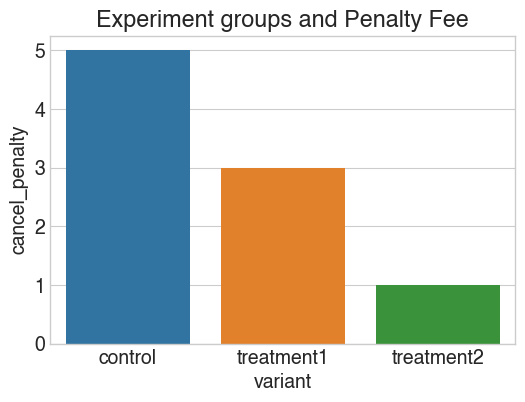

In [22]:
# count of differnt groups of exp variants and cancel_penalty 
plt.figure(figsize=(6,4))
sns.barplot(data=df_exp, x='variant', y='cancel_penalty')
plt.title("Experiment groups and Penalty Fee")

In [23]:
# count the number of samples in each group
df_exp['variant'].value_counts()

treatment2    177000
treatment1    176900
control       176856
Name: variant, dtype: int64

Each group has similar sample size

### ride_data
- check null
- check outlier
- check data type

In [24]:
df_ride.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1402312 entries, 0 to 1402311
Data columns (total 16 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   ride_id                  1402312 non-null  object 
 1   rider_id                 1402312 non-null  object 
 2   driver_id                1367819 non-null  object 
 3   ride_type                1402312 non-null  object 
 4   upfront_fare             1397335 non-null  float64
 5   rider_paid_amount        1402312 non-null  float64
 6   eta_to_rider_pre_match   1334909 non-null  float64
 7   eta_to_rider_post_match  1367790 non-null  float64
 8   requested_at_local       1402312 non-null  object 
 9   accepted_at_local        1367790 non-null  object 
 10  arrived_at_local         1193519 non-null  object 
 11  picked_up_at_local       1193511 non-null  object 
 12  dropped_off_at_local     1193487 non-null  object 
 13  actual_time_to_arrival   1193491 non-null 

In [25]:
# Timestamp formatting
# remove country and city names and change the type to datetime
timestamp_cols = ['requested_at_local', 'accepted_at_local','arrived_at_local', 'picked_up_at_local', 'dropped_off_at_local']
for col in timestamp_cols:
    df_ride[col] = df_ride[col].str.replace(r'[A-Za-z\_\/]+', '').str.strip()
    df_ride[col] = pd.to_datetime(df_ride[col])

In [26]:
# check format
df_ride.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1402312 entries, 0 to 1402311
Data columns (total 16 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   ride_id                  1402312 non-null  object        
 1   rider_id                 1402312 non-null  object        
 2   driver_id                1367819 non-null  object        
 3   ride_type                1402312 non-null  object        
 4   upfront_fare             1397335 non-null  float64       
 5   rider_paid_amount        1402312 non-null  float64       
 6   eta_to_rider_pre_match   1334909 non-null  float64       
 7   eta_to_rider_post_match  1367790 non-null  float64       
 8   requested_at_local       1402312 non-null  datetime64[ns]
 9   accepted_at_local        1367790 non-null  datetime64[ns]
 10  arrived_at_local         1193519 non-null  datetime64[ns]
 11  picked_up_at_local       1193511 non-null  datetime64[ns]
 12  

## EDA and Feature Engineering

In [27]:
# check outlier of ride_paid_amount and ride

In [28]:
# columns with null
df_ride.isnull().sum()

ride_id                         0
rider_id                        0
driver_id                   34493
ride_type                       0
upfront_fare                 4977
rider_paid_amount               0
eta_to_rider_pre_match      67403
eta_to_rider_post_match     34522
requested_at_local              0
accepted_at_local           34522
arrived_at_local           208793
picked_up_at_local         208801
dropped_off_at_local       208825
actual_time_to_arrival     208821
cancellation_flag               0
rider_request_number            0
dtype: int64

We want to find out the null values relating to cancellation flags

(i.e. When were rides being cancelled? Who cancelled it?)

- driver_id (cancelled before matched)
- upfront_fare (without upfront fare causes cancellation?)
- eta_to_rider_pre_match ()
- eta_to_rider_post_match (do riders cancel because of long eta pre match?)
- accepted_at_local (=eta_to_rider_post_match, riders drop
- arrived_at_local ~ picked_up_at_local ~ dropped_off_at_local ~ actual_time_to_arrival
    - all very similar, ride funnel's downstream, when ride is cancelled after 'accepted_at' and before 'arrived_at'***
        => This hurt the business the most, hurt driver satisfactions


In [29]:
# total count of cancellation
total_cancel = df_ride['cancellation_flag'].sum()
print(f"Total cancellation count: {total_cancel:,}")

# df filter for cancelled ride
cancel_filter = df_ride['cancellation_flag']==1

Total cancellation count: 207,050


In [30]:
total_uncancelled = df_ride['ride_id'].count() - total_cancel
total_count = df_ride['ride_id'].count()
total_cancel


207050

Text(0.5, 0, 'Cancellation Flag')

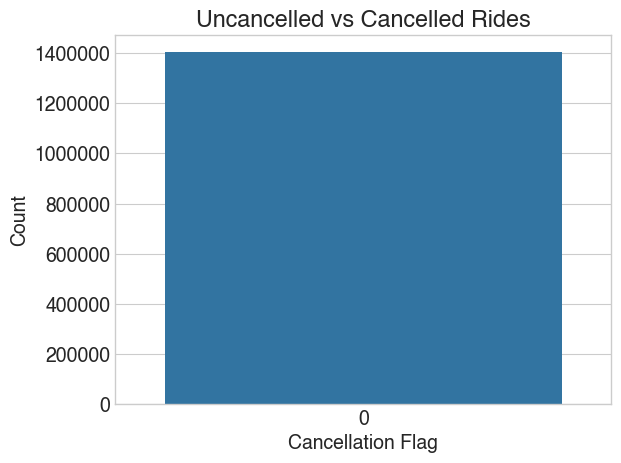

In [31]:
# plot cancel vs uncancelled 

sns.countplot(df_ride['cancellation_flag'])
plt.ticklabel_format(style='plain', axis='y')
plt.title("Uncancelled vs Cancelled Rides")
plt.ylabel("Count")
plt.xlabel("Cancellation Flag")

Text(0.5, 1.0, 'Uncancelled vs Cancelled ride')

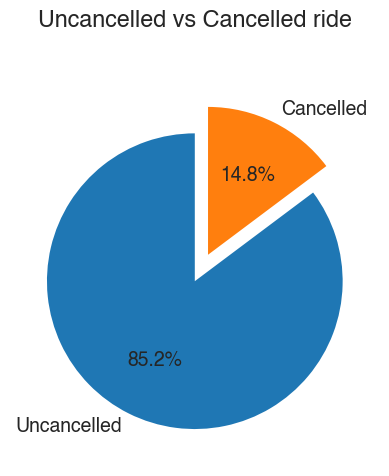

In [32]:
sizes = [total_uncancelled, total_cancel]
labels = ['Uncancelled', 'Cancelled']
explode = [0, 0.2]

plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Uncancelled vs Cancelled ride", pad=50)

In [33]:
# experiment time and ride request duration 
print(f"start:", df_ride['requested_at_local'].min(), "| end:", df_ride['dropped_off_at_local'].max())
print(f"Duration : {df_ride['dropped_off_at_local'].max() - df_ride['requested_at_local'].min()}")

start: 2019-04-14 17:00:01 | end: 2019-05-26 18:46:14
Duration : 42 days 01:46:13


The dataset timeframe is between 2019-04-14 and 2019-05-26

### Cancellation Stage

Cancel at:
1. Before matched
2. After accepted 

Assumption:
- If cancellation_flag == 1 and driver_id is null, assume the rides were cancelled before matched
- Rides that were cancelled after accepted by drivers are the most undesirable => drivers unhappy

In [34]:
# driver_id vs cancellation_flag
# If cancellation_flag == 1 and driver_id is null, assume the rides were cancelled before matched
cancel_before_matched = df_ride[(cancel_filter) & (df_ride['driver_id'].isnull())]['ride_id'].count()
perc_cancel_before_matched = cancel_before_matched / total_cancel
print(f"The rides that were cancelled before matched: {cancel_before_matched:,}")
print(f"Percentage of cancelled before matched = {perc_cancel_before_matched*100:.3f}%")


The rides that were cancelled before matched: 32,751
Percentage of cancelled before matched = 15.818%


In [35]:
# create label for cancel_before_matched
df_ride['cancel_before_matched'] = 0
df_ride.loc[(cancel_filter) & (df_ride['driver_id'].isnull()), 'cancel_before_matched'] = 1

# df_ride.head()

In [36]:
# driver_id is null but ride not cancelled => Bugs => remove those record

no_driver_id_no_cancelled = df_ride[(df_ride['driver_id'].isnull()) & (~cancel_filter)]['ride_id']

In [37]:
# rides that were cancelled after accepted

df_ride[(cancel_filter) & (~df_ride['accepted_at_local'].isnull())].count()

ride_id                    174298
rider_id                   174298
driver_id                  174298
ride_type                  174298
upfront_fare               173714
rider_paid_amount          174298
eta_to_rider_pre_match     166522
eta_to_rider_post_match    174298
requested_at_local         174298
accepted_at_local          174298
arrived_at_local                0
picked_up_at_local              0
dropped_off_at_local            0
actual_time_to_arrival          0
cancellation_flag          174298
rider_request_number       174298
cancel_before_matched      174298
dtype: int64

In [38]:
# make sure no rides were cancelled after arrived_at 

df_ride[(cancel_filter) & (~df_ride['arrived_at_local'].isnull())]

Empty DataFrame
Columns: [ride_id, rider_id, driver_id, ride_type, upfront_fare, rider_paid_amount, eta_to_rider_pre_match, eta_to_rider_post_match, requested_at_local, accepted_at_local, arrived_at_local, picked_up_at_local, dropped_off_at_local, actual_time_to_arrival, cancellation_flag, rider_request_number, cancel_before_matched]
Index: []

In [39]:
# rides that were cancelled after accepted and percentage
df_ride[(cancel_filter) & (~df_ride['accepted_at_local'].isnull())]['ride_id'].count()

cancel_after_accepted = df_ride[(cancel_filter) & (~df_ride['accepted_at_local'].isnull())]['ride_id'].count()
perc_cancel_after_accepted = cancel_after_accepted / total_cancel
print(f"The rides that were cancelled after accepted: {cancel_after_accepted:,}")
print(f"Percentage of cancelled after accepted = {perc_cancel_after_accepted*100:.3f}%")

The rides that were cancelled after accepted: 174,298
Percentage of cancelled after accepted = 84.182%


Text(0.5, 1.0, 'Cancellation Before and After matched with driver Distribution')

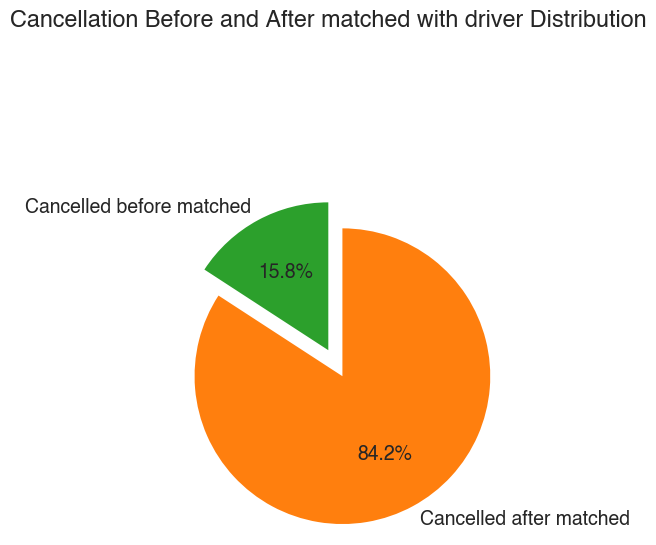

In [40]:
# pie chart for before and after matched cancellation
sizes = [cancel_before_matched, cancel_after_accepted]
labels = ['Cancelled before matched', 'Cancelled after matched']
explode = [0, 0.2]
colors=['tab:green', 'tab:orange']


plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("Cancellation Before and After matched with driver Distribution", pad=100)


In [41]:
# add cancel_after_matched label

df_ride['cancel_after_matched'] = 0
df_ride.loc[(cancel_filter) & (~df_ride['accepted_at_local'].isnull()), 'cancel_after_matched'] = 1

# df_ride.head()

Majority of the cancellations happened **after** the rides had been accepted by driver. These are harmful scenario that hurt The Company's driver supply potentially and financially.

### accepted_requested_gap
Find the time between accepted time and requested time. (accepted_requested_gap)

Assumption:
- The longer the gap, the more cancellation might find because rider is unsatisfied.

Are there drivers have longer gap => Average accepted_requested_gap_s comparison


In [42]:
df_ride['accepted_requested_gap'] = (df_ride['accepted_at_local'] - df_ride['requested_at_local']).dt.seconds
df_ride['accepted_requested_gap'].fillna(0, inplace=True)
# df_ride.head()

In [43]:
# driver average accepted request gap by average cancellation count
df_driver_gap_cancel = df_ride.groupby(['driver_id']).agg({'accepted_requested_gap': 'mean', 'cancellation_flag': 'mean'}).reset_index().sort_values(by=['cancellation_flag', 'accepted_requested_gap'], ascending=False)

plt.figure(figsize=(12,8))
sns.scatterplot(y=df_driver_gap_cancel['cancellation_flag'], x=df_driver_gap_cancel['accepted_requested_gap'], ci=False)
plt.title("Driver's average accepted requested gap by average cancellation count", fontsize=30)

Text(0.5, 1.0, "Driver's average accepted requested gap")

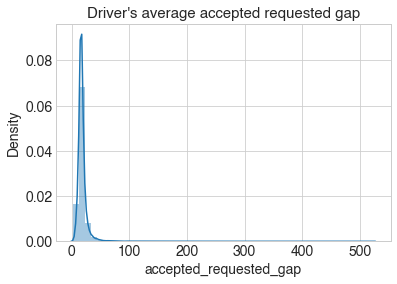

In [ ]:
# driver's average request gap
sns.distplot(a=df_driver_gap_cancel['accepted_requested_gap'])
plt.title("Driver's average accepted requested gap", fontsize=15)

In [ ]:
print(f"Average accepted requested gap per driver : {df_driver_gap_cancel['accepted_requested_gap'].mean():.1f} seconds")

Average accepted requested gap per driver : 18.4 seconds


Per driver, average accepted_requested_gap per driver don't seem to affect their rides being cancelled

Let's look at per riders, will this affect the rider_request_number?

In [ ]:
# maximum request per rider
max_rider_request = df_ride.groupby('rider_id')['rider_request_number'].max().reset_index().sort_values('rider_request_number', ascending=False)
max_rider_request.head()

rider_id  rider_request_number
470993  slnsaVpV1+N6m6tiOFOvDQ==                   107
221743  Ojdflb45wpmD5B31JRQFMg==                    91
151494  GGsWWNPAJcdLpzvOwOq5ng==                    86
431902  o2tPXTJl7DcV4FoAR+0T2g==                    85
77438   7No0Gd60A6h1A+DtX46L8g==                    84
...                          ...                   ...
329226  bfXKgmndVj+M9Lahy8v9nA==                     1
329227  bfXcV5m6wNsW2ilDqgBE0g==                     1
329228  bfY6tPjOBt5ERnD40t58AQ==                     1
139185  Eo8V/tx4jxfVr4QhT/QCKg==                     1
0       +++3990cLNPGgaPm+ripGg==                     1

[530756 rows x 2 columns]

In [ ]:
# mean of max rider requests
print("Average ride requests per rider: ", max_rider_request['rider_request_number'].mean())

Average ride requests per rider:  2.6421029625666033


Text(0.5, 1.0, 'Total Request Number per rider')

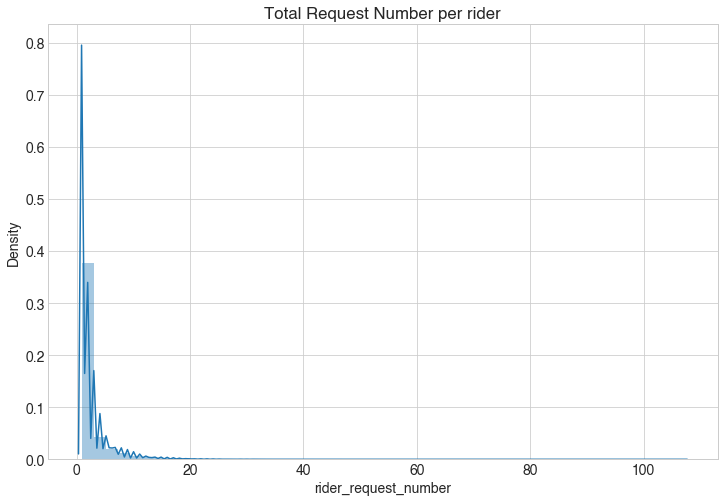

In [ ]:
plt.figure(figsize=(12,8))
sns.distplot(max_rider_request['rider_request_number'])
plt.title("Total Request Number per rider")

Data is really skewed to the right. 
Most of the riders only request ~2 rides throughout the period of experiment, then they churn. Not a good sign.

We want to know if the number of request drop with cancellation count per rider

In [ ]:
# total cancelation per rider
total_rider_cancel = df_ride.groupby('rider_id')['cancellation_flag'].sum().reset_index().sort_values('cancellation_flag', ascending=False)
total_rider_cancel.head()

rider_id  cancellation_flag
221743  Ojdflb45wpmD5B31JRQFMg==                 88
431902  o2tPXTJl7DcV4FoAR+0T2g==                 80
77438   7No0Gd60A6h1A+DtX46L8g==                 77
151494  GGsWWNPAJcdLpzvOwOq5ng==                 72
271119  UgKwzAxk4uuY1hwx9AhOgA==                 70
...                          ...                ...
198656  LyasuPPJO7/ZK1rWyPjlyQ==                  0
198655  LyadFfCwEm4Cm5PTFcRWUA==                  0
198653  LyaRTWdkxjw4lgkgg3UJuA==                  0
198652  LyaMNYbV6YvR09qk+mEodg==                  0
530755  zzzhpNF1l7HdwyBef3huRw==                  0

[530756 rows x 2 columns]

Text(0.5, 1.0, 'Total Cancellation per rider')

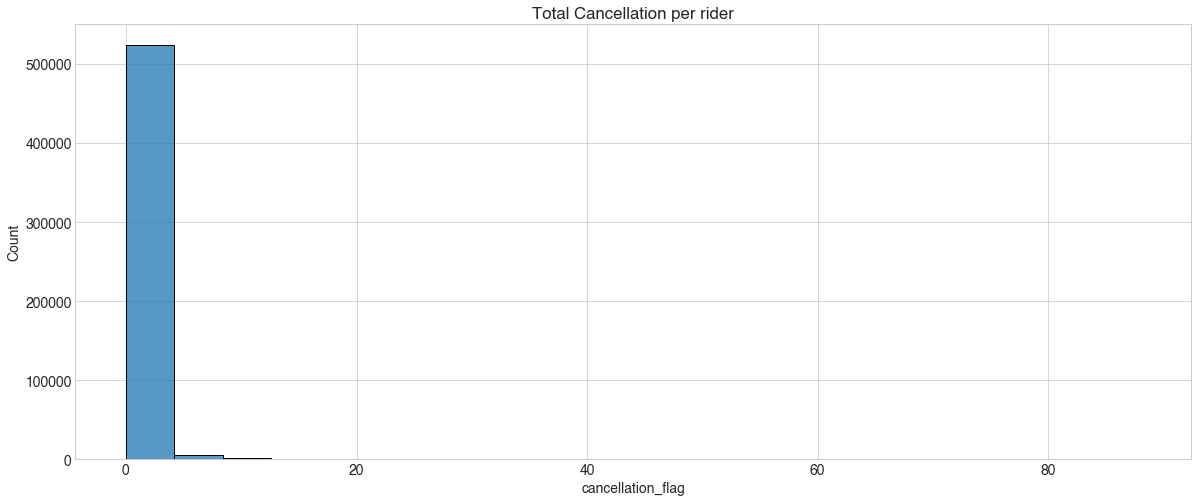

In [ ]:
# total cancellation per rider
plt.figure(figsize=(20,8))
sns.histplot(x=total_rider_cancel['cancellation_flag'])
plt.title("Total Cancellation per rider")

Cancellation and Request ride have similar distribution.

#### A lot of riders cancelled 1-2 times and never come back to use The Company service

In [ ]:
# per rider, request and cancel
df_rider_request_cancel = df_ride.groupby('rider_id').agg({'rider_request_number': 'max', 'cancellation_flag': 'sum'}).reset_index().sort_values('rider_request_number', ascending=False)
df_rider_request_cancel.head()

rider_id  rider_request_number  cancellation_flag
470993  slnsaVpV1+N6m6tiOFOvDQ==                   107                 55
221743  Ojdflb45wpmD5B31JRQFMg==                    91                 88
151494  GGsWWNPAJcdLpzvOwOq5ng==                    86                 72
431902  o2tPXTJl7DcV4FoAR+0T2g==                    85                 80
77438   7No0Gd60A6h1A+DtX46L8g==                    84                 77
...                          ...                   ...                ...
329226  bfXKgmndVj+M9Lahy8v9nA==                     1                  0
329227  bfXcV5m6wNsW2ilDqgBE0g==                     1                  0
329228  bfY6tPjOBt5ERnD40t58AQ==                     1                  0
139185  Eo8V/tx4jxfVr4QhT/QCKg==                     1                  0
0       +++3990cLNPGgaPm+ripGg==                     1                  0

[530756 rows x 3 columns]

Text(0.5, 1.0, 'Cancellation count over total ride Request per rider')

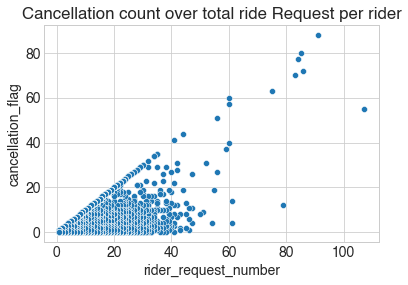

In [ ]:
sns.scatterplot(x=df_rider_request_cancel['rider_request_number'], y=df_rider_request_cancel['cancellation_flag'])
plt.title("Cancellation count over total ride Request per rider")

### Revenue per ride

In [ ]:
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530756 entries, 0 to 530755
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   rider_id        530756 non-null  object 
 1   variant         530756 non-null  object 
 2   cancel_penalty  530756 non-null  float64
dtypes: float64(1), object(2)
memory usage: 12.1+ MB


In [ ]:
df_ride['rider_id'].nunique()

530756

In [ ]:
df_ride.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1402312 entries, 0 to 1402311
Data columns (total 19 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   ride_id                  1402312 non-null  object        
 1   rider_id                 1402312 non-null  object        
 2   driver_id                1367819 non-null  object        
 3   ride_type                1402312 non-null  object        
 4   upfront_fare             1397335 non-null  float64       
 5   rider_paid_amount        1402312 non-null  float64       
 6   eta_to_rider_pre_match   1334909 non-null  float64       
 7   eta_to_rider_post_match  1367790 non-null  float64       
 8   requested_at_local       1402312 non-null  datetime64[ns]
 9   accepted_at_local        1367790 non-null  datetime64[ns]
 10  arrived_at_local         1193519 non-null  datetime64[ns]
 11  picked_up_at_local       1193511 non-null  datetime64[ns]
 12  

In [ ]:
df_ride_exp = df_ride.merge(df_exp, on='rider_id', how='left')

ride_id                  rider_id  \
0        KCMXI4HAfLCjgHFR2qA1Lg==  AKTYnqStIa+/suWRUAQ60g==   
1        ERylrc+OvEb4gm84MxYmWQ==  ARxb2lRoxbrEgQgDEJIr7Q==   
2        FKVvDcTRe0O1TDpg6uzLgQ==  ARxb2lRoxbrEgQgDEJIr7Q==   
3        ELtwBfng4uSyXpBseav1Bg==  AeWaFFe6cKFmfTEnEr6QBQ==   
4        OmCaoDxSXwN3nJzg8Jwamw==  Au8G9PfP3KN3SUnTPO+mMQ==   
...                           ...                       ...   
1402307  IPf/q4W/SfYpZwTB3N3p+Q==  rxGlxQPBtfYg+5J/TSMSLA==   
1402308  F81h0Nj5BxIlbXg1c7GhsA==  rz4dDikG4QUdBEpUHvJPZg==   
1402309  Pf3mRHMKNcBSdkacic/0iQ==  rz4dDikG4QUdBEpUHvJPZg==   
1402310  CfbL0FItw3nlubVYkY7EvQ==  sfpq0oCOtW4d3a1eMHb1SA==   
1402311  PvqhTtoJpjZ4G/xUM1ep0w==  swdPaR+r2nqDlmvY0SCvNg==   

                        driver_id ride_type  upfront_fare  rider_paid_amount  \
0        c5U+DL4S+9Kd8xs0jW3ADg==  standard         12.13              17.40   
1                             NaN  standard         77.76               1.00   
2        HBzAE1FuAnArUgou7Qetow==  standard          7.82               8.17   
3        MX3XhXFZAjKpEDIRm5QoMg==  standard         14.76              14.82   
4        lqj+gQA7gRITBlHwTCM8Rg==  standard         18.05              17.78   
...                           ...       ...           ...                ...   
1402307                       NaN    shared          6.24               3.00   
1402308  /cdKsf0W2DXnkfsDE6Th0A==  standard          8.45               3.00   
1402309                       NaN  standard         28.64               3.00   
1402310  wDzf5nFZ0B1EEq0DDv6CQA==  standard         10.99              10.98   
1402311  JZvHTl+ude9ZtqYRNyzU+A==  standard         14.28              21.33   

         eta_to_rider_pre_match  eta_to_rider_post_match  requested_at_local  \
0                          60.0                     21.0 2019-05-04 14:08:33   
1                          60.0                      NaN 2019-05-03 15:26:37   
2                         360.0                    541.0 2019-05-10 19:26:29   
3                          60.0                    126.0 2019-05-10 23:39:07   
4                         360.0                    587.0 2019-05-08 13:52:08   
...                         ...                      ...                 ...   
1402307                     NaN                      NaN 2019-05-16 09:16:07   
1402308                    60.0                    105.0 2019-04-22 21:04:48   
1402309                     NaN                      NaN 2019-05-08 16:30:01   
1402310                   660.0                    704.0 2019-05-19 03:04:07   
1402311                   121.0                    210.0 2019-05-03 10:28:04   

              accepted_at_local  ...  picked_up_at_local dropped_off_at_local  \
0       2019-05-04 14:08:43.775  ... 2019-05-04 14:10:02  2019-05-04 14:22:34   
1                           NaT  ...                 NaT                  NaT   
2       2019-05-10 19:27:00.632  ... 2019-05-10 19:37:24  2019-05-10 19:44:22   
3       2019-05-10 23:39:32.725  ... 2019-05-10 23:42:28  2019-05-11 00:02:06   
4       2019-05-08 13:53:24.871  ... 2019-05-08 14:03:39  2019-05-08 14:18:35   
...                         ...  ...                 ...                  ...   
1402307                     NaT  ...                 NaT                  NaT   
1402308 2019-04-22 21:04:55.271  ...                 NaT                  NaT   
1402309                     NaT  ...                 NaT                  NaT   
1402310 2019-05-19 03:04:25.861  ... 2019-05-19 03:16:03  2019-05-19 03:25:17   
1402311 2019-05-03 10:28:13.298  ... 2019-05-03 10:32:55  2019-05-03 10:47:36   

        actual_time_to_arrival  cancellation_flag  rider_request_number  \
0                         37.0                  0                     1   
1                          NaN                  1                     1   
2                        621.0                  0                     2   
3                        171.0                  0                     1   

## Matching and ETA calculation Algo
    - Eta pre vs post match
    - Actual time arrival vs post match


In [ ]:
# Eta pre vs post match
# eta_to_rider_post_match - eta_to_rider_pre_match
# => higher => higher chance to cancel after match?

df_ride_exp['post_pre_match_gap'] = df_ride_exp['eta_to_rider_post_match'] - df_ride_exp['eta_to_rider_pre_match']

ride_id                  rider_id  \
0  KCMXI4HAfLCjgHFR2qA1Lg==  AKTYnqStIa+/suWRUAQ60g==   
1  ERylrc+OvEb4gm84MxYmWQ==  ARxb2lRoxbrEgQgDEJIr7Q==   
2  FKVvDcTRe0O1TDpg6uzLgQ==  ARxb2lRoxbrEgQgDEJIr7Q==   
3  ELtwBfng4uSyXpBseav1Bg==  AeWaFFe6cKFmfTEnEr6QBQ==   
4  OmCaoDxSXwN3nJzg8Jwamw==  Au8G9PfP3KN3SUnTPO+mMQ==   

                  driver_id ride_type  upfront_fare  rider_paid_amount  \
0  c5U+DL4S+9Kd8xs0jW3ADg==  standard         12.13              17.40   
1                       NaN  standard         77.76               1.00   
2  HBzAE1FuAnArUgou7Qetow==  standard          7.82               8.17   
3  MX3XhXFZAjKpEDIRm5QoMg==  standard         14.76              14.82   
4  lqj+gQA7gRITBlHwTCM8Rg==  standard         18.05              17.78   

   eta_to_rider_pre_match  eta_to_rider_post_match  requested_at_local  \
0                    60.0                     21.0 2019-05-04 14:08:33   
1                    60.0                      NaN 2019-05-03 15:26:37   
2                   360.0                    541.0 2019-05-10 19:26:29   
3                    60.0                    126.0 2019-05-10 23:39:07   
4                   360.0                    587.0 2019-05-08 13:52:08   

        accepted_at_local  ... dropped_off_at_local actual_time_to_arrival  \
0 2019-05-04 14:08:43.775  ...  2019-05-04 14:22:34                   37.0   
1                     NaT  ...                  NaT                    NaN   
2 2019-05-10 19:27:00.632  ...  2019-05-10 19:44:22                  621.0   
3 2019-05-10 23:39:32.725  ...  2019-05-11 00:02:06                  171.0   
4 2019-05-08 13:53:24.871  ...  2019-05-08 14:18:35                  610.0   

  cancellation_flag  rider_request_number  cancel_before_matched  \
0                 0                     1                      0   
1                 1                     1                      1   
2                 0                     2                      0   
3                 0                     1                      0   
4                 0                     1                      0   

   cancel_after_matched  accepted_requested_gap     variant  cancel_penalty  \
0                     0                    10.0  treatment1             3.0   
1                     0                     0.0  treatment2             1.0   
2                     0                    31.0  treatment2             1.0   
3                     0                    25.0  treatment2             1.0   
4                     0                    76.0  treatment2             1.0   

  post_pre_match_gap  
0              -39.0  
1                NaN  
2              181.0  
3               66.0  
4              227.0  

[5 rows x 22 columns]

In [ ]:
print(f"Average time between Post match and pre match time ETA: {df_ride_exp['post_pre_match_gap'].mean():.1f} seconds")

Average time between Post match and pre match time ETA: 4.0 seconds


Text(0.5, 1.0, 'Time Difference between Post match and pre match time ETA (seconds)')

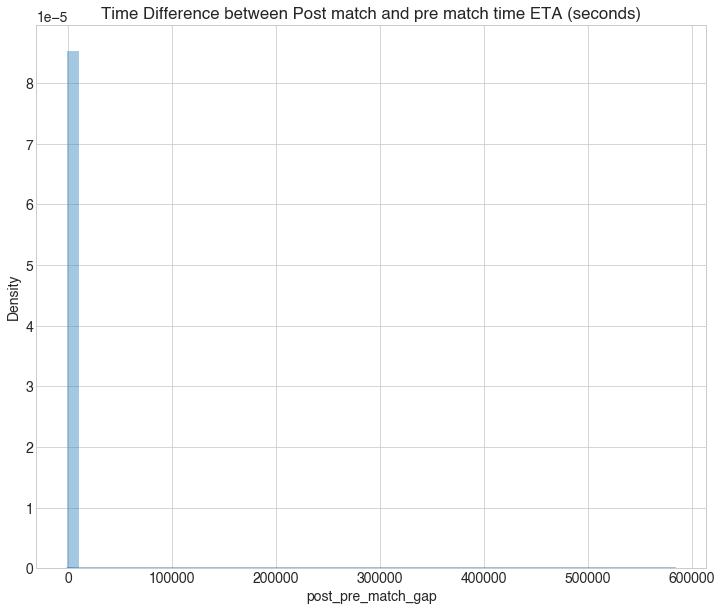

In [ ]:
plt.figure(figsize=(12,10))
sns.distplot(df_ride_exp['post_pre_match_gap'])
plt.title("Time Difference between Post match and pre match time ETA (seconds)")

In [ ]:
#Actual time arrival vs post match
# actual_time_to_arrival - eta_to_rider_post_match
# => algo problem? => predict if it will cancellation

df_ride_exp['actual_post_match_gap'] = df_ride_exp['actual_time_to_arrival'] - df_ride_exp['eta_to_rider_post_match']

ride_id                  rider_id  \
0  KCMXI4HAfLCjgHFR2qA1Lg==  AKTYnqStIa+/suWRUAQ60g==   
1  ERylrc+OvEb4gm84MxYmWQ==  ARxb2lRoxbrEgQgDEJIr7Q==   
2  FKVvDcTRe0O1TDpg6uzLgQ==  ARxb2lRoxbrEgQgDEJIr7Q==   
3  ELtwBfng4uSyXpBseav1Bg==  AeWaFFe6cKFmfTEnEr6QBQ==   
4  OmCaoDxSXwN3nJzg8Jwamw==  Au8G9PfP3KN3SUnTPO+mMQ==   

                  driver_id ride_type  upfront_fare  rider_paid_amount  \
0  c5U+DL4S+9Kd8xs0jW3ADg==  standard         12.13              17.40   
1                       NaN  standard         77.76               1.00   
2  HBzAE1FuAnArUgou7Qetow==  standard          7.82               8.17   
3  MX3XhXFZAjKpEDIRm5QoMg==  standard         14.76              14.82   
4  lqj+gQA7gRITBlHwTCM8Rg==  standard         18.05              17.78   

   eta_to_rider_pre_match  eta_to_rider_post_match  requested_at_local  \
0                    60.0                     21.0 2019-05-04 14:08:33   
1                    60.0                      NaN 2019-05-03 15:26:37   
2                   360.0                    541.0 2019-05-10 19:26:29   
3                    60.0                    126.0 2019-05-10 23:39:07   
4                   360.0                    587.0 2019-05-08 13:52:08   

        accepted_at_local  ... actual_time_to_arrival cancellation_flag  \
0 2019-05-04 14:08:43.775  ...                   37.0                 0   
1                     NaT  ...                    NaN                 1   
2 2019-05-10 19:27:00.632  ...                  621.0                 0   
3 2019-05-10 23:39:32.725  ...                  171.0                 0   
4 2019-05-08 13:53:24.871  ...                  610.0                 0   

  rider_request_number  cancel_before_matched  cancel_after_matched  \
0                    1                      0                     0   
1                    1                      1                     0   
2                    2                      0                     0   
3                    1                      0                     0   
4                    1                      0                     0   

   accepted_requested_gap     variant  cancel_penalty  post_pre_match_gap  \
0                    10.0  treatment1             3.0               -39.0   
1                     0.0  treatment2             1.0                 NaN   
2                    31.0  treatment2             1.0               181.0   
3                    25.0  treatment2             1.0                66.0   
4                    76.0  treatment2             1.0               227.0   

  actual_post_match_gap  
0                  16.0  
1                   NaN  
2                  80.0  
3                  45.0  
4                  23.0  

[5 rows x 23 columns]

In [ ]:
# df_ride_exp['actual_post_match_gap'].sort_values(ascending=False)
# df_ride_exp.sort_values(by=['actual_post_match_gap'], ascending=False)

ride_id                  rider_id  \
631405   K32/rmzvLNH/Gn6n7FHnsA==  efDomOH0oEkQuoyjoYv84w==   
398296   HN/26DU1EXMLZ8i1S3GU/Q==  Zg3Bb6/f0D9o4yBX1o3CCw==   
516631   NdkI5rjOkz+xkyxrL/DL6w==  CnzWaEo9IepcHzKFydyYMQ==   
1146188  GYgOGLZS0p7uuR+L6H/1vA==  Fq3GlrFl144GgyMqhgXQ6A==   
750798   P3bSxgfs9/o/Lr3xT1RUwg==  mghXCZAkZWK7pA+k1NOV1A==   
...                           ...                       ...   
1402305  LgigGI3+nOdyOgbAeGtrqA==  rxGlxQPBtfYg+5J/TSMSLA==   
1402306  C38Z309Q7tQhf1lYv/jNvA==  rxGlxQPBtfYg+5J/TSMSLA==   
1402307  IPf/q4W/SfYpZwTB3N3p+Q==  rxGlxQPBtfYg+5J/TSMSLA==   
1402308  F81h0Nj5BxIlbXg1c7GhsA==  rz4dDikG4QUdBEpUHvJPZg==   
1402309  Pf3mRHMKNcBSdkacic/0iQ==  rz4dDikG4QUdBEpUHvJPZg==   

                        driver_id ride_type  upfront_fare  rider_paid_amount  \
631405   aX6gZ/2iipJTwP4s11numw==  standard         29.42              29.22   
398296   O7leDQh+19VL4cFAemryOA==    shared          4.29               4.28   
516631   tT/jhBHbszTFWFVx71m8IA==    shared         14.96              14.99   
1146188  GxzOOeJjH9U89Ty+Hb54KQ==    shared          7.24               7.18   
750798   MtjO2+/4oJfipNl8CtVw5Q==    shared          6.29               6.18   
...                           ...       ...           ...                ...   
1402305                       NaN    shared         13.16               3.00   
1402306                       NaN    shared         14.99               3.00   
1402307                       NaN    shared          6.24               3.00   
1402308  /cdKsf0W2DXnkfsDE6Th0A==  standard          8.45               3.00   
1402309                       NaN  standard         28.64               3.00   

         eta_to_rider_pre_match  eta_to_rider_post_match  requested_at_local  \
631405                    480.0                    567.0 2019-05-13 16:36:15   
398296                    245.0                    327.0 2019-05-13 16:48:32   
516631                    449.0                    243.0 2019-04-21 12:30:08   
1146188                   631.0                    767.0 2019-05-13 16:40:48   
750798                    353.0                    199.0 2019-05-13 16:46:20   
...                         ...                      ...                 ...   
1402305                     NaN                      NaN 2019-04-30 15:16:00   
1402306                     NaN                      NaN 2019-04-30 20:06:16   
1402307                     NaN                      NaN 2019-05-16 09:16:07   
1402308                    60.0                    105.0 2019-04-22 21:04:48   
1402309                     NaN                      NaN 2019-05-08 16:30:01   

              accepted_at_local  ... actual_time_to_arrival cancellation_flag  \
631405  2019-05-13 16:36:25.629  ...                 7036.0                 0   
398296  2019-05-13 16:48:39.191  ...                 6618.0                 0   
516631  2019-04-21 12:30:24.295  ...                 4636.0                 0   
1146188 2019-05-13 16:41:47.544  ...                 4820.0                 0   
750798  2019-05-13 16:46:40.845  ...                 4007.0                 0   
...                         ...  ...                    ...               ...   
1402305                     NaT  ...                    NaN                 1   
1402306                     NaT  ...                    NaN                 1   
1402307                     NaT  ...                    NaN                 1   
1402308 2019-04-22 21:04:55.271  ...                    NaN                 1   
1402309                     NaT  ...                    NaN                 1   

        rider_request_number  cancel_before_matched  cancel_after_matched  \
631405                     1                      0                     0   
398296                     2                      0                     0   
516631                     2                      0                     0   
1146188                    8                      0               

In [ ]:
print(f"Average time between actual arrival and post match time ETA: {df_ride_exp['actual_post_match_gap'].mean():.1f} seconds")

Average time between actual arrival and post match time ETA: 18.8 seconds


Text(0.5, 1.0, 'Actual arrival and post match time difference (seconds)')

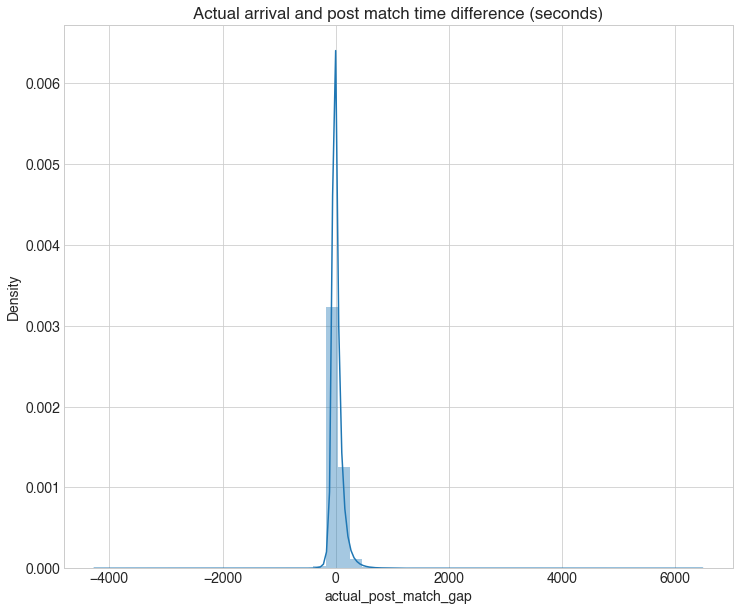

In [ ]:
plt.figure(figsize=(12,10))
sns.distplot(df_ride_exp['actual_post_match_gap'])
plt.title("Actual arrival and post match time difference (seconds)")

Normal distribution


## Riders
    - Total ride count per rider
    - Main Ride type (Shared ride, Normal ride)
    - Consistent riders / Short term riders?
    - Cancellation high consistently?
    - Mistakenly Cancel? (Request again very quickly e.g within 5min)



#### Total ride count per rider

In [ ]:
df_rider_count_g = df_ride_exp.groupby('rider_id')['ride_id'].count().reset_index().rename(columns={'ride_id': 'ride_count'}).sort_values(by='ride_count', ascending=False)
df_rider_count_g.head()

rider_id  ride_count
470993  slnsaVpV1+N6m6tiOFOvDQ==         107
221743  Ojdflb45wpmD5B31JRQFMg==          91
151494  GGsWWNPAJcdLpzvOwOq5ng==          86
431902  o2tPXTJl7DcV4FoAR+0T2g==          85
77438   7No0Gd60A6h1A+DtX46L8g==          84
...                          ...         ...
329226  bfXKgmndVj+M9Lahy8v9nA==           1
329227  bfXcV5m6wNsW2ilDqgBE0g==           1
329228  bfY6tPjOBt5ERnD40t58AQ==           1
139185  Eo8V/tx4jxfVr4QhT/QCKg==           1
0       +++3990cLNPGgaPm+ripGg==           1

[530756 rows x 2 columns]

#### Main Ride type (Shared ride, Normal ride)


In [ ]:
ride_type = df_ride_exp['ride_type'].value_counts()
ride_type

standard    923114
shared      479198
Name: ride_type, dtype: int64

Text(0, 0.5, 'count')

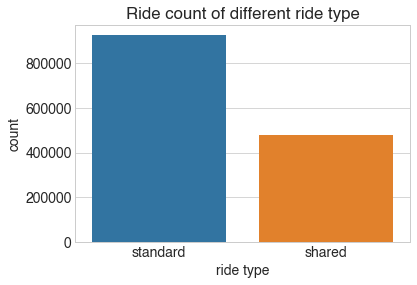

In [ ]:

sns.barplot(x=ride_type.index, y=ride_type.values)
plt.title("Ride count of different ride type")
plt.xlabel("ride type")
plt.ylabel("count")

around 1:2 for standard vs shared type ride count

In [ ]:
# create label "is_standard_type" : 1 is standard, 0 is shared
df_ride_exp['is_standard_type'] = 0
df_ride_exp.loc[df_ride_exp['ride_type']=='standard', 'is_standard_type'] = 1

In [ ]:
# group by riders
# is_standard_type = 1 => only take standard ride, 0 : only take shared ride
df_rider_standard_g = df_ride_exp.groupby('rider_id')['is_standard_type'].mean().sort_values(ascending=False).reset_index()
df_rider_standard_g.describe()

is_standard_type
count     530756.000000
mean           0.723412
std            0.410508
min            0.000000
25%            0.400000
50%            1.000000
75%            1.000000
max            1.000000

#### Regular / Frequent riders
- weekly ride count, if rider has at least 2 uncancelled rides per week and at least 10 rides within the whole 6 weeks timeframe => frequent riders

assumption:
- regular riders won't cancel easily, good riders to keep.

In [ ]:
# create week of year columns
df_ride_exp['requested_week'] = df_ride_exp['requested_at_local'].dt.isocalendar().week

# only count the rides that's not cancelled and only $5 penalty
df_ride_success = df_ride_exp[(df_ride_exp['cancellation_flag'] == 0)]

df_rider_week_count = df_ride_success.groupby(['rider_id', 'requested_week'])['ride_id'].count().reset_index().sort_values(by='ride_id').rename(columns={'ride_id': 'weekly_ride_count'})


# get riders that have weekly ride count >= 2 
two_weekly_ride_count_filter = df_rider_week_count['weekly_ride_count'] >= 2
two_weekly_ride_riders = df_rider_week_count[two_weekly_ride_count_filter]['rider_id']
two_weekly_ride_riders

# get riders that have at least 10 rides in total
rider_count = df_ride_exp.groupby('rider_id')['ride_id'].count().reset_index()
atleast_10_rides_filter = rider_count['ride_id'] > 10

atleast_10_rides_riders = rider_count[atleast_10_rides_filter]['rider_id']

regular_riders = pd.Series(list(set(two_weekly_ride_riders).intersection(set(atleast_10_rides_riders))))

0        8K9rtkeDaxNZC9W3hnQy8A==
1        xKVkyU9kTOfcQyeT14pWIQ==
2        TroqIxxpJ6O2Gf3HEGvEsw==
3        XexS0IYWBRowfInAhHncIg==
4        V1FTz6bA/tv3HSaeI2jGsQ==
                   ...           
16226    jdyBFUJ6bRA8lIVEPEG3rg==
16227    9hAG4OOX334uNlTERfZ/1w==
16228    LZrxtiAQveNxBKq16/+mNQ==
16229    YmC3K7Sd6Owwn7RtwvEXqQ==
16230    af9cMkf31vhd9/yVlips1Q==
Length: 16231, dtype: object

In [ ]:
frequent_riders_count = regular_riders.nunique()
print(f"Frequent riders count: {frequent_riders_count:,}")

Frequent riders count: 16,231


In [ ]:
unique_rider_number = df_ride_exp['rider_id'].nunique()
unique_rider_number


530756

In [ ]:
normal_rider_number = unique_rider_number - frequent_riders_count
normal_rider_number

514525

Text(0.5, 1.0, 'Typical Rider vs Frequent/ Regular Rider')

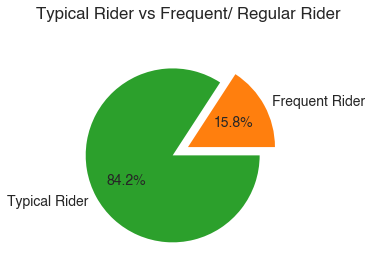

In [ ]:
# plot frequent / regular rider
labels=['Frequent Rider', 'Typical Rider']
size=[normal_rider_number, frequent_riders_count]

plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', colors=['tab:orange', 'tab:green'])
plt.title("Typical Rider vs Frequent/ Regular Rider", pad=20)

In [ ]:
# make label is_regular_rider
df_ride_exp['is_regular_rider'] = 0
df_ride_exp.loc[df_ride_exp['rider_id'].isin(regular_riders), 'is_regular_rider'] = 1

In [ ]:
df_rider_count_g.head()

rider_id  ride_count
470993  slnsaVpV1+N6m6tiOFOvDQ==         107
221743  Ojdflb45wpmD5B31JRQFMg==          91
151494  GGsWWNPAJcdLpzvOwOq5ng==          86
431902  o2tPXTJl7DcV4FoAR+0T2g==          85
77438   7No0Gd60A6h1A+DtX46L8g==          84
...                          ...         ...
329226  bfXKgmndVj+M9Lahy8v9nA==           1
329227  bfXcV5m6wNsW2ilDqgBE0g==           1
329228  bfY6tPjOBt5ERnD40t58AQ==           1
139185  Eo8V/tx4jxfVr4QhT/QCKg==           1
0       +++3990cLNPGgaPm+ripGg==           1

[530756 rows x 2 columns]

#### Cancelled but quickly re-requested

Riders who had Requested again very quickly  might mean a mistaken cancellation

Assumption:
- request back to back within 5min, the first ride is_cancel_mistake


In [ ]:
df_ride_exp.groupby('rider_id')

In [ ]:
# get consecutive requested time of a rider
# sort df by rider_id
df_ride_exp.sort_values(by=['rider_id', 'rider_request_number'], inplace=True)
# find rider requested gap 
df_ride_exp['rider_requested_gap'] = df_ride_exp['requested_at_local'] - df_ride_exp.groupby('rider_id')['requested_at_local'].shift()
df_ride_gap_cancel = df_ride_exp[['ride_id', 'rider_id', 'requested_at_local', 'rider_requested_gap', 'cancellation_flag']].sort_values(by=['rider_id', 'requested_at_local'])

df_ride_gap_cancel['rider_requested_gap'] = df_ride_gap_cancel['rider_requested_gap'].apply(lambda x: x.total_seconds())

# shift rider_requestd
df_ride_gap_cancel['rider_requested_gap_next'] = df_ride_gap_cancel.sort_values(by='requested_at_local').groupby('rider_id')['rider_requested_gap'].shift(-1)
df_ride_gap_cancel['cancellation_flag_next'] = df_ride_gap_cancel.sort_values(by='requested_at_local').groupby('rider_id')['cancellation_flag'].shift(-1)

# if rider_requested_gap_next <= 300 (i.e. 5 min) AND cancellation_flag == 1
df_ride_gap_cancel['is_quick_rerequested_cancel'] = 0

df_ride_gap_cancel.loc[(df_ride_gap_cancel['rider_requested_gap_next'] <= 300) & (df_ride_gap_cancel['cancellation_flag'] == 1), 'is_quick_rerequested_cancel'] = 1

df_ride_gap_cancel.sort_values(by=['rider_id', 'requested_at_local']).head()


ride_id                  rider_id  \
265252   I9+8q9h67J5XL7x+X2flrA==  +++3990cLNPGgaPm+ripGg==   
855751   FcDOAnNo5aTeYKG1iTyxSA==  +++stf7DqWcT8LMTYbXrwA==   
1083825  JwACfbilNJG1WIH5meqY/A==  ++07zTPYFhvA5Ug72kRd0w==   
1083826  MXUBhCnXvV4tiimvuSuP1g==  ++07zTPYFhvA5Ug72kRd0w==   
1337935  LyL81zlkrtWgRju0jZgFpQ==  ++08hetKFBNoOO5XHAH/5A==   
1337936  C6EA1oXwkQ+Ie2GGkaX+Ug==  ++08hetKFBNoOO5XHAH/5A==   
1337937  IMGZS6xcrxlRADX0mqwafA==  ++08hetKFBNoOO5XHAH/5A==   
1337938  IjHH+6r0q3fos1OWEomfbg==  ++08hetKFBNoOO5XHAH/5A==   
1337939  O3e3aVSa/qL8WqNN7XvUuA==  ++08hetKFBNoOO5XHAH/5A==   
1337940  B/sURxiD5V6awCLqQbYrZg==  ++08hetKFBNoOO5XHAH/5A==   

         requested_at_local  rider_requested_gap  cancellation_flag  \
265252  2019-05-24 22:14:29                  NaN                  0   
855751  2019-05-18 01:23:50                  NaN                  1   
1083825 2019-04-23 17:44:47                  NaN                  0   
1083826 2019-05-20 15:04:52            2323205.0                  0   
1337935 2019-04-16 17:45:01                  NaN                  0   
1337936 2019-04-22 07:46:50             482509.0                  1   
1337937 2019-04-22 08:02:37                947.0                  1   
1337938 2019-04-22 08:03:16                 39.0                  1   
1337939 2019-04-23 07:31:26              84490.0                  0   
1337940 2019-04-26 06:25:15             255229.0                  1   

         rider_requested_gap_next  cancellation_flag_next  \
265252                        NaN                     NaN   
855751                        NaN                     NaN   
1083825                 2323205.0                     0.0   
1083826                       NaN                     NaN   
1337935                  482509.0                     1.0   
1337936                     947.0                     1.0   
1337937                      39.0                     1.0   
1337938                   84490.0                     0.0   
1337939                  255229.0                     1.0   
1337940                  101737.0                     1.0   

         is_quick_rerequested_cancel  
265252                             0  
855751                             0  
1083825                            0  
1083826                            0  
1337935                            0  
1337936                            0  
1337937                            1  
1337938                            0  
1337939                            0  
1337940                            0

In [ ]:
# check
# df_ride_gap_cancel[df_ride_gap_cancel['rider_id']=='+0MGryiNLMrxPsj2WnSvCA==']

ride_id                  rider_id  \
1376633  AorCPd20xAsRyO3qzczYLg==  +0MGryiNLMrxPsj2WnSvCA==   
1376634  N4E9C6XEjxv+MmzF+C16Fg==  +0MGryiNLMrxPsj2WnSvCA==   
1376635  LlxW4Exg26dkfG8NrPhK9g==  +0MGryiNLMrxPsj2WnSvCA==   
1376636  J+72yOMOVRGo8YMqV5C/QA==  +0MGryiNLMrxPsj2WnSvCA==   
1376637  Dpaytv3CfSE3/Yo/OEYI9g==  +0MGryiNLMrxPsj2WnSvCA==   
1376638  Nm7BRcFREpM1hCwjkqucnw==  +0MGryiNLMrxPsj2WnSvCA==   

         requested_at_local  rider_requested_gap  cancellation_flag  \
1376633 2019-04-30 07:49:34                  NaN                  0   
1376634 2019-05-05 01:19:11             408577.0                  1   
1376635 2019-05-05 01:22:27                196.0                  1   
1376636 2019-05-05 01:23:14                 47.0                  0   
1376637 2019-05-14 08:40:49             803855.0                  0   
1376638 2019-05-25 16:02:16             976887.0                  0   

         rider_requested_gap_next  cancellation_flag_next  \
1376633                  408577.0                     1.0   
1376634                     196.0                     1.0   
1376635                      47.0                     0.0   
1376636                  803855.0                     0.0   
1376637                  976887.0                     0.0   
1376638                       NaN                     NaN   

         is_quick_rerequested_cancel  
1376633                            0  
1376634                            1  
1376635                            1  
1376636                            0  
1376637                            0  
1376638                            0

In [ ]:
# find those ride_id and add flag is_quick_rerequested_cancel to df_ride_exp

is_quick_rerequested_cancel_rides = df_ride_gap_cancel.loc[df_ride_gap_cancel['is_quick_rerequested_cancel'] == 1, 'ride_id']
is_quick_rerequested_cancel_count = len(is_quick_rerequested_cancel_rides)

df_ride_exp['is_quick_rerequested_cancel'] = 0 
df_ride_exp.loc[df_ride_exp['ride_id'].isin(is_quick_rerequested_cancel_rides), 'is_quick_rerequested_cancel'] = 1
# df_ride_exp.head()

ride_id                  rider_id  \
265252   I9+8q9h67J5XL7x+X2flrA==  +++3990cLNPGgaPm+ripGg==   
855751   FcDOAnNo5aTeYKG1iTyxSA==  +++stf7DqWcT8LMTYbXrwA==   
1083825  JwACfbilNJG1WIH5meqY/A==  ++07zTPYFhvA5Ug72kRd0w==   
1083826  MXUBhCnXvV4tiimvuSuP1g==  ++07zTPYFhvA5Ug72kRd0w==   
1337935  LyL81zlkrtWgRju0jZgFpQ==  ++08hetKFBNoOO5XHAH/5A==   
1337936  C6EA1oXwkQ+Ie2GGkaX+Ug==  ++08hetKFBNoOO5XHAH/5A==   
1337937  IMGZS6xcrxlRADX0mqwafA==  ++08hetKFBNoOO5XHAH/5A==   
1337938  IjHH+6r0q3fos1OWEomfbg==  ++08hetKFBNoOO5XHAH/5A==   
1337939  O3e3aVSa/qL8WqNN7XvUuA==  ++08hetKFBNoOO5XHAH/5A==   
1337940  B/sURxiD5V6awCLqQbYrZg==  ++08hetKFBNoOO5XHAH/5A==   

                        driver_id ride_type  upfront_fare  rider_paid_amount  \
265252   FHbAK1g1kiIr7WUS2TeXgg==  standard         35.00              34.80   
855751   OmB5LM8HAb8y1AtLA/trSg==  standard          7.46               5.00   
1083825  NosKHZuI8QjmRNhgJ4jPjQ==    shared          7.68               7.71   
1083826  5gjyvf7FJVkNnVogWQQeUA==    shared          7.38               7.41   
1337935  ZG0GOVix+6PDbt4cDYhY6g==    shared         11.98              15.82   
1337936                       NaN    shared         11.96               1.00   
1337937  WknricUDKRvdWBUX0tqgqg==    shared         10.96               1.00   
1337938                       NaN    shared         11.10               1.00   
1337939  GAUo9ZPSHgwmvCAu0Hnbng==  standard         15.76              15.70   
1337940                       NaN    shared          5.88               1.00   

         eta_to_rider_pre_match  eta_to_rider_post_match  requested_at_local  \
265252                    326.0                    249.0 2019-05-24 22:14:29   
855751                     60.0                    160.0 2019-05-18 01:23:50   
1083825                   270.0                    303.0 2019-04-23 17:44:47   
1083826                   221.0                     83.0 2019-05-20 15:04:52   
1337935                     NaN                    236.0 2019-04-16 17:45:01   
1337936                   442.0                      NaN 2019-04-22 07:46:50   
1337937                   284.0                    160.0 2019-04-22 08:02:37   
1337938                   604.0                      NaN 2019-04-22 08:03:16   
1337939                   180.0                    432.0 2019-04-23 07:31:26   
1337940                     NaN                      NaN 2019-04-26 06:25:15   

              accepted_at_local  ... accepted_requested_gap     variant  \
265252  2019-05-24 22:14:43.028  ...                   14.0     control   
855751  2019-05-18 01:23:58.419  ...                    8.0     control   
1083825 2019-04-23 17:44:53.077  ...                    6.0  treatment1   
1083826 2019-05-20 15:05:23.566  ...                   31.0  treatment1   
1337935 2019-04-16 17:45:11.484  ...                   10.0  treatment2   
1337936                     NaT  ...                    0.0  treatment2   
1337937 2019-04-22 08:02:57.395  ...                   20.0  treatment2   
1337938                     NaT  ...                    0.0  treatment2   
1337939 2019-04-23 07:32:35.274  ...                   69.0  treatment2   
1337940                     NaT  ...                    0.0  treatment2   

        cancel_penalty  post_pre_match_gap  actual_post_match_gap  \
265252             5.0               -77.0                   -9.0   
855751             5.0               100.0                    NaN   
1083825            3.0                33.0                   44.0   
1083826            3.0              -138.0                  -55.0   
1337935            1.0                 NaN                  262.0   
1337936            1.0                 NaN                    NaN   
1337937            1.0              -124.0                    NaN   
1337938            1.0                 NaN                    NaN   
1337939            1.0               252.0                  -14.0   
1337940            1.0                 NaN            

In [ ]:
# calculate mistaken cancelled ride percentage
print(f"Count is quick rerequested cancel ride: {is_quick_rerequested_cancel_count:,}")
cancel_ride_count = df_ride_exp[df_ride_exp['cancellation_flag']==1]['cancellation_flag'].count()
print(f"Cancelled ride count: {cancel_ride_count}")
print(total_cancel)
print(f"Percentage of mistake cancelled out of all cancelled rides: {100*is_quick_rerequested_cancel_count/cancel_ride_count:.2f}%")

Count is quick rerequested cancel ride: 18,478
Cancelled ride count: 207050
207050
Percentage of mistake cancelled out of all cancelled rides: 8.92%


Text(0.5, 1.0, 'Ride Cancellation Distribution')

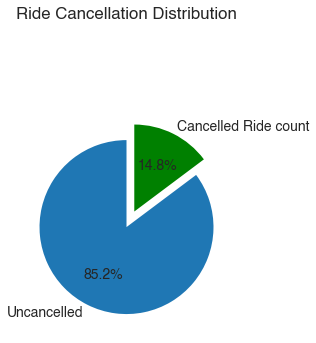

In [ ]:
ride_count = df_ride_exp['ride_id'].count()
uncancelled_count = ride_count - cancel_ride_count 
cancel_longer_5min = cancel_ride_count - is_quick_rerequested_cancel_count
cancel_ride_count
sizes = [uncancelled_count, cancel_longer_5min, is_quick_rerequested_cancel_count]
sizes = [uncancelled_count, cancel_ride_count]
labels = ['Uncancelled', 'Cancelled Ride count']
explode = [0, 0.2]
colors=['tab:blue', 'green']


plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("Ride Cancellation Distribution", pad=80)


Text(0.5, 1.0, 'Mistaken vs Unmistaken Cancelled Ride')

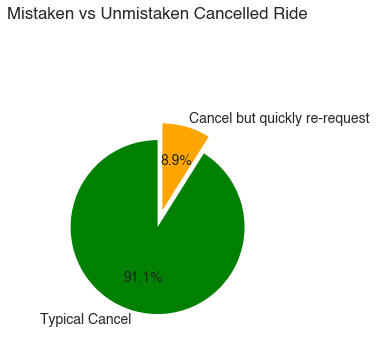

In [ ]:
ride_count = df_ride_exp['ride_id'].count()
uncancelled_count = ride_count - cancel_ride_count 
unmistake_cancel = cancel_ride_count - is_quick_rerequested_cancel_count
sizes = [unmistake_cancel, is_quick_rerequested_cancel_count]
labels = ['Typical Cancel', 'Cancel but quickly re-request']
explode = [0, 0.2]
colors=['green', 'orange']

plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("Mistaken vs Unmistaken Cancelled Ride", pad=80)

## Price
- Cancel penalty => Cancellation
- upfront fee => cancellation 
- actual vs upfront fee gap => rider_request_number
- high fee ride vs low fee ride (upfront fee)
- **Ride_Paid_amount include cancellation fee? YES



#### actual vs upfront fee gap
    
=> predict total rider_request_number

Assumption:
- If there are more actual > upfront => total rider_request_number is lower

Need to remove those rides that are cancelled


In [ ]:
df_ride_exp['actual_upfront_fee_gap'] = df_ride_exp['rider_paid_amount'] - df_ride_exp['upfront_fare']

# change cancelled ride value to nan
df_ride_exp.loc[df_ride_exp['cancellation_flag']==1, 'actual_upfront_fee_gap'] = np.nan

#### high fee ride vs low fee ride (upfront fee)

In [ ]:
# total ride count
ride_count = df_ride_exp['ride_id'].nunique()
ride_count

1402312

In [ ]:
# investigate upfront_fare null

null_fare_count = df_ride_exp[df_ride_exp['upfront_fare'].isnull()]['ride_id'].count()
null_fare_count


4977

In [ ]:
null_fare_count / ride_count

0.00354913885069799

Only 0.3% of the rides with null upfront_fare

drop those records

In [ ]:
# drop null upfront_fare rides
df_ride_exp.dropna(subset=['upfront_fare'], axis=0, inplace=True)

Text(0.5, 1.0, 'Upfront Fare distribution')

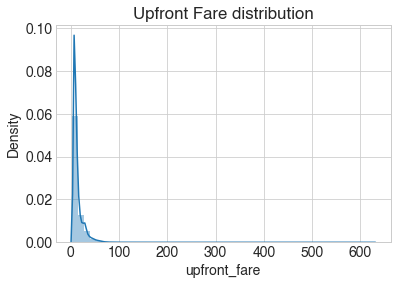

In [ ]:
# plot upfront fee 
sns.distplot(df_ride_exp['upfront_fare'])
plt.title("Upfront Fare distribution")

In [ ]:
print(f"Average up front fare : ${df_ride_exp['upfront_fare'].mean():.2f}")
print(f"Median up front fare : ${df_ride_exp['upfront_fare'].median():.2f}")

Average up front fare : $14.07
Median up front fare : $10.46


Upfront fare skewed to the right

Text(0.5, 1.0, 'Cancellation vs Upfront Fare')

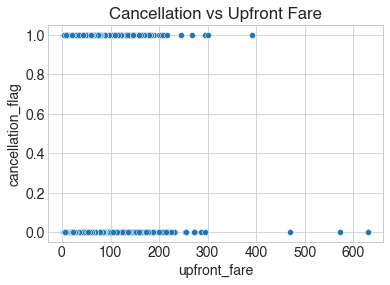

In [ ]:
# upfront fare vs cancellation flag

sns.scatterplot(x=df_ride_exp['upfront_fare'], y=df_ride_exp['cancellation_flag'])
plt.title("Cancellation vs Upfront Fare")

No obvious sign that upfront fare is correlated to cancellation 

In [ ]:
df_rider_upfront_fee = df_ride_exp.groupby('rider_id')['upfront_fare'].mean().reset_index()
df_rider_upfront_fee.sort_values(by='upfront_fare', ascending=False)

rider_id  upfront_fare
5500    +fNCsahamPS2q7lCLgyQuQ==       629.190
426664  nbjBWiI6AFgH0qZIqwcxRw==       294.300
496472  w0134mXw66p3WjtKXnvWIg==       294.050
132281  E06CtM1fJTHAc81QxrTA0w==       289.255
150611  GDzUvCbZDq+rVipFwY4r2w==       287.140
...                          ...           ...
457607  rKF8Q4leEjE+IXrybIbwLw==         2.810
376147  hU4ATImKFEO7d/PjuINw+A==         2.780
186235  KWft4HrpP0+87mICHd3bCQ==         2.780
110806  BPxMxpskwkmNkheCFnYM8Q==         2.760
243359  RQPraxaDODh/7ikZDAZbXw==         2.760

[529084 rows x 2 columns]

Text(0.5, 1.0, 'Average Upfront Fare per rider')

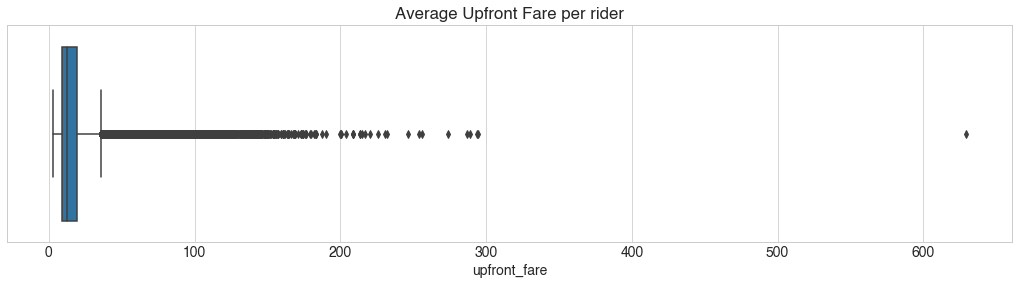

In [ ]:
# identify high fee riders vs low fee riders
plt.figure(figsize=(18, 4))
sns.boxplot(df_rider_upfront_fee['upfront_fare'])
plt.title("Average Upfront Fare per rider")


In [ ]:
df_rider_upfront_fee.describe()

upfront_fare
count  529084.000000
mean       16.447775
std        12.260965
min         2.760000
25%         8.851650
50%        12.265000
75%        19.585000
max       629.190000

In [ ]:
stat_result(df_rider_upfront_fee, 'upfront_fare')

Total count: 529,084
Mean: 16.44777485489108
Median: 12.265
low_outlier: -7.248375000000008
high_outlier: 35.68502500000001
Below lower quartile count: 132,271
Above higher quartile count: 132,273
Lower outlier count: 0
Higher outlier count: 37,268
Percentage higher outlier: 0.007%


(-7.248375000000008, 35.68502500000001)

We assume riders with avarege upfront_fare above upper quartile are consistently looking for 

- longer distance ride 
- late night rides 
- rides at busy hours

## Ride Time  
- Late night ride (11pm to 6am) or day time ride
- peak hour rides (only weekdays, 7-10am, 4-7pm)
- Ride duration


#### Late night ride (11pm to 6am) or day time ride
- Check if late night ride have higher chance to be cancelled


In [ ]:
df_ride_exp['requested_at_local']

265252    2019-05-24 22:14:29
855751    2019-05-18 01:23:50
1083825   2019-04-23 17:44:47
1083826   2019-05-20 15:04:52
1337935   2019-04-16 17:45:01
                  ...        
754292    2019-05-21 17:14:24
90217     2019-04-26 07:37:36
447382    2019-05-18 14:12:26
537661    2019-04-26 07:54:49
537662    2019-05-01 07:51:47
Name: requested_at_local, Length: 1397335, dtype: datetime64[ns]

In [ ]:
# total unique riders
total_unique_riders = df_ride_exp['rider_id'].nunique()
print(f"Total unique rider: {total_unique_riders:,}")


Total unique rider: 529,084


In [ ]:
# late night request is between 11pm and 6am 

df_ride_exp['is_late_request'] = 0
late_request_hours_filter = (df_ride_exp['requested_at_local'].dt.hour >= 23) | (df_ride_exp['requested_at_local'].dt.hour <= 6)

df_ride_exp.loc[late_request_hours_filter, 'is_late_request'] = 1
df_ride_exp.head()


ride_id                  rider_id  \
265252   I9+8q9h67J5XL7x+X2flrA==  +++3990cLNPGgaPm+ripGg==   
855751   FcDOAnNo5aTeYKG1iTyxSA==  +++stf7DqWcT8LMTYbXrwA==   
1083825  JwACfbilNJG1WIH5meqY/A==  ++07zTPYFhvA5Ug72kRd0w==   
1083826  MXUBhCnXvV4tiimvuSuP1g==  ++07zTPYFhvA5Ug72kRd0w==   
1337935  LyL81zlkrtWgRju0jZgFpQ==  ++08hetKFBNoOO5XHAH/5A==   

                        driver_id ride_type  upfront_fare  rider_paid_amount  \
265252   FHbAK1g1kiIr7WUS2TeXgg==  standard         35.00              34.80   
855751   OmB5LM8HAb8y1AtLA/trSg==  standard          7.46               5.00   
1083825  NosKHZuI8QjmRNhgJ4jPjQ==    shared          7.68               7.71   
1083826  5gjyvf7FJVkNnVogWQQeUA==    shared          7.38               7.41   
1337935  ZG0GOVix+6PDbt4cDYhY6g==    shared         11.98              15.82   

         eta_to_rider_pre_match  eta_to_rider_post_match  requested_at_local  \
265252                    326.0                    249.0 2019-05-24 22:14:29   
855751                     60.0                    160.0 2019-05-18 01:23:50   
1083825                   270.0                    303.0 2019-04-23 17:44:47   
1083826                   221.0                     83.0 2019-05-20 15:04:52   
1337935                     NaN                    236.0 2019-04-16 17:45:01   

              accepted_at_local  ... cancel_penalty post_pre_match_gap  \
265252  2019-05-24 22:14:43.028  ...            5.0              -77.0   
855751  2019-05-18 01:23:58.419  ...            5.0              100.0   
1083825 2019-04-23 17:44:53.077  ...            3.0               33.0   
1083826 2019-05-20 15:05:23.566  ...            3.0             -138.0   
1337935 2019-04-16 17:45:11.484  ...            1.0                NaN   

        actual_post_match_gap  is_standard_type  requested_week  \
265252                   -9.0                 1              21   
855751                    NaN                 1              20   
1083825                  44.0                 0              17   
1083826                 -55.0                 0              21   
1337935                 262.0                 0              16   

         is_regular_rider  rider_requested_gap  is_quick_rerequested_cancel  \
265252                  0                  NaT                            0   
855751                  0                  NaT                            0   
1083825                 0                  NaT                            0   
1083826                 0     26 days 21:20:05                            0   
1337935                 1                  NaT                            0   

         actual_upfront_fee_gap is_late_request  
265252                    -0.20               0  
855751                      NaN               1  
1083825                    0.03               0  
1083826                    0.03               0  
1337935                    3.84               0  

[5 rows x 30 columns]

In [ ]:
df_rider_late_count_g = df_ride_exp.groupby('rider_id').agg({'is_late_request': 'mean', 'ride_id': 'count'}).sort_values(by=['is_late_request', 'ride_id'], ascending=False).reset_index().rename(columns={'ride_id': 'ride_count'})
df_rider_late_count_g.head()

rider_id  is_late_request  ride_count
0  lIdb0IkSSi6soN0sAQhjHQ==              1.0          18
1  osqXRWUF/wQ8DdfyD+cnXw==              1.0          16
2  88IMqEhtAC50VAgb+G1vtQ==              1.0          15
3  ClTL0AE693b6cyxcX5nGZg==              1.0          14
4  EFKU/I6H8lo3wPfAxMgfAw==              1.0          14

If is_late_request = 1, rider only rides at late hours

In [ ]:
df_rider_late_count_g.drop('ride_count', axis=1, inplace=True)

#### peak hour rides 
- assume only weekdays, 7-10am, 4-7pm

In [ ]:
# assume only weekdays, 7-10am, 4-7pm
# exclude sharp 19:00

df_ride_exp['is_peak_hour'] = 0
peak_hours_filter = (df_ride_exp['requested_at_local'].dt.hour.isin([7,8,9,10,16,17,18])) & (df_ride_exp['requested_at_local'].dt.day_of_week < 5)
df_ride_exp.loc[peak_hours_filter, 'is_peak_hour'] = 1
df_ride_exp.head()


ride_id                  rider_id  \
265252   I9+8q9h67J5XL7x+X2flrA==  +++3990cLNPGgaPm+ripGg==   
855751   FcDOAnNo5aTeYKG1iTyxSA==  +++stf7DqWcT8LMTYbXrwA==   
1083825  JwACfbilNJG1WIH5meqY/A==  ++07zTPYFhvA5Ug72kRd0w==   
1083826  MXUBhCnXvV4tiimvuSuP1g==  ++07zTPYFhvA5Ug72kRd0w==   
1337935  LyL81zlkrtWgRju0jZgFpQ==  ++08hetKFBNoOO5XHAH/5A==   

                        driver_id ride_type  upfront_fare  rider_paid_amount  \
265252   FHbAK1g1kiIr7WUS2TeXgg==  standard         35.00              34.80   
855751   OmB5LM8HAb8y1AtLA/trSg==  standard          7.46               5.00   
1083825  NosKHZuI8QjmRNhgJ4jPjQ==    shared          7.68               7.71   
1083826  5gjyvf7FJVkNnVogWQQeUA==    shared          7.38               7.41   
1337935  ZG0GOVix+6PDbt4cDYhY6g==    shared         11.98              15.82   

         eta_to_rider_pre_match  eta_to_rider_post_match  requested_at_local  \
265252                    326.0                    249.0 2019-05-24 22:14:29   
855751                     60.0                    160.0 2019-05-18 01:23:50   
1083825                   270.0                    303.0 2019-04-23 17:44:47   
1083826                   221.0                     83.0 2019-05-20 15:04:52   
1337935                     NaN                    236.0 2019-04-16 17:45:01   

              accepted_at_local  ... post_pre_match_gap actual_post_match_gap  \
265252  2019-05-24 22:14:43.028  ...              -77.0                  -9.0   
855751  2019-05-18 01:23:58.419  ...              100.0                   NaN   
1083825 2019-04-23 17:44:53.077  ...               33.0                  44.0   
1083826 2019-05-20 15:05:23.566  ...             -138.0                 -55.0   
1337935 2019-04-16 17:45:11.484  ...                NaN                 262.0   

        is_standard_type  requested_week  is_regular_rider  \
265252                 1              21                 0   
855751                 1              20                 0   
1083825                0              17                 0   
1083826                0              21                 0   
1337935                0              16                 1   

         rider_requested_gap  is_quick_rerequested_cancel  \
265252                   NaT                            0   
855751                   NaT                            0   
1083825                  NaT                            0   
1083826     26 days 21:20:05                            0   
1337935                  NaT                            0   

         actual_upfront_fee_gap  is_late_request is_peak_hour  
265252                    -0.20                0            0  
855751                      NaN                1            0  
1083825                    0.03                0            1  
1083826                    0.03                0            0  
1337935                    3.84                0            1  

[5 rows x 31 columns]

In [ ]:
# create rider with average peak hour ride
df_rider_avg_peak_hour_count_g = df_ride_exp.groupby('rider_id').agg({'is_peak_hour': 'mean', 'ride_id': 'count'}).sort_values(by=['is_peak_hour', 'ride_id'], ascending=False).reset_index().rename(columns={'ride_id': 'ride_count'})
df_rider_avg_peak_hour_count_g.head()

rider_id  is_peak_hour  ride_count
0  /DmOu14DVUFwIy6rLrZ3uQ==           1.0          21
1  AkM4DBa5S/gOXxM4Nr6lXw==           1.0          21
2  +K3jrYZJWGFtzn0Z9inwyg==           1.0          20
3  /L0+5vtHxEJYnui88LnYRg==           1.0          19
4  fygvs2EHhLlZ9pRWtbmxCg==           1.0          19

When is_peak_hour = 1 => rider only take rides during peak hours

In [ ]:
df_rider_avg_peak_hour_count_g.drop('ride_count', axis=1, inplace=True)

#### Ride duration
assumption:
- longer the ride duration, longer the distance in general, harder to find other substition => less likely cancel

In [ ]:
# build ride duration tag
df_ride_exp['ride_duration'] = (df_ride_exp['dropped_off_at_local'] - df_ride_exp['picked_up_at_local']).apply(lambda x: x.total_seconds())
df_ride_exp[['dropped_off_at_local', 'picked_up_at_local', 'ride_duration']].head()

dropped_off_at_local  picked_up_at_local  ride_duration
265252   2019-05-24 22:51:37 2019-05-24 22:19:14         1943.0
855751                   NaT                 NaT            NaN
1083825  2019-04-23 18:13:37 2019-04-23 17:50:55         1362.0
1083826  2019-05-20 15:24:23 2019-05-20 15:06:02         1101.0
1337935  2019-04-16 18:26:29 2019-04-16 17:53:45         1964.0

Ride duration stats include outlier
Total count: 1,189,203
Mean: 979.1984757858835
Median: 794.0
low_outlier: -590.0
high_outlier: 2338.0
Below lower quartile count: 297,482
Above higher quartile count: 297,367
Lower outlier count: 0
Higher outlier count: 55,961
Percentage higher outlier: 0.197%


(-590.0, 2338.0)

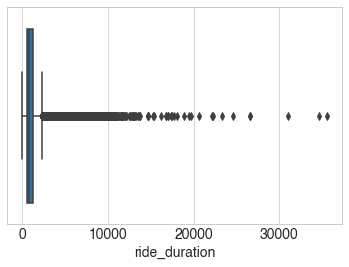

In [ ]:
# ride duration outlier
sns.boxplot(df_ride_exp['ride_duration'])
print("Ride duration stats include outlier")
stat_result(df_ride_exp, 'ride_duration')


Text(0.5, 0, 'Ride duration in sec')

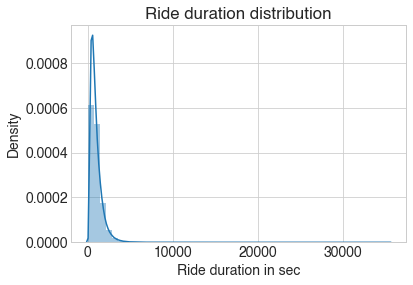

In [ ]:
sns.distplot(df_ride_exp['ride_duration'])
plt.title("Ride duration distribution")
plt.xlabel("Ride duration in sec")

Text(0.5, 0, 'Ride duration in sec')

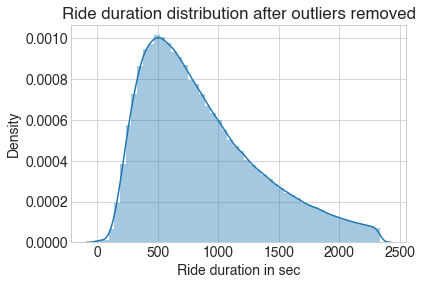

In [ ]:
'''NEED TO REVISIT'''
# check ride_duration > high outlier (2338 sec, ~ 40 min)
df_temp = df_ride_exp.copy()
duration_high_outlier = 2338.0
df_temp['ride_duration'] = df_temp.loc[df_temp['ride_duration'] < duration_high_outlier, 'ride_duration']
sns.distplot(df_temp['ride_duration'])
plt.title("Ride duration distribution after outliers removed")
plt.xlabel("Ride duration in sec")

Still skewed to the right after outlier removal

In [ ]:
# remove outlier
print(f"original ride count: {df_ride_exp['ride_id'].nunique():,}")
print(f"original ride count: {df_temp['ride_id'].nunique():,}")
# df_ride_exp[df_ride_exp['ride_duration'] > duration_high_outlier][['ride_type', 'ride_duration']].value_counts()
pd.crosstab(df_ride_exp['ride_duration'], df_ride_exp['ride_type'])
# df_temp['ride_duration'].sort_values(ascending=False)
# print(f"ride count after outlier removal: {df_ride_exp['ride_id'].nunique():,}")

original ride count: 1,397,335
original ride count: 1,397,335


ride_type      shared  standard
ride_duration                  
2.0                 3         0
3.0                21         1
4.0                42         1
5.0                35         5
6.0                38        10
...               ...       ...
26588.0             0         1
26608.0             0         1
31059.0             0         1
34635.0             0         1
35537.0             1         0

[6585 rows x 2 columns]

In [ ]:
# group by rider, average ride duration and ride count
df_rider_avg_ride_duration_count_g = df_ride_exp.groupby('rider_id').agg({'ride_duration': 'mean', 'ride_id': 'count'}).sort_values(by=['ride_duration', 'ride_id'], ascending=[False, False]).reset_index().rename(columns={'ride_id': 'ride_count'})
df_rider_avg_ride_duration_count_g

rider_id  ride_duration  ride_count
0       mchXFzH9hjkDFvOIwclZtg==        26588.0           1
1       PwJhwbZzFC144+xKglG9kA==        24547.0           1
2       gb2QOYIr4M7E6BS8kpRgUg==        22288.0           1
3       jnpvOTOz/Kf9edrI+N9OOA==        19696.0           1
4       BJZhwo/cuRd7DpaJiLCkcA==        17693.5           2
...                          ...            ...         ...
529079  zzgkzHHBJSpzZ71q072ERQ==            NaN           1
529080  zzlFSt/eafRA0OcEfvG8SQ==            NaN           1
529081  zzp3q9z4jiGzIWIBfb79Hw==            NaN           1
529082  zzw4Ctqgf818aSNnB+F4hg==            NaN           1
529083  zzxF80GXwRzlsjwhllyCIA==            NaN           1

[529084 rows x 3 columns]

Text(0.5, 1.0, 'ride count over ride duration (seconds) per rider')

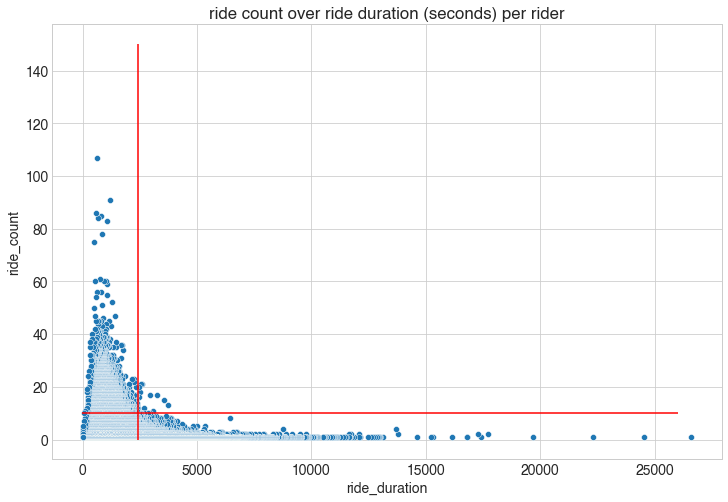

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=df_rider_avg_ride_duration_count_g['ride_duration'], y=df_rider_avg_ride_duration_count_g['ride_count'])
plt.hlines(y=10, color='red', xmin=-10, xmax=26000)
plt.vlines(x=2400, ymin=0, ymax=150, colors='red')
plt.title('ride count over ride duration (seconds) per rider')

For riders who use The Company frequently (assume total ride count > 10 within 42 days), their ride durations are almost always within ~2500-2700 seconds (~45 min)

Text(0.5, 1.0, 'ride duration (seconds) per rider')

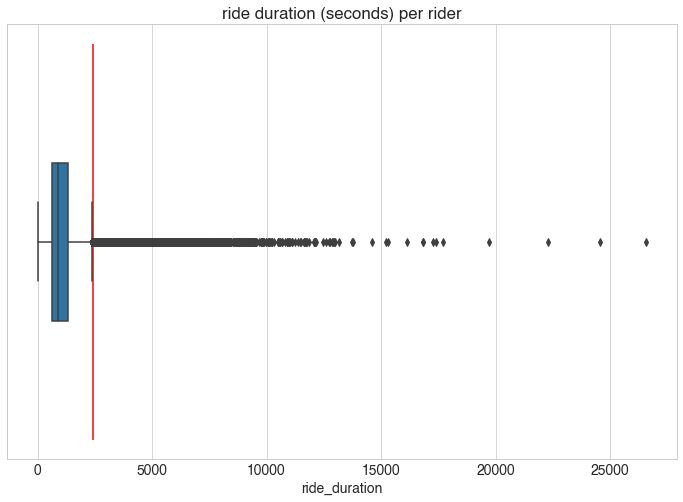

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x=df_rider_avg_ride_duration_count_g['ride_duration'])
plt.vlines(x=2400, ymin=-1, ymax=1, colors='red')

plt.title('ride duration (seconds) per rider')

In [ ]:
stat_result(df_rider_avg_ride_duration_count_g, 'ride_duration')

Total count: 477,018
Mean: 1080.776499339639
Median: 896.4444444444445
low_outlier: -455.0
high_outlier: 2393.0
Below lower quartile count: 119,525
Above higher quartile count: 119,263
Lower outlier count: 0
Higher outlier count: 25,671
Percentage higher outlier: 0.502%


(-455.0, 2393.0)

In [ ]:
# remov ride_count
df_rider_avg_ride_duration_count_g.drop('ride_count', axis=1, inplace=True)

In [ ]:
df_ride_exp.loc[(df_ride_exp['ride_duration'] > 2393) & (df_ride_exp['eta_to_rider_pre_match'].isnull())]

ride_id                  rider_id  \
997231   Lfow0uR0n/Gb/AnOjgVtSw==  ++c8LQaqaabodbzzTkr5Ug==   
37655    FTE3+X6g5wD0XbCNF14ZGA==  +/HaJKhntHXYm38/zAWWDA==   
275833   BEvVFtRyEcJPorYBEpPc8w==  +/dke18yi7LbYfZ5xgUlBA==   
993111   H3FvyB1qJnKOptKAEaqa5Q==  +/p3bb17lHbdj2UL54+8DA==   
993115   PdcJIo8nyeCzYvdPqKFVFw==  +/p3bb17lHbdj2UL54+8DA==   
...                           ...                       ...   
707358   JiCYFqAW1yqd0xuI7HZt+A==  zuTDUoCh9jBvUMhfVrfjQA==   
617739   MyROL4n9fPLWSYCnjQD53Q==  zvqKc22ErJ9tSIiaSOayjw==   
617740   LnTYPHscq/mnisaeGqFJ2A==  zvqKc22ErJ9tSIiaSOayjw==   
1190482  FM6jbE1iCzmDeh9p+igopA==  zwCTCNgOQ1+S7bMZpyMfJQ==   
555124   CzkQlaK6XQ5/G70pjBh4oQ==  zxICMkhWg+VEFgQma/NELQ==   

                        driver_id ride_type  upfront_fare  rider_paid_amount  \
997231   lA9wJLZ+j1HYJwgWFSKXqQ==    shared         33.61              35.33   
37655    eEXFOhmT3ZOjHpcm15bLDg==  standard         54.80              54.53   
275833   A0lGXcB01nPibEm/SXWHJQ==  standard         60.68              73.75   
993111   flQDy/WpnP2y9TTc969lDw==  standard         57.87              60.74   
993115   QTORk/e+oLdSjA22+TGA5g==  standard         48.30              60.30   
...                           ...       ...           ...                ...   
707358   XEmq3LeHUfe4sdih3a/WcQ==  standard         44.35              44.54   
617739   TwqpTsRMAMCLvUIY+2SXbw==  standard         23.61              23.70   
617740   IVrn9rKX9XcJ/UDc17hG2w==  standard         13.96              30.78   
1190482  IEV7TDM/ccz2iY/91vWdJQ==  standard         34.43              34.20   
555124   2kLmHrCW711cyC2cDMFH6A==    shared         13.35              13.28   

         eta_to_rider_pre_match  eta_to_rider_post_match  requested_at_local  \
997231                      NaN                    235.0 2019-04-23 00:58:51   
37655                       NaN                    109.0 2019-05-17 12:52:31   
275833                      NaN                     75.0 2019-05-03 09:59:09   
993111                      NaN                     93.0 2019-04-19 09:04:31   
993115                      NaN                    190.0 2019-05-10 09:18:17   
...                         ...                      ...                 ...   
707358                      NaN                     17.0 2019-04-18 12:33:50   
617739                      NaN                    391.0 2019-05-02 13:31:44   
617740                      NaN                    471.0 2019-05-02 15:26:43   
1190482                     NaN                     64.0 2019-05-10 08:27:44   
555124                      NaN                    456.0 2019-04-20 17:01:46   

              accepted_at_local  ... actual_post_match_gap is_standard_type  \
997231  2019-04-23 00:58:53.536  ...                 -46.0                0   
37655   2019-05-17 12:52:39.733  ...                  -1.0                1   
275833  2019-05-03 09:59:20.990  ...                 405.0                1   
993111  2019-04-19 09:04:40.862  ...                 -19.0                1   
993115  2019-05-10 09:18:49.231  ...                  66.0                1   
...                         ...  ...                   ...              ...   
707358  2019-04-18 12:33:58.413  ...                  51.0                1   
617739  2019-05-02 13:31:59.504  ...                  44.0                1   
617740  2019-05-02 15:27:00.367  ...                  72.0                1   
1190482 2019-05-10 08:27:58.646  ...                  -1.0                1   
555124  2019-04-20 17:02:52.099  ...                 247.0                0   

        requested_week  is_regular_rider  rider_requested_gap  \
997231              17                 0                  NaT   
37655               20                 0      0 days 04:48:38   
275833              18                 0                  NaT   
993111              16                 0                  NaT   
993115              19                 0      2 days 14:44:37   
...     

Observation:

- There are 4509 of those higher outlier duration rides that do not have eta to rider pre match, but only eta to rider post match
- Could be algorithm problems

Assume ride duration that's longer than 7200 seconds (2 hours) are long rides

In [ ]:
df_ride_exp[(df_ride_exp['ride_duration'] >= 7200)]
df_ride_exp[(df_ride_exp['ride_duration'] >= 7200)&(df_ride_exp['cancellation_flag']==1)]

Empty DataFrame
Columns: [ride_id, rider_id, driver_id, ride_type, upfront_fare, rider_paid_amount, eta_to_rider_pre_match, eta_to_rider_post_match, requested_at_local, accepted_at_local, arrived_at_local, picked_up_at_local, dropped_off_at_local, actual_time_to_arrival, cancellation_flag, rider_request_number, cancel_before_matched, cancel_after_matched, accepted_requested_gap, variant, cancel_penalty, post_pre_match_gap, actual_post_match_gap, is_standard_type, requested_week, is_regular_rider, rider_requested_gap, is_quick_rerequested_cancel, actual_upfront_fee_gap, is_late_request, is_peak_hour, ride_duration]
Index: []

[0 rows x 32 columns]

In [ ]:
df_ride_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1397335 entries, 265252 to 537662
Data columns (total 32 columns):
 #   Column                       Non-Null Count    Dtype          
---  ------                       --------------    -----          
 0   ride_id                      1397335 non-null  object         
 1   rider_id                     1397335 non-null  object         
 2   driver_id                    1362957 non-null  object         
 3   ride_type                    1397335 non-null  object         
 4   upfront_fare                 1397335 non-null  float64        
 5   rider_paid_amount            1397335 non-null  float64        
 6   eta_to_rider_pre_match       1331610 non-null  float64        
 7   eta_to_rider_post_match      1362928 non-null  float64        
 8   requested_at_local           1397335 non-null  datetime64[ns] 
 9   accepted_at_local            1362928 non-null  datetime64[ns] 
 10  arrived_at_local             1189241 non-null  datetime64[ns] 

In [ ]:
df_ride_exp['ride_id'].nunique()

1397335

There are 442 rides that are regarded as long rides, out of 1397335 total rides, very small portion. All of them did not cancel.

## Feature Engineering

In [ ]:
df_ride_exp.columns

Index(['ride_id', 'rider_id', 'driver_id', 'ride_type', 'upfront_fare',
       'rider_paid_amount', 'eta_to_rider_pre_match',
       'eta_to_rider_post_match', 'requested_at_local', 'accepted_at_local',
       'arrived_at_local', 'picked_up_at_local', 'dropped_off_at_local',
       'actual_time_to_arrival', 'cancellation_flag', 'rider_request_number',
       'cancel_before_matched', 'cancel_after_matched',
       'accepted_requested_gap', 'variant', 'cancel_penalty',
       'post_pre_match_gap', 'actual_post_match_gap', 'is_standard_type',
       'requested_week', 'is_regular_rider', 'rider_requested_gap',
       'is_quick_rerequested_cancel', 'actual_upfront_fee_gap',
       'is_late_request', 'is_peak_hour', 'ride_duration'],
      dtype='object')

#### Ride Info

Text(0.5, 1.0, 'Correlations between ride features')

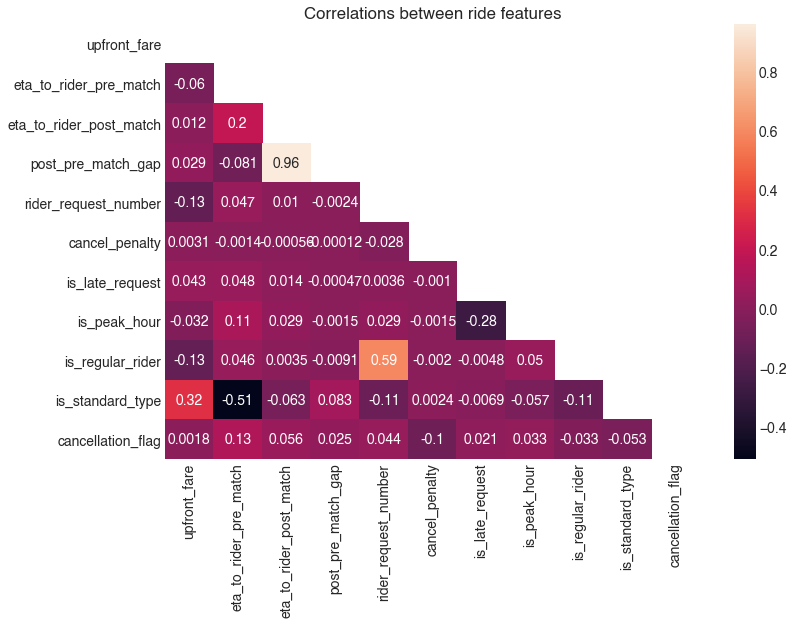

In [ ]:
# Rides correlations
# ride_cancel_features 
ride_cancel_features = ['upfront_fare', 
                        'eta_to_rider_pre_match', 
                        'eta_to_rider_post_match',
                        'post_pre_match_gap', 
                        'rider_request_number', 
                        'cancel_penalty', 
                        'is_late_request', 
                        'is_peak_hour', 
                        'is_regular_rider', 
                        'is_standard_type',
                        'cancellation_flag'] 

corr = df_ride_exp[ride_cancel_features].corr()
matrix = np.triu(corr)
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, mask=matrix)
plt.title("Correlations between ride features")


Observation:

**Low correlations for most of the features to cancellation flag**

--

eta_to_rider_pre_match vs standard type ride 

- assumption: 

Standard rides have a higher matching priority to match drivers that were more closed by 

standard type vs upfront_fare

=> Standard ride's fare is higher

=> better service (i.e. short eta drivers to standard ride requests)

#### Per Rider info

- cancellation rate

cancellation rate = cancellation count / total ride count

In [ ]:
df_ride_exp.groupby('rider_id')['ride_id'].nunique().sort_values(ascending=False)

rider_id
slnsaVpV1+N6m6tiOFOvDQ==    107
Ojdflb45wpmD5B31JRQFMg==     91
GGsWWNPAJcdLpzvOwOq5ng==     86
o2tPXTJl7DcV4FoAR+0T2g==     85
7No0Gd60A6h1A+DtX46L8g==     84
                           ... 
QEq0X53uAhh/pOv7wU3Lqw==      1
QEoAeZUg+vkApvKRc8ovBg==      1
QEnoL8npu3x1CTUt0TUHow==      1
QEmk9uOmccD8v0UP0JbO7g==      1
TzauuTLW4bZd6qap67urvQ==      1
Name: ride_id, Length: 529084, dtype: int64

In [ ]:
# calculate cancellation rate per rider

rider_cancel_count = df_ride_exp.groupby('rider_id')['cancellation_flag'].sum()
rider_total_ride_count = df_ride_exp.groupby('rider_id')['ride_id'].nunique()
rider_cancel_rate = rider_cancel_count/rider_total_ride_count

df_rider_cancel_rate_g = rider_cancel_rate.sort_values(ascending=False).reset_index()
df_rider_cancel_rate_g.rename(columns={0: 'cancellation_rate'}, inplace=True)
df_rider_cancel_rate_g.head()


rider_id  cancellation_rate
0       9aPywaxTTcKgwd1InaGRxg==                1.0
1       C5iw11fpac9coCswsMj+Hg==                1.0
2       MzHmwW8tLDZ19K4rTPsUiA==                1.0
3       6u7MrnyTNigr0yNCy2eqNQ==                1.0
4       wJu9camYUoR1O/d9b1esvQ==                1.0
...                          ...                ...
529079  LySCoqxKMTsPFb6wnbylWQ==                0.0
529080  LyRcdTn9vrUhiD0IRanB+A==                0.0
529081  LyRWq+Rpb4DqHhfptIepCw==                0.0
529082  LyRJFEo5uYLUWwIGay7Quw==                0.0
529083  zzzhpNF1l7HdwyBef3huRw==                0.0

[529084 rows x 2 columns]

In [ ]:
average_cancellation_rate = df_rider_cancel_rate_g['cancellation_rate'].mean()
average_cancellation_rate

0.13501611895610457

In [ ]:
df_ride_exp.columns

Index(['ride_id', 'rider_id', 'driver_id', 'ride_type', 'upfront_fare',
       'rider_paid_amount', 'eta_to_rider_pre_match',
       'eta_to_rider_post_match', 'requested_at_local', 'accepted_at_local',
       'arrived_at_local', 'picked_up_at_local', 'dropped_off_at_local',
       'actual_time_to_arrival', 'cancellation_flag', 'rider_request_number',
       'cancel_before_matched', 'cancel_after_matched',
       'accepted_requested_gap', 'variant', 'cancel_penalty',
       'post_pre_match_gap', 'actual_post_match_gap', 'is_standard_type',
       'requested_week', 'is_regular_rider', 'rider_requested_gap',
       'is_quick_rerequested_cancel', 'actual_upfront_fee_gap',
       'is_late_request', 'is_peak_hour', 'ride_duration'],
      dtype='object')

### Aggrgating the follower df to get per rider info
-- x -- 
- upfront_fare -> df_rider_upfront_fare_avg_g
- eta_to_rider_pre_match -> df_rider_eta_to_rider_pre_match_avg_g
- eta_to_rider_post_match -> df_rider_eta_to_rider_post_match_avg_g
- post_pre_match_gap -> df_rider_post_pre_match_gap_avg_g
- actual_post_match_gap -> df_rider_actual_post_match_gap_avg_g
- cancel_before_matched -> df_rider_cancelled_before_match_avg_g
- cancel_after_matched -> df_rider_cancelled_after_match_avg_g
- cancel_penalty -> df_rider_cancel_penalty_g
- accepted_requested_gap -> df_rider_accepted_requested_gap_avg_g
- is_late_request -> df_rider_late_count_g
- is_peak_hour -> df_rider_avg_peak_hour_count_g
- is_regular_rider -> df_is_regular_rider_g
- is_standard_type -> df_rider_standard_g
- is_quick_rerequested_cancel -> df_rider_mistake_cancel_avg_g
- ride_duration -> df_rider_avg_ride_duration_count_g


-- labels --
- rider_paid_amount -> df_rider_paid_amount_avg_g
- cancellation_rate -> df_rider_cancel_rate_g
- rider_request_number -> df_rider_request_count_g


In [ ]:
df_rider_upfront_fare_avg_g = df_ride_exp.groupby('rider_id')['upfront_fare'].mean().sort_values(ascending=False).reset_index()

rider_id  upfront_fare
0       +fNCsahamPS2q7lCLgyQuQ==       629.190
1       nbjBWiI6AFgH0qZIqwcxRw==       294.300
2       w0134mXw66p3WjtKXnvWIg==       294.050
3       E06CtM1fJTHAc81QxrTA0w==       289.255
4       GDzUvCbZDq+rVipFwY4r2w==       287.140
...                          ...           ...
529079  rKF8Q4leEjE+IXrybIbwLw==         2.810
529080  hU4ATImKFEO7d/PjuINw+A==         2.780
529081  KWft4HrpP0+87mICHd3bCQ==         2.780
529082  BPxMxpskwkmNkheCFnYM8Q==         2.760
529083  RQPraxaDODh/7ikZDAZbXw==         2.760

[529084 rows x 2 columns]

In [ ]:
df_rider_eta_to_rider_pre_match_avg_g = df_ride_exp.groupby('rider_id')['eta_to_rider_pre_match'].mean().sort_values(ascending=False).reset_index()

rider_id  eta_to_rider_pre_match
0       eNrUblKEBwyyUHMety1DQQ==                  1380.0
1       AWE0NLwrXqmt1daLd57eSQ==                  1320.0
2       fE8kJX/kbDN1qyDbAkjdyg==                  1314.0
3       f4TrupV+NAbJsO17duYc0Q==                  1298.0
4       UYLOacyMzolU9r28MqEXmQ==                  1295.0
...                          ...                     ...
529079  zzg8Ze8kM9PR4CVoRSlFlQ==                     NaN
529080  zziN455KJ32C5ymE5JeEvw==                     NaN
529081  zzp3q9z4jiGzIWIBfb79Hw==                     NaN
529082  zzw3Rjf19c8IMnyOYfHEig==                     NaN
529083  zzxZU/e6hKC1DFRoPJFlKw==                     NaN

[529084 rows x 2 columns]

In [ ]:
df_rider_eta_to_rider_post_match_avg_g = df_ride_exp.groupby('rider_id')['eta_to_rider_post_match'].mean().sort_values(ascending=False).reset_index()

rider_id  eta_to_rider_post_match
0       FAF8D+hVwIVZYhkMJY1e+A==                 584845.0
1       9+okhrf7+CfduEc1Ta84kg==                   4866.0
2       RPBzW595Md4WS/pNg1WKFw==                   3944.0
3       zBhH9aVsA4500ejTfSqEWw==                   3796.0
4       oqYp33Hf7WDeHLt8xh8FCg==                   3371.0
...                          ...                      ...
529079  zxJ8GwJfSHu7ARvmZWtVcw==                      NaN
529080  zxLuKiLd9/sI2fF92AUuaQ==                      NaN
529081  zxvhBWmMfLXRgWuBbGshxg==                      NaN
529082  zy5W0ZwUgV5L/f61q0Dpxg==                      NaN
529083  zzPJ71t2jZkvxo2/JISqyA==                      NaN

[529084 rows x 2 columns]

In [ ]:
df_rider_post_pre_match_gap_avg_g = df_ride_exp.groupby('rider_id')['post_pre_match_gap'].mean().sort_values(ascending=False).reset_index()

rider_id  post_pre_match_gap
0       FAF8D+hVwIVZYhkMJY1e+A==            584602.0
1       9+okhrf7+CfduEc1Ta84kg==              4506.0
2       RPBzW595Md4WS/pNg1WKFw==              3722.0
3       zBhH9aVsA4500ejTfSqEWw==              3676.0
4       OAGwDaBhEcN5L0uWk0YMOA==              2125.0
...                          ...                 ...
529079  zzg8Ze8kM9PR4CVoRSlFlQ==                 NaN
529080  zziN455KJ32C5ymE5JeEvw==                 NaN
529081  zzp3q9z4jiGzIWIBfb79Hw==                 NaN
529082  zzw3Rjf19c8IMnyOYfHEig==                 NaN
529083  zzxZU/e6hKC1DFRoPJFlKw==                 NaN

[529084 rows x 2 columns]

In [ ]:
df_rider_actual_post_match_gap_avg_g = df_ride_exp.groupby('rider_id')['actual_post_match_gap'].mean().sort_values(ascending=False).reset_index()

rider_id  actual_post_match_gap
0       efDomOH0oEkQuoyjoYv84w==                 6469.0
1       H23IVrSp1VbRY99n3GFOdg==                 3767.0
2       Lhzb0WIdLrYelw/lXjAWuQ==                 3303.0
3       6lBCf0Cb4ARBW5t9Sc4MAg==                 3198.0
4       Zg3Bb6/f0D9o4yBX1o3CCw==                 3198.0
...                          ...                    ...
529079  zzgkzHHBJSpzZ71q072ERQ==                    NaN
529080  zzlFSt/eafRA0OcEfvG8SQ==                    NaN
529081  zzp3q9z4jiGzIWIBfb79Hw==                    NaN
529082  zzw4Ctqgf818aSNnB+F4hg==                    NaN
529083  zzxF80GXwRzlsjwhllyCIA==                    NaN

[529084 rows x 2 columns]

In [ ]:
df_rider_cancelled_before_match_avg_g = df_ride_exp.groupby('rider_id')['cancel_before_matched'].mean().sort_values(ascending=False).reset_index()

rider_id  cancel_before_matched
0       QZ8OxhMcfnejtoizf0OzNQ==                    1.0
1       mK3ZOncm956oG5sVKyB9SA==                    1.0
2       CS2ur/2ETEPpQ6lmA/nH+A==                    1.0
3       mJLJA0iNyMhPJFj5Mroy6Q==                    1.0
4       wbHPN5xShCraM75rxj18cA==                    1.0
...                          ...                    ...
529079  JtzaiG2zMDb0HKbMLCDOXw==                    0.0
529080  JtySxnA5to5VTA1KgsThxQ==                    0.0
529081  Jtxj1iCeOlfKtCfKc10zkg==                    0.0
529082  Jtwh3BbGRKAr7cTZA4N6cw==                    0.0
529083  zzzhpNF1l7HdwyBef3huRw==                    0.0

[529084 rows x 2 columns]

In [ ]:
df_rider_cancelled_after_match_avg_g = df_ride_exp.groupby('rider_id')['cancel_after_matched'].mean().sort_values(ascending=False).reset_index()

rider_id  cancel_after_matched
0       FeBIcWLZj0gLN2iAAWxUOA==                   1.0
1       QfJF6Qt9dDEmVrUq/vnukg==                   1.0
2       7xhuj07/JbDwG9CekTv7Ig==                   1.0
3       cb0Ir6UtNd231raMktgzXA==                   1.0
4       caz2iYlJueUV5aRHUIDXVg==                   1.0
...                          ...                   ...
529079  LV74ILXhG+aM6pFxskaxNA==                   0.0
529080  LV6iqbcBFtXi4k2kfF5Emg==                   0.0
529081  LV5//90hcZjP6h332x2oDg==                   0.0
529082  LV4uPuX59MrvxfNKkWdB5Q==                   0.0
529083  zzzhpNF1l7HdwyBef3huRw==                   0.0

[529084 rows x 2 columns]

In [ ]:
# cancel_penalty
df_rider_cancel_penalty_g = df_ride_exp.groupby('rider_id')['cancel_penalty'].mean().sort_values(ascending=False).reset_index()

rider_id  cancel_penalty
0       +++3990cLNPGgaPm+ripGg==             5.0
1       HDRtq6l+aOvnFK0o8OpT+w==             5.0
2       gkRV7OWPkkNK78BKQWnUhg==             5.0
3       HDJarHw4OVBhbCENiDiasw==             5.0
4       gkQrrPHCppSXSXzct6oE/w==             5.0
...                          ...             ...
529079  DWtVRPnldZazPxXaMRnpow==             1.0
529080  Z8Wgrblk2S32BUb0bai8fA==             1.0
529081  DWrs5IKnCn3kXXYBDJPJQQ==             1.0
529082  kSTR1u5Wc4VSUFgy2iDLPA==             1.0
529083  TyGnkyFsPh40ksIejcry7Q==             1.0

[529084 rows x 2 columns]

In [ ]:
df_rider_accepted_requested_gap_avg_g = df_ride_exp.groupby('rider_id')['accepted_requested_gap'].mean().sort_values(ascending=False).reset_index()

rider_id  accepted_requested_gap
0       07x29oLHipaLri8E4wDyLw==                  1306.0
1       bmKEVNtd67MWosZ4NGwZiw==                  1208.0
2       iRXJR9EwzIHL7zT8k5FeXw==                  1151.0
3       oxKtWxJ7Uenep6rBtpax1g==                  1055.0
4       dPEyp+7QfZOCo4sqV3vyrQ==                  1046.0
...                          ...                     ...
529079  02OLV3rXQsAQ5WmfPMlqMg==                     0.0
529080  LQOS9nWvi5zLGo85xd8O+A==                     0.0
529081  CJcg7ffZIKYCoVNS4bLhEA==                     0.0
529082  D+P3JKONQCFYdqkrJOisWw==                     0.0
529083  Oi5y/RZ971Pt57ctseiIlA==                     0.0

[529084 rows x 2 columns]

In [ ]:
df_is_regular_rider_g = df_ride_exp.groupby('rider_id')['is_regular_rider'].mean().sort_values(ascending=False).reset_index()

rider_id  is_regular_rider
0       cZBT8lNHn0NrctTHKxJv7A==                 1
1       ak/i+3kakC1OaThJZ16QJg==                 1
2       xS/qOPWZqduGxG97fcBn+Q==                 1
3       GwMN2hfIlUchdjI6N0k9Aw==                 1
4       heha7gL8npO78lReLN87eg==                 1
...                          ...               ...
529079  Jf+Ap1tMn1Gi5Qn6Yvikxg==                 0
529080  JeyYthCe3JY8n+FM9reEEg==                 0
529081  JexyzjnRFYvHaHC/LiejMw==                 0
529082  Jex9dLvQcGdp4+t46ulxGA==                 0
529083  zzzhpNF1l7HdwyBef3huRw==                 0

[529084 rows x 2 columns]

In [ ]:
df_rider_is_standard_type_g = df_ride_exp.groupby('rider_id')['is_standard_type'].mean().sort_values(ascending=False).reset_index()

rider_id  is_standard_type
0       +++3990cLNPGgaPm+ripGg==               1.0
1       a4WwXsFvgg7CcTCfsV+D8A==               1.0
2       a4d4UtdR4BZKuf3JEi4Rkg==               1.0
3       a4d0WptGlyP9IZ5C26fbuQ==               1.0
4       a4bVGMXkX9kEtfxoJscUag==               1.0
...                          ...               ...
529079  50TieansmXykxlZi0cKE6w==               0.0
529080  BpHYLLs2Wq36tjzbmXq47Q==               0.0
529081  KEIchSCTTLJhE47RCtacrQ==               0.0
529082  RhHEMrMTTDouMo7csfPYqA==               0.0
529083  SuPFm+TTvZe0BE+667DaaQ==               0.0

[529084 rows x 2 columns]

In [ ]:
df_rider_is_quick_rerequested_cancel_avg_g = df_ride_exp.groupby('rider_id')['is_quick_rerequested_cancel'].mean().sort_values(ascending=False).reset_index()

rider_id  is_quick_rerequested_cancel
0       xn6NlEik8XbCnILSedkuow==                          1.0
1       dCDKXtOKmOXnqXLvTBvSHA==                          1.0
2       HGnThykhRdlkCvYDoAu9NA==                          1.0
3       hamUQ2QO0YXpKSh0b2uhdQ==                          1.0
4       DY7J8krcS0WgCsEnSea9Hg==                          1.0
...                          ...                          ...
529079  Jcdj0lqiqKNX3+jqlcIGuA==                          0.0
529080  JcciK781feeBy3Zuw6AKAg==                          0.0
529081  JcceNPVz7sUAdsaBkIXlOg==                          0.0
529082  Jcbu8SOVyb9ZJGKGyeZD2A==                          0.0
529083  zzzhpNF1l7HdwyBef3huRw==                          0.0

[529084 rows x 2 columns]

In [ ]:
df_rider_paid_amount_avg_g = df_ride_exp.groupby('rider_id')['rider_paid_amount'].mean().sort_values(ascending=False).reset_index()

rider_id  rider_paid_amount
0       +fNCsahamPS2q7lCLgyQuQ==             629.16
1       E06CtM1fJTHAc81QxrTA0w==             299.39
2       w0134mXw66p3WjtKXnvWIg==             294.08
3       GDzUvCbZDq+rVipFwY4r2w==             287.27
4       dEtqP5RftLySZtXputnW/w==             273.75
...                          ...                ...
529079  urMhGDjMcZo5FXFCvhLB5A==               0.00
529080  NKcQNxSx8hRrkr1pj6HZhw==               0.00
529081  dpQAMy0QqvMcQHSVEkn9JQ==               0.00
529082  8dDTNDWmHmvYntXgTvMn0g==               0.00
529083  kEq7P1DieR71d8J8SrfyOw==               0.00

[529084 rows x 2 columns]

In [ ]:
# y labels 
# ride_request_number
df_rider_request_count_g = df_ride_exp.groupby('rider_id')['rider_request_number'].max().sort_values(ascending=False).reset_index()

rider_id  rider_request_number
0       slnsaVpV1+N6m6tiOFOvDQ==                   107
1       Ojdflb45wpmD5B31JRQFMg==                    91
2       GGsWWNPAJcdLpzvOwOq5ng==                    86
3       o2tPXTJl7DcV4FoAR+0T2g==                    85
4       7No0Gd60A6h1A+DtX46L8g==                    84
...                          ...                   ...
529079  QFlX5rh6clp+NMtEM6dBew==                     1
529080  QFl/hscik2W3cHmdyqKVcg==                     1
529081  QFkXtSQuLo8NjCD04A7/0g==                     1
529082  QFk4JaxE4SOpUyOMxM48sQ==                     1
529083  TzauuTLW4bZd6qap67urvQ==                     1

[529084 rows x 2 columns]

In [ ]:
# merge all grouped by df


# features we created
to_merge = [
    df_rider_upfront_fare_avg_g,
    df_rider_eta_to_rider_pre_match_avg_g,
    df_rider_eta_to_rider_post_match_avg_g,
    df_rider_post_pre_match_gap_avg_g,
    df_rider_actual_post_match_gap_avg_g,
    df_rider_cancelled_before_match_avg_g,
    df_rider_cancelled_after_match_avg_g,
    df_rider_cancel_penalty_g,
    df_rider_accepted_requested_gap_avg_g,
    df_rider_late_count_g,
    df_rider_avg_peak_hour_count_g,
    df_is_regular_rider_g,
    df_rider_standard_g,
    df_rider_is_quick_rerequested_cancel_avg_g,
    df_rider_avg_ride_duration_count_g,
    df_rider_paid_amount_avg_g
    ]


# combine all features together
for feat in to_merge:
    df_rider_cancel_rate_g = pd.merge(df_rider_cancel_rate_g, feat, on='rider_id', how='inner')
df_rider_all = df_rider_cancel_rate_g.merge(df_rider_request_count_g, on='rider_id', how='inner')

In [ ]:
df_rider_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 529084 entries, 0 to 529083
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   rider_id                     529084 non-null  object 
 1   cancellation_rate            529084 non-null  float64
 2   upfront_fare                 529084 non-null  float64
 3   eta_to_rider_pre_match       502118 non-null  float64
 4   eta_to_rider_post_match      523256 non-null  float64
 5   post_pre_match_gap           497028 non-null  float64
 6   actual_post_match_gap        477021 non-null  float64
 7   cancel_before_matched        529084 non-null  float64
 8   cancel_after_matched         529084 non-null  float64
 9   cancel_penalty               529084 non-null  float64
 10  accepted_requested_gap       529084 non-null  float64
 11  is_late_request              529084 non-null  float64
 12  is_peak_hour                 529084 non-null  float64
 13 

In [ ]:
df_rider_all.rename(columns={'is_regular_rider': 'is_frequent_rider'}, inplace=True)

In [ ]:
df_rider_all.columns
# print(len(df_rider_all.columns))

Index(['rider_id', 'cancellation_rate', 'upfront_fare',
       'eta_to_rider_pre_match', 'eta_to_rider_post_match',
       'post_pre_match_gap', 'actual_post_match_gap', 'cancel_before_matched',
       'cancel_after_matched', 'cancel_penalty', 'accepted_requested_gap',
       'is_late_request', 'is_peak_hour', 'is_frequent_rider',
       'is_standard_type', 'is_quick_rerequested_cancel', 'ride_duration',
       'rider_paid_amount', 'rider_request_number'],
      dtype='object')

In [ ]:
############
'''REMOVE DURATION OUTLIER'''
############
print("Rider's avg duration stats")
stat_result(df_rider_avg_ride_duration_count_g, 'ride_duration')

df_rider_no_outlier = df_rider_all[(df_rider_all['ride_duration'] > 0) & (df_rider_all['ride_duration'] <= 2393)]

Rider's avg duration stats
Total count: 477,018
Mean: 1080.776499339639
Median: 896.4444444444445
low_outlier: -455.0
high_outlier: 2393.0
Below lower quartile count: 119,525
Above higher quartile count: 119,263
Lower outlier count: 0
Higher outlier count: 25,671
Percentage higher outlier: 0.502%


rider_id  cancellation_rate  upfront_fare  \
51520   Ojdflb45wpmD5B31JRQFMg==           0.967033     26.013846   
51521   Fd1xwngfA83HxlWnlVdtmQ==           0.954545      7.184545   
51522   UEXhikVEn1sbC9YVZInqjg==           0.950000     15.395167   
51523   Xy/cmQHKdcEmq/xgvbWqMA==           0.947368     10.082632   
51524   o2tPXTJl7DcV4FoAR+0T2g==           0.941176     10.849294   
...                          ...                ...           ...   
529079  LySCoqxKMTsPFb6wnbylWQ==           0.000000      6.840000   
529080  LyRcdTn9vrUhiD0IRanB+A==           0.000000     12.700000   
529081  LyRWq+Rpb4DqHhfptIepCw==           0.000000     10.925000   
529082  LyRJFEo5uYLUWwIGay7Quw==           0.000000     10.840000   
529083  zzzhpNF1l7HdwyBef3huRw==           0.000000      7.055000   

        eta_to_rider_pre_match  eta_to_rider_post_match  post_pre_match_gap  \
51520               160.666667               256.733333           96.235955   
51521               919.300000              1044.071429           92.769231   
51522               112.000000               158.700000           46.700000   
51523               116.421053               161.105263           44.684211   
51524               370.847059               457.329412           86.482353   
...                        ...                      ...                 ...   
529079              491.000000               358.000000         -133.000000   
529080               60.000000               113.000000           53.000000   
529081              135.000000               122.000000          -13.000000   
529082              180.000000               264.000000           84.000000   
529083              360.000000               185.500000         -174.500000   

        actual_post_match_gap  cancel_before_matched  cancel_after_matched  \
51520               47.333333               0.010989              0.956044   
51521             -112.000000               0.363636              0.590909   
51522              -10.666667               0.000000              0.950000   
51523              -73.000000               0.000000              0.947368   
51524              128.800000               0.000000              0.941176   
...                       ...                    ...                   ...   
529079              71.000000               0.000000              0.000000   
529080             401.000000               0.000000              0.000000   
529081              12.750000               0.000000              0.000000   
529082             -78.000000               0.000000              0.000000   
529083             127.500000               0.000000              0.000000   

        cancel_penalty  accepted_requested_gap  is_late_request  is_peak_hour  \
51520              3.0               16.065934         0.153846      0.131868   
51521              3.0               62.636364         0.636364      0.181818   
51522              1.0               16.900000         0.366667      0.000000   
51523              5.0               13.421053         0.947368      0.000000   
51524              3.0               18.952941         0.058824      0.188235   
...                ...                     ...              ...           ...   
529079             3.0               23.000000         0.000000      0.000000   
529080             3.0               11.000000         0.000000      0.000000   
529081             5.0               14.000000         0.250000      0.000000   
529082             5.0               20.000000         0.000000      0.000000   
529083             3.0               15.500000         0.000000      1.000000   

        is_frequent_rider  is_standard_type  is_quick_rerequested_cancel  \
51520                   0          1.000000                     0.615385   
51521                   0          0.136364                     0.272727   
51522                   1          1.000000                     0.700000   
51523                   0       

In [ ]:
def corr_plot(df, penalty:int, label, no_outlier=False):
    
    df_group = df[df['cancel_penalty']==penalty]

    if label == 'cancellation_rate':

        riders_corr_metrics = ['upfront_fare',
        'eta_to_rider_pre_match',
        'eta_to_rider_post_match',
        'post_pre_match_gap',
        'actual_post_match_gap',
        # 'cancel_before_matched',
        # 'cancel_after_matched',
        'cancel_penalty',
        'accepted_requested_gap',
        'is_late_request',
        'is_peak_hour',
        # 'is_regular_rider',
        'is_frequent_rider',
        'is_standard_type',
        'is_quick_rerequested_cancel',
        'ride_duration'] + \
        ['cancellation_rate'] 
        # ['rider_paid_amount'] +\
        # ['rider_request_number']
        
    elif label == 'rider_paid_amount':
        riders_corr_metrics = [
            # 'upfront_fare',
        'eta_to_rider_pre_match',
        'eta_to_rider_post_match',
        'post_pre_match_gap',
        'actual_post_match_gap',
        'cancel_before_matched',
        'cancel_after_matched',
        'cancel_penalty',
        'accepted_requested_gap',
        'is_late_request',
        'is_peak_hour',
        # 'is_regular_rider',
        'is_frequent_rider',
        'is_standard_type',
        # 'ride_duration',
        'is_quick_rerequested_cancel'] + ['rider_paid_amount'] +\
        ['cancellation_rate'] +\
        ['rider_request_number']
        
    elif label == 'rider_request_number':
        riders_corr_metrics = ['upfront_fare',
            'eta_to_rider_pre_match',
            'eta_to_rider_post_match',
            'post_pre_match_gap',
            'actual_post_match_gap',
            'cancel_before_matched',
            'cancel_after_matched',
            'cancel_penalty',
            'accepted_requested_gap',
            'is_late_request',
            'is_peak_hour',
            # 'is_regular_rider',
            # 'is_frequent_rider',
            'is_standard_type',
            'is_quick_rerequested_cancel',
            'ride_duration'] + \
            ['rider_request_number']
            # ['rider_paid_amount']
            # ['cancellation_rate'] 

    corr = df_group[riders_corr_metrics].corr()
    matrix = np.triu(corr)
    plt.figure(figsize=(18,8))
    sns.heatmap(corr, annot=True, mask=matrix)
    if no_outlier:
        plt.title(f"Without Duration Outlier - Group Penalty {penalty} - Correlations between features per rider - {label}")
    else:
        plt.title(f"Group Penalty {penalty} - Correlations between features per rider - {label}")

    


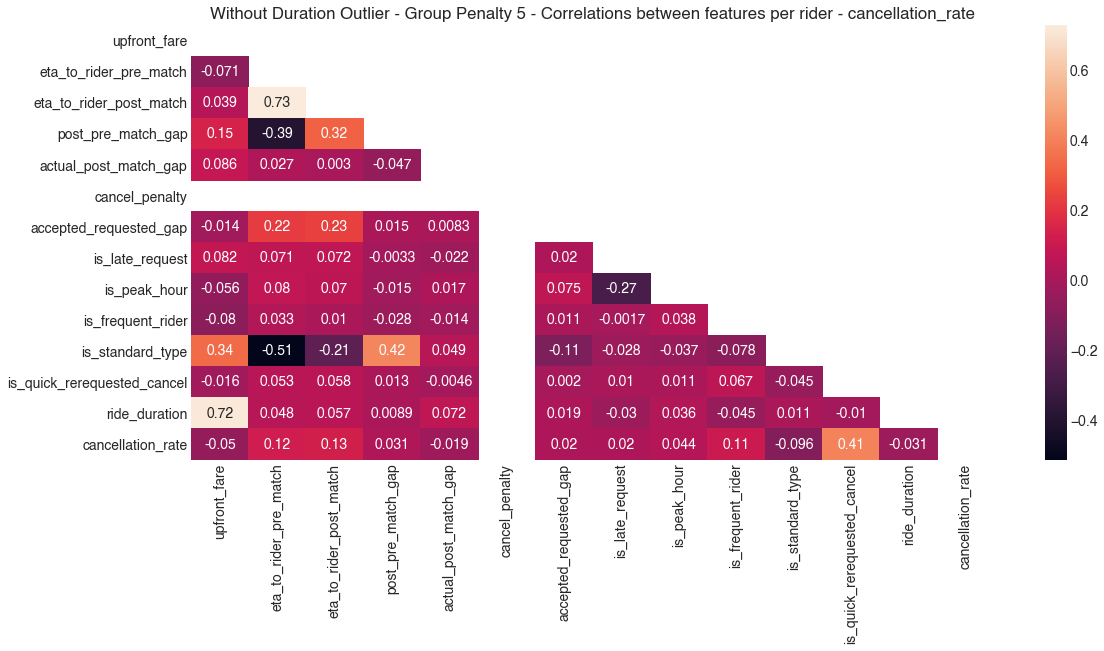

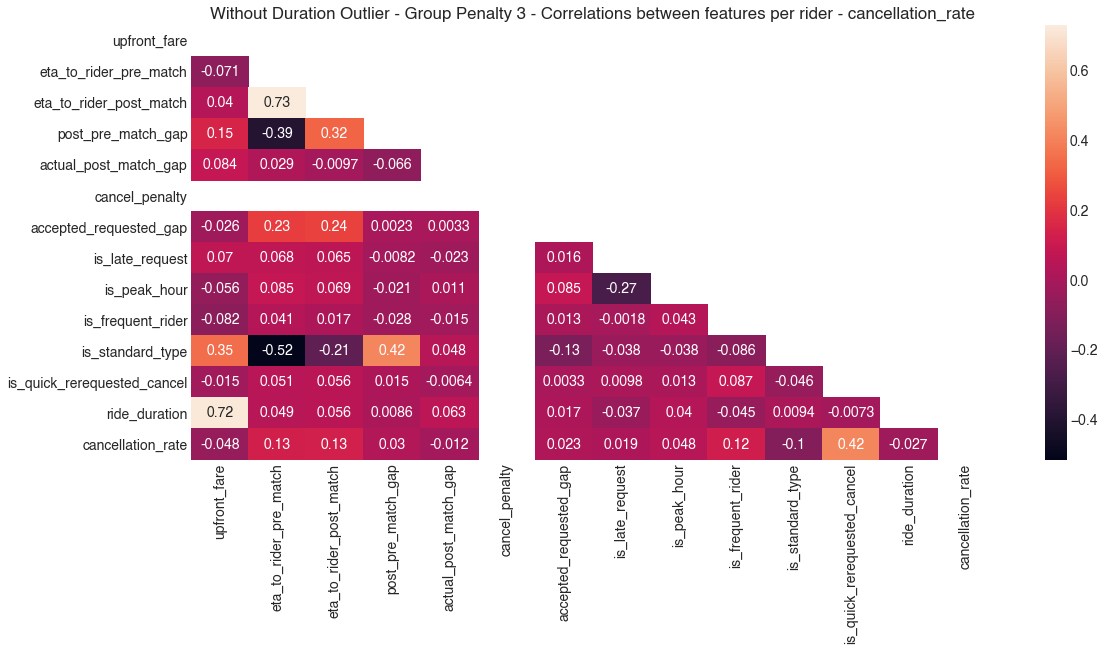

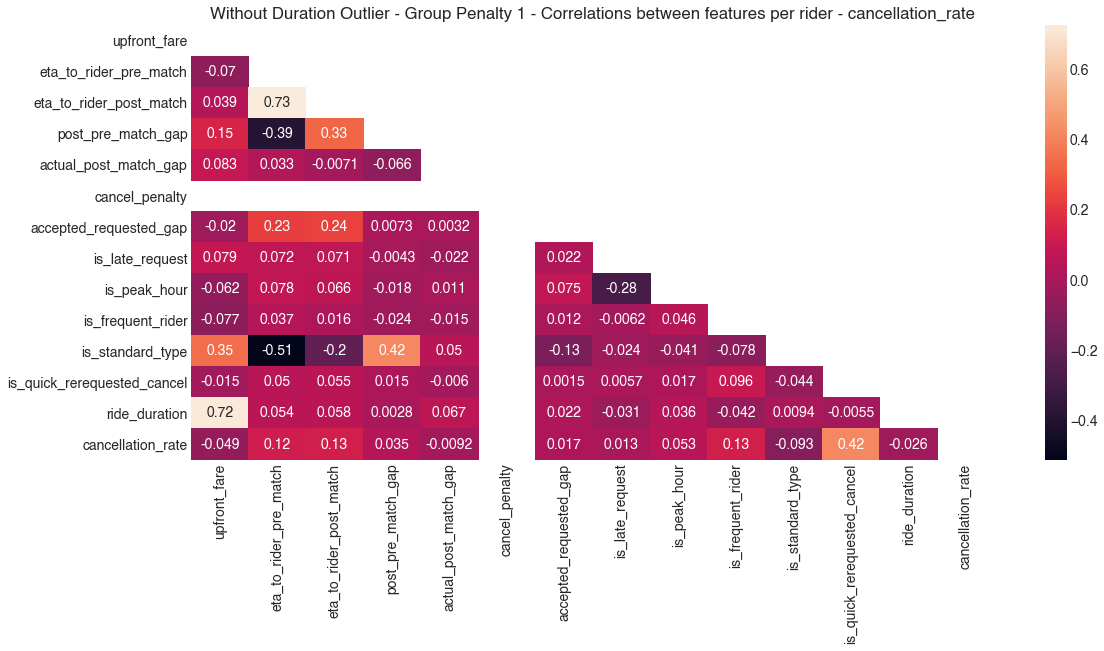

In [ ]:
# Penalty 5,3,1 Group 
# cancellation rate
# corr_plot(df_rider_all, 5, 'cancellation_rate')
# corr_plot(df_rider_all, 3, 'cancellation_rate')
# corr_plot(df_rider_all, 1, 'cancellation_rate')

corr_plot(df_rider_no_outlier, 5, 'cancellation_rate', no_outlier=True)
corr_plot(df_rider_no_outlier, 3, 'cancellation_rate', no_outlier=True)
corr_plot(df_rider_no_outlier, 1, 'cancellation_rate', no_outlier=True)

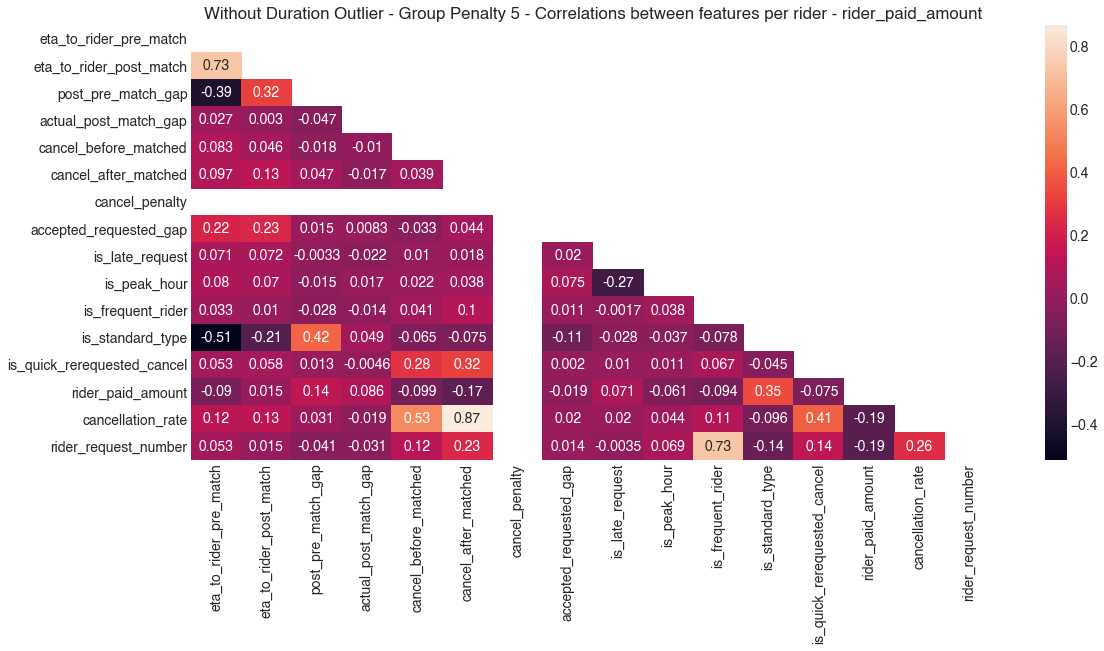

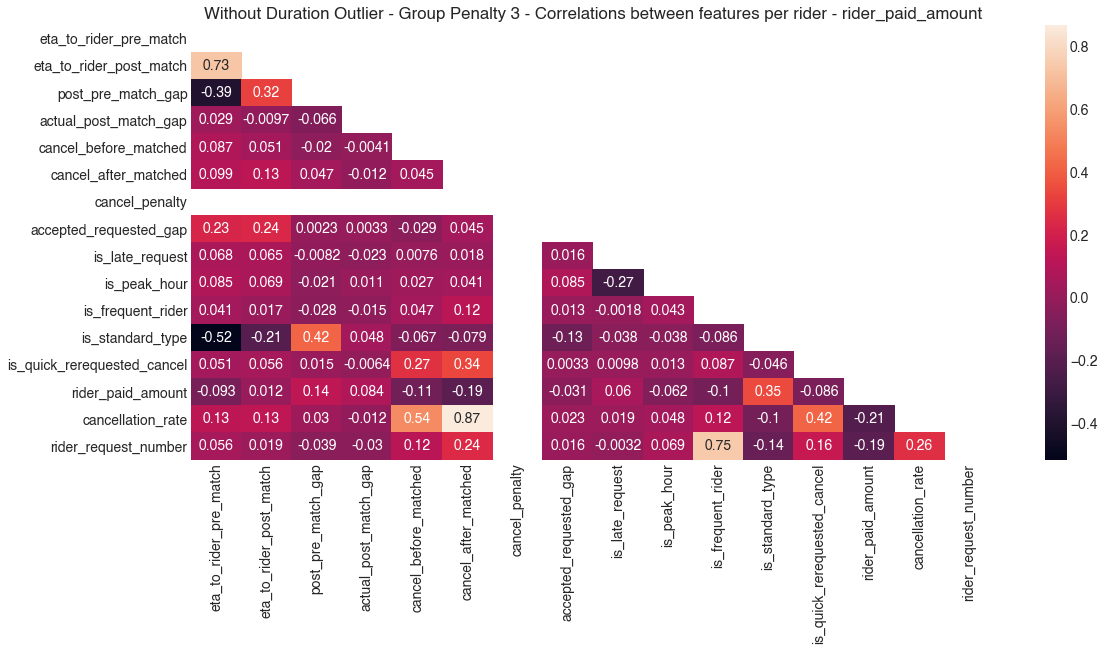

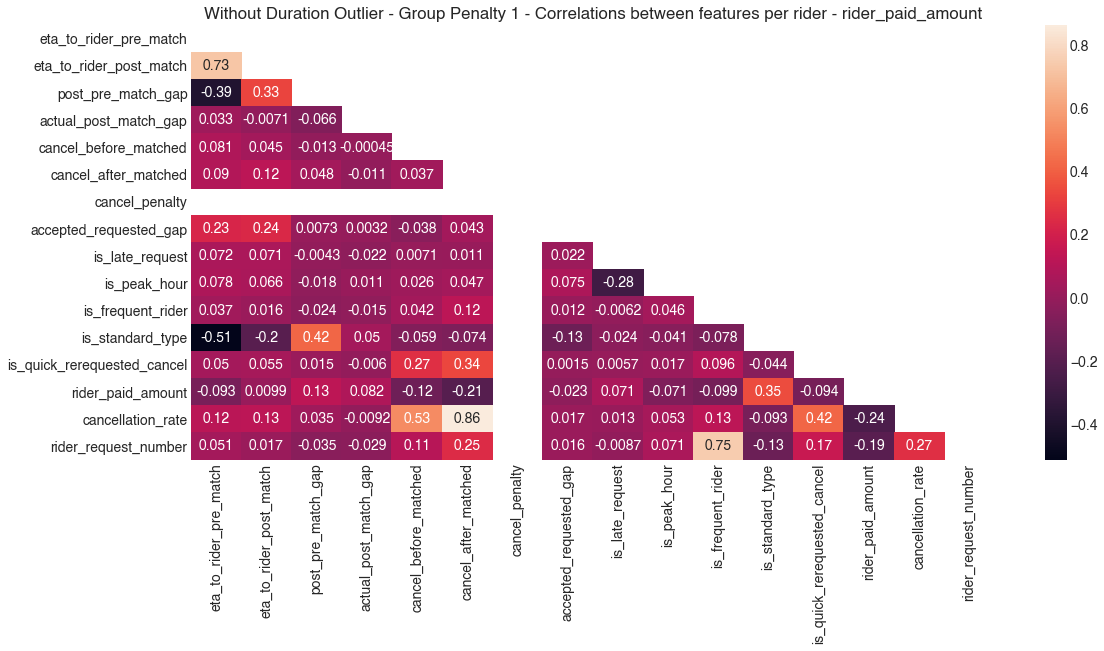

In [ ]:
# Penalty 5,3,1 Group 
# rider paid amount 
# corr_plot(df_rider_all, 5, 'rider_paid_amount')
# corr_plot(df_rider_all, 3, 'rider_paid_amount')
# corr_plot(df_rider_all, 1, 'rider_paid_amount')

corr_plot(df_rider_no_outlier, 5, 'rider_paid_amount', no_outlier=True)
corr_plot(df_rider_no_outlier, 3, 'rider_paid_amount', no_outlier=True)
corr_plot(df_rider_no_outlier, 1, 'rider_paid_amount', no_outlier=True)

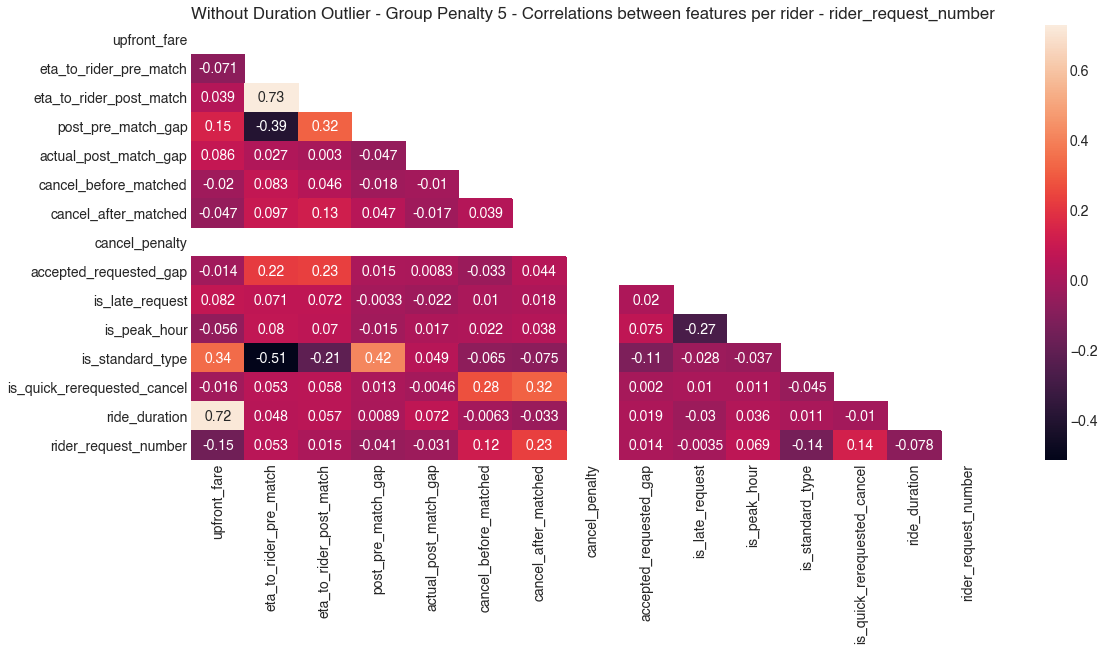

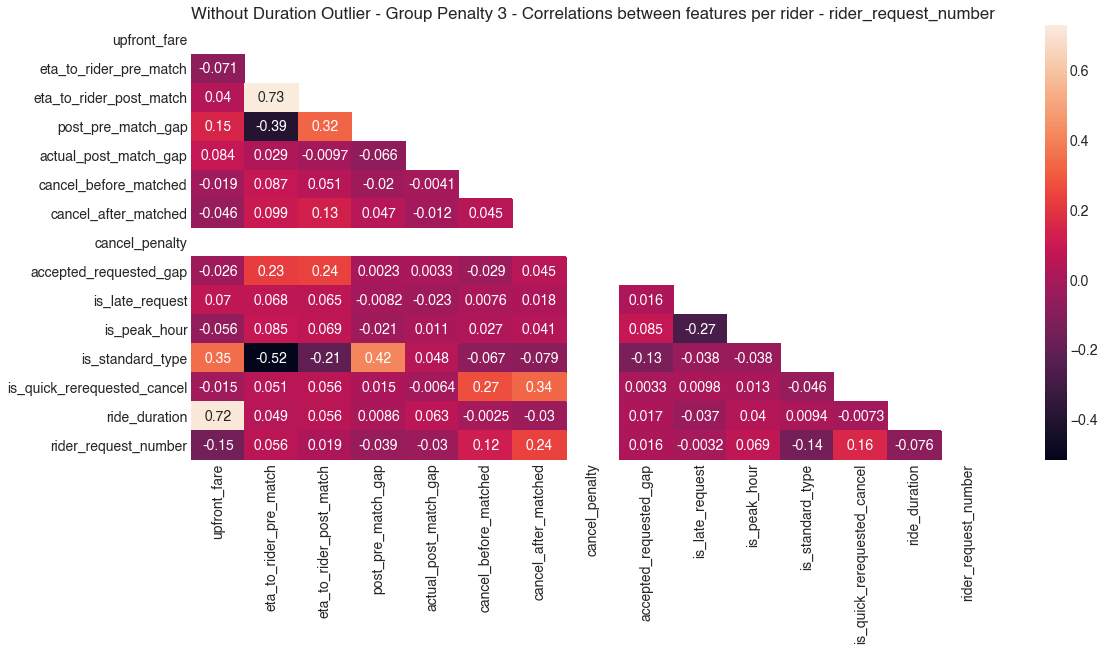

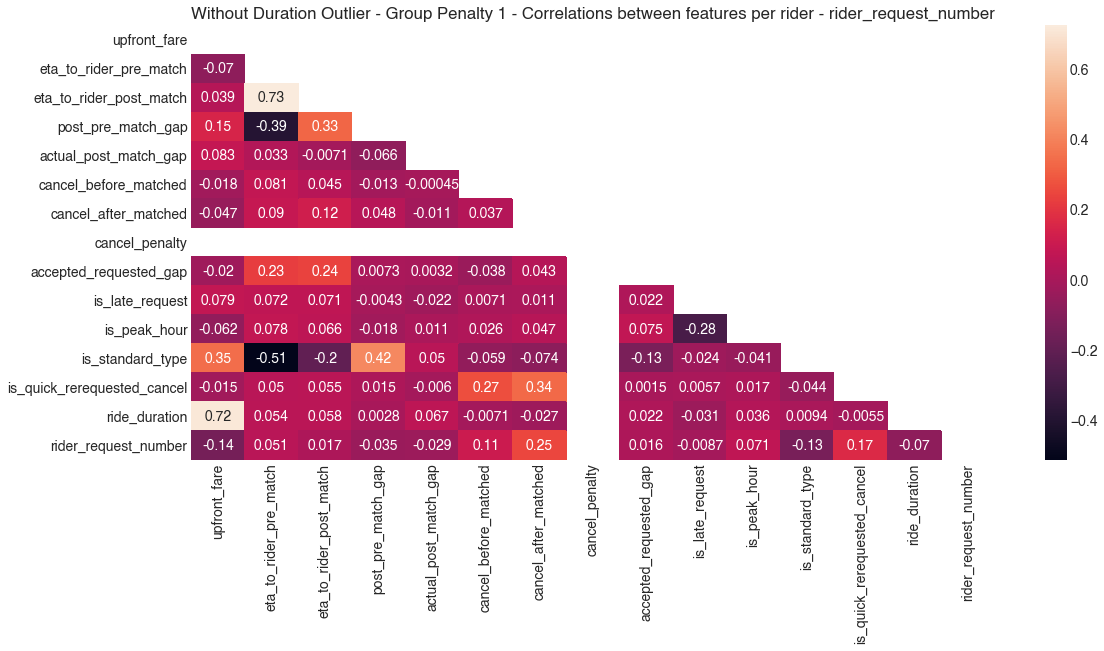

In [ ]:
# Penalty 5,3,1 Group 
# rider_request_number
# corr_plot(df_rider_all, 5, 'rider_paid_amount')
# corr_plot(df_rider_all, 3, 'rider_paid_amount')
# corr_plot(df_rider_all, 1, 'rider_paid_amount')

corr_plot(df_rider_no_outlier, 5, 'rider_request_number', no_outlier=True)
corr_plot(df_rider_no_outlier, 3, 'rider_request_number', no_outlier=True)
corr_plot(df_rider_no_outlier, 1, 'rider_request_number', no_outlier=True)

In [ ]:
df_ride_exp.columns

Index(['ride_id', 'rider_id', 'driver_id', 'ride_type', 'upfront_fare',
       'rider_paid_amount', 'eta_to_rider_pre_match',
       'eta_to_rider_post_match', 'requested_at_local', 'accepted_at_local',
       'arrived_at_local', 'picked_up_at_local', 'dropped_off_at_local',
       'actual_time_to_arrival', 'cancellation_flag', 'rider_request_number',
       'cancel_before_matched', 'cancel_after_matched',
       'accepted_requested_gap', 'variant', 'cancel_penalty',
       'post_pre_match_gap', 'actual_post_match_gap', 'is_standard_type',
       'requested_week', 'is_regular_rider', 'rider_requested_gap',
       'is_quick_rerequested_cancel', 'actual_upfront_fee_gap',
       'is_late_request', 'is_peak_hour', 'ride_duration'],
      dtype='object')

KMeans Clustering

### Hypothesis Test


Assumption of the experiments data:
- Alpha = 0.05
- Adjusted Alpha for pairwise z test (Bonferroni correction) = 0.05 / 3 
- Power = 0.8
- Minimum Detectable Effect = 0.02 (assumed)


Since we don't know if the penalty fee will affect the cancellation for better or worse, we’ll choose a two-tailed test.


In [ ]:
# get the required sample size for each group
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(f"We need at least {required_n} samples for each group.")

We need at least 4720 samples for each group.


In [ ]:
# check on the proportion of 3 groups of variants
pd.crosstab(df_ride_exp['cancel_penalty'], df_ride_exp['cancellation_flag'])

cancellation_flag       0      1
cancel_penalty                  
1.0                381038  88198
3.0                396627  72113
5.0                413308  46051

In [ ]:
df_ride_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1397335 entries, 265252 to 537662
Data columns (total 32 columns):
 #   Column                       Non-Null Count    Dtype          
---  ------                       --------------    -----          
 0   ride_id                      1397335 non-null  object         
 1   rider_id                     1397335 non-null  object         
 2   driver_id                    1362957 non-null  object         
 3   ride_type                    1397335 non-null  object         
 4   upfront_fare                 1397335 non-null  float64        
 5   rider_paid_amount            1397335 non-null  float64        
 6   eta_to_rider_pre_match       1331610 non-null  float64        
 7   eta_to_rider_post_match      1362928 non-null  float64        
 8   requested_at_local           1397335 non-null  datetime64[ns] 
 9   accepted_at_local            1362928 non-null  datetime64[ns] 
 10  arrived_at_local             1189241 non-null  datetime64[ns] 

In [ ]:
df_ride_exp.columns

Index(['ride_id', 'rider_id', 'driver_id', 'ride_type', 'upfront_fare',
       'rider_paid_amount', 'eta_to_rider_pre_match',
       'eta_to_rider_post_match', 'requested_at_local', 'accepted_at_local',
       'arrived_at_local', 'picked_up_at_local', 'dropped_off_at_local',
       'actual_time_to_arrival', 'cancellation_flag', 'rider_request_number',
       'cancel_before_matched', 'cancel_after_matched',
       'accepted_requested_gap', 'variant', 'cancel_penalty',
       'post_pre_match_gap', 'actual_post_match_gap', 'is_standard_type',
       'requested_week', 'is_regular_rider', 'rider_requested_gap',
       'is_quick_rerequested_cancel', 'actual_upfront_fee_gap',
       'is_late_request', 'is_peak_hour', 'ride_duration'],
      dtype='object')

In [ ]:
df_ride_exp['variant'].value_counts()

treatment2    469236
treatment1    468740
control       459359
Name: variant, dtype: int64

We have enough samples 

#### Analyze Experiment Variants 
- Find the average ride request number per variants

In [ ]:
df_ride_exp.columns

Index(['ride_id', 'rider_id', 'driver_id', 'ride_type', 'upfront_fare',
       'rider_paid_amount', 'eta_to_rider_pre_match',
       'eta_to_rider_post_match', 'requested_at_local', 'accepted_at_local',
       'arrived_at_local', 'picked_up_at_local', 'dropped_off_at_local',
       'actual_time_to_arrival', 'cancellation_flag', 'rider_request_number',
       'cancel_before_matched', 'cancel_after_matched',
       'accepted_requested_gap', 'variant', 'cancel_penalty',
       'post_pre_match_gap', 'actual_post_match_gap', 'is_standard_type',
       'requested_week', 'is_regular_rider', 'rider_requested_gap',
       'is_quick_rerequested_cancel', 'actual_upfront_fee_gap',
       'is_late_request', 'is_peak_hour', 'ride_duration'],
      dtype='object')

In [ ]:
'''REMOVE DURATION OUTLIER'''

print("Ride's avg duration stats")
stat_result(df_rider_avg_ride_duration_count_g, 'ride_duration')

df_rider_no_outlier = df_rider_all[(df_rider_all['ride_duration'] > 0) & (df_rider_all['ride_duration'] <= 2393)]

Ride's avg duration stats
Total count: 477,018
Mean: 1080.776499339639
Median: 896.4444444444445
low_outlier: -455.0
high_outlier: 2393.0
Below lower quartile count: 119,525
Above higher quartile count: 119,263
Lower outlier count: 0
Higher outlier count: 25,671
Percentage higher outlier: 0.502%


rider_id  cancellation_rate  upfront_fare  \
51520   Ojdflb45wpmD5B31JRQFMg==           0.967033     26.013846   
51521   Fd1xwngfA83HxlWnlVdtmQ==           0.954545      7.184545   
51522   UEXhikVEn1sbC9YVZInqjg==           0.950000     15.395167   
51523   Xy/cmQHKdcEmq/xgvbWqMA==           0.947368     10.082632   
51524   o2tPXTJl7DcV4FoAR+0T2g==           0.941176     10.849294   
...                          ...                ...           ...   
529079  LySCoqxKMTsPFb6wnbylWQ==           0.000000      6.840000   
529080  LyRcdTn9vrUhiD0IRanB+A==           0.000000     12.700000   
529081  LyRWq+Rpb4DqHhfptIepCw==           0.000000     10.925000   
529082  LyRJFEo5uYLUWwIGay7Quw==           0.000000     10.840000   
529083  zzzhpNF1l7HdwyBef3huRw==           0.000000      7.055000   

        eta_to_rider_pre_match  eta_to_rider_post_match  post_pre_match_gap  \
51520               160.666667               256.733333           96.235955   
51521               919.300000              1044.071429           92.769231   
51522               112.000000               158.700000           46.700000   
51523               116.421053               161.105263           44.684211   
51524               370.847059               457.329412           86.482353   
...                        ...                      ...                 ...   
529079              491.000000               358.000000         -133.000000   
529080               60.000000               113.000000           53.000000   
529081              135.000000               122.000000          -13.000000   
529082              180.000000               264.000000           84.000000   
529083              360.000000               185.500000         -174.500000   

        actual_post_match_gap  cancel_before_matched  cancel_after_matched  \
51520               47.333333               0.010989              0.956044   
51521             -112.000000               0.363636              0.590909   
51522              -10.666667               0.000000              0.950000   
51523              -73.000000               0.000000              0.947368   
51524              128.800000               0.000000              0.941176   
...                       ...                    ...                   ...   
529079              71.000000               0.000000              0.000000   
529080             401.000000               0.000000              0.000000   
529081              12.750000               0.000000              0.000000   
529082             -78.000000               0.000000              0.000000   
529083             127.500000               0.000000              0.000000   

        cancel_penalty  accepted_requested_gap  is_late_request  is_peak_hour  \
51520              3.0               16.065934         0.153846      0.131868   
51521              3.0               62.636364         0.636364      0.181818   
51522              1.0               16.900000         0.366667      0.000000   
51523              5.0               13.421053         0.947368      0.000000   
51524              3.0               18.952941         0.058824      0.188235   
...                ...                     ...              ...           ...   
529079             3.0               23.000000         0.000000      0.000000   
529080             3.0               11.000000         0.000000      0.000000   
529081             5.0               14.000000         0.250000      0.000000   
529082             5.0               20.000000         0.000000      0.000000   
529083             3.0               15.500000         0.000000      1.000000   

        is_frequent_rider  is_standard_type  is_quick_rerequested_cancel  \
51520                   0          1.000000                     0.615385   
51521                   0          0.136364                     0.272727   
51522                   1          1.000000                     0.700000   
51523                   0       

In [ ]:
df_ride_exp[['variant', 'cancel_penalty']].value_counts().reset_index().rename(columns={0: 'ride_count'})

variant  cancel_penalty  ride_count
0  treatment2             1.0      469236
1  treatment1             3.0      468740
2     control             5.0      459359

In [ ]:
# split into different variants
df_treatment2 = df_ride_exp[df_ride_exp['variant']=='treatment2']
df_treatment1 = df_ride_exp[df_ride_exp['variant']=='treatment1']
df_control = df_ride_exp[df_ride_exp['variant']=='control']


In [ ]:
# treatment2  1.0, average rider_request_number
treatment2_rider_avg_request = df_treatment2.groupby('rider_id')['rider_request_number'].max().reset_index()['rider_request_number'].mean()
print(f"Treatment 2's mean rider request number : {treatment2_rider_avg_request:.2f}")

Treatment 2's mean rider request number : 2.66


In [ ]:
# treatment1  3.0  

treatment1_rider_avg_request = df_treatment1.groupby('rider_id')['rider_request_number'].max().reset_index()['rider_request_number'].mean()
print(f"Treatment 1's mean rider request number : {treatment1_rider_avg_request:.2f}")

Treatment 1's mean rider request number : 2.66


In [ ]:
# control     5.0   
control_rider_avg_request = df_treatment1.groupby('rider_id')['rider_request_number'].max().reset_index()['rider_request_number'].mean()
print(f"Control's mean rider request number : {control_rider_avg_request:.2f}")

Control's mean rider request number : 2.66


Observation: 
- Same average rider request number among all experiment groups


How about we filter out the one time rider?

In [ ]:
df_ride_exp['ride_id'].count()

1397335

In [ ]:
max_ride_request_range = list(set(df_ride_exp.groupby('rider_id')['rider_request_number'].max().values))

In [ ]:
# find out the count of different max rider request number
# {max_rider_request_number : count}
def x_time_rider(x, xtime_count:dict, xtime_cancelcount:dict):
    
    print(f"Checking {x} time riders percentage")
    x_time_rider_id = df_ride_exp.groupby('rider_id')['rider_request_number'].max()[df_ride_exp.groupby('rider_id')['rider_request_number'].max()==x].reset_index()['rider_id']

    df_x_time_rider = df_ride_exp[df_ride_exp['rider_id'].isin(x_time_rider_id)]
    x_time_count = df_x_time_rider['ride_id'].nunique()

    # check how many x time rider actually cancelled

    df_x_time_cancelled = df_x_time_rider[df_x_time_rider['cancellation_flag']==1]
    x_time_cancelled_count = df_x_time_cancelled['ride_id'].nunique()

    # total ride request count 
    total_ride_count = df_ride_exp['ride_id'].nunique()
    
    # update dictionary
    xtime_count[x] = x_time_count
    xtime_cancelcount[x] = x_time_cancelled_count

    return xtime_count, xtime_cancelcount

In [ ]:
# xtime_count = {}
# xtime_cancelcount = {}
# for i in max_ride_request_range:
#     xtime_count, xtime_cancelcount = x_time_rider(i, xtime_count, xtime_cancelcount)
# xtime_count

# df_xtime_count = pd.DataFrame({
#     'xtime_rider': xtime_count.keys(),
#     'rider_count': xtime_count.values()
#     })
# df_xtime_cancelcount = pd.DataFrame({
#     'xtime_rider': xtime_cancelcount.keys(),
#     'cancelled_count': xtime_cancelcount.values()
#     })
# df_xtime_count

In [ ]:
# check point
df_ride_exp[df_ride_exp['rider_id']=='++07zTPYFhvA5Ug72kRd0w==']

ride_id                  rider_id  \
1083825  JwACfbilNJG1WIH5meqY/A==  ++07zTPYFhvA5Ug72kRd0w==   
1083826  MXUBhCnXvV4tiimvuSuP1g==  ++07zTPYFhvA5Ug72kRd0w==   

                        driver_id ride_type  upfront_fare  rider_paid_amount  \
1083825  NosKHZuI8QjmRNhgJ4jPjQ==    shared          7.68               7.71   
1083826  5gjyvf7FJVkNnVogWQQeUA==    shared          7.38               7.41   

         eta_to_rider_pre_match  eta_to_rider_post_match  requested_at_local  \
1083825                   270.0                    303.0 2019-04-23 17:44:47   
1083826                   221.0                     83.0 2019-05-20 15:04:52   

              accepted_at_local  ... actual_post_match_gap is_standard_type  \
1083825 2019-04-23 17:44:53.077  ...                  44.0                0   
1083826 2019-05-20 15:05:23.566  ...                 -55.0                0   

        requested_week  is_regular_rider  rider_requested_gap  \
1083825             17                 0                  NaT   
1083826             21                 0     26 days 21:20:05   

         is_quick_rerequested_cancel  actual_upfront_fee_gap  is_late_request  \
1083825                            0                    0.03                0   
1083826                            0                    0.03                0   

         is_peak_hour ride_duration  
1083825             1        1362.0  
1083826             0        1101.0  

[2 rows x 32 columns]

In [ ]:
# one time rider sample

one_time_rider_id = df_ride_exp.groupby('rider_id')['rider_request_number'].max()[df_ride_exp.groupby('rider_id')['rider_request_number'].max()==1].reset_index()['rider_id']

df_one_time_rider = df_ride_exp[df_ride_exp['rider_id'].isin(one_time_rider_id)]
one_time_count = df_one_time_rider['ride_id'].nunique()

0         +++3990cLNPGgaPm+ripGg==
1         +++stf7DqWcT8LMTYbXrwA==
2         ++0YwCvnfyMWSNH3wpyP1g==
3         ++0ueqZlVFEuOw7nsdyG4A==
4         ++1hNPNAMjJz6NwsrH8UCQ==
                    ...           
270756    zzw4Ctqgf818aSNnB+F4hg==
270757    zzwWmGi2+tZcYzssbjEj+w==
270758    zzxF80GXwRzlsjwhllyCIA==
270759    zzxZU/e6hKC1DFRoPJFlKw==
270760    zzxfsWIdNc6mohXYAJ6lig==
Name: rider_id, Length: 270761, dtype: object

In [ ]:
# unique riders count where only requested once
unique_rider_id = df_ride_exp['rider_id'].unique()
df_ride_exp.groupby('rider_id')['rider_request_number'].max()[df_ride_exp.groupby('rider_id')['rider_request_number'].max() == 1]

rider_id
+++3990cLNPGgaPm+ripGg==    1
+++stf7DqWcT8LMTYbXrwA==    1
++0YwCvnfyMWSNH3wpyP1g==    1
++0ueqZlVFEuOw7nsdyG4A==    1
++1hNPNAMjJz6NwsrH8UCQ==    1
                           ..
zzw4Ctqgf818aSNnB+F4hg==    1
zzwWmGi2+tZcYzssbjEj+w==    1
zzxF80GXwRzlsjwhllyCIA==    1
zzxZU/e6hKC1DFRoPJFlKw==    1
zzxfsWIdNc6mohXYAJ6lig==    1
Name: rider_request_number, Length: 270761, dtype: int64

In [ ]:
# check point
check_columns = ['ride_id', 'rider_id', 'rider_request_number', 'cancellation_flag']
df_ride_exp[df_ride_exp['rider_id']=='+++3990cLNPGgaPm+ripGg=='][['ride_id', 'rider_id', 'rider_request_number', 'cancellation_flag']]

ride_id                  rider_id  \
265252  I9+8q9h67J5XL7x+X2flrA==  +++3990cLNPGgaPm+ripGg==   

        rider_request_number  cancellation_flag  
265252                     1                  0

In [ ]:
# check how many 1 time rider actually cancelled

df_one_time_cancelled = df_one_time_rider[df_one_time_rider['cancellation_flag']==1]
one_time_cancelled_count = df_one_time_cancelled['ride_id'].count()

ride_id                  rider_id  \
855751   FcDOAnNo5aTeYKG1iTyxSA==  +++stf7DqWcT8LMTYbXrwA==   
229866   LUT3fp53LtWH/U56zfc+6g==  ++HJ9WV9oDnBzaJmgpGH6g==   
1156689  BANjN2aodWQ2vfV5FwXQ3Q==  ++P5AmrwdTZMY5edtssA7A==   
1006264  MFrgAlTjzPXsf1uH3HZm+w==  ++TUfAcn7nJdkTUKTf7W4g==   
914802   KVCEnxVUdrnns2mjiE7bQg==  ++ZKsvPFIQPwrfdrI86Y1A==   
...                           ...                       ...   
925739   KvuSDA9HTq2DS81Ep/CEeA==  zzgkzHHBJSpzZ71q072ERQ==   
855129   BcOa6OFWG+qLfSm0J3yung==  zzlFSt/eafRA0OcEfvG8SQ==   
1130349  M6sjWjVVtz4K9zMWTIjNdA==  zzp3q9z4jiGzIWIBfb79Hw==   
22242    F8YjI+c6uT1i/sy4zMHXpQ==  zzw4Ctqgf818aSNnB+F4hg==   
1154759  PvAMY27ZACDTvjpFag+43A==  zzxF80GXwRzlsjwhllyCIA==   

                        driver_id ride_type  upfront_fare  rider_paid_amount  \
855751   OmB5LM8HAb8y1AtLA/trSg==  standard          7.46                5.0   
229866   WYqf4VJKBzRXtJY+SgB5og==  standard          7.34                3.0   
1156689  dw4wOgBq5gWoPaP5Xbz1jQ==  standard          8.64                1.0   
1006264  seulMqrffl/PIBN5GXEAQA==    shared         14.60                1.0   
914802   SIRFvplAPVDFAswgRj5G4A==  standard         14.47                3.0   
...                           ...       ...           ...                ...   
925739   bjiWPnBAnaKUpkYTdNViyQ==    shared          8.33                5.0   
855129   q331BjmMF2Atp2JOQ4Cqeg==    shared         20.91                5.0   
1130349  wC1dg9TB60z8sOpW1bZV0g==  standard         42.93                3.0   
22242    /aC2VBXSKgLTTJljBxS53A==  standard         14.70                1.0   
1154759  5CjzRx1/pb5vgXVAuSfDzQ==  standard          8.00                3.0   

         eta_to_rider_pre_match  eta_to_rider_post_match  requested_at_local  \
855751                     60.0                    160.0 2019-05-18 01:23:50   
229866                    360.0                    831.0 2019-04-21 05:32:47   
1156689                   120.0                    164.0 2019-05-05 18:38:07   
1006264                   400.0                    297.0 2019-05-02 05:42:45   
914802                    120.0                    170.0 2019-05-07 17:09:47   
...                         ...                      ...                 ...   
925739                    221.0                    264.0 2019-04-28 15:18:59   
855129                    244.0                    115.0 2019-05-24 20:26:05   
1130349                     NaN                    243.0 2019-05-01 10:17:56   
22242                     540.0                    224.0 2019-04-26 17:54:33   
1154759                   120.0                    165.0 2019-04-18 09:22:27   

              accepted_at_local  ... actual_post_match_gap is_standard_type  \
855751  2019-05-18 01:23:58.419  ...                   NaN                1   
229866  2019-04-21 05:33:19.726  ...                   NaN                1   
1156689 2019-05-05 18:38:18.944  ...                   NaN                1   
1006264 2019-05-02 05:43:19.604  ...                   NaN                0   
914802  2019-05-07 17:09:54.035  ...                   NaN                1   
...                         ...  ...                   ...              ...   
925739  2019-04-28 15:19:10.447  ...                   NaN                0   
855129  2019-05-24 20:26:23.551  ...                   NaN                0   
1130349 2019-05-01 10:18:01.146  ...                   NaN                1   
22242   2019-04-26 17:55:44.043  ...                   NaN                1   
1154759 2019-04-18 09:22:40.463  ...                   NaN                1   

        requested_week  is_regular_rider  rider_requested_gap  \
855751              20                 0                  NaT   
229866              16                 0                  NaT   
1156689             18                 0                  NaT   
1006264             18                 0                  NaT   
914802              19                 0                  NaT   
...     

In [ ]:
print(f"one_time_cancelled_count : {one_time_cancelled_count}")

33959

In [ ]:
# find rider count with 100% cancellation rate
hundred_cancel_rate_riders = len(df_ride_exp.groupby('rider_id')['cancellation_flag'].mean()[df_ride_exp.groupby('rider_id')['cancellation_flag'].mean()==1])

ninty_above_cancel_rate_riders = len(df_ride_exp.groupby('rider_id')['cancellation_flag'].mean()[df_ride_exp.groupby('rider_id')['cancellation_flag'].mean()>=0.9])

Text(0.5, 1.0, '100% Cancellation Rate Riders - One request vs multiple request')

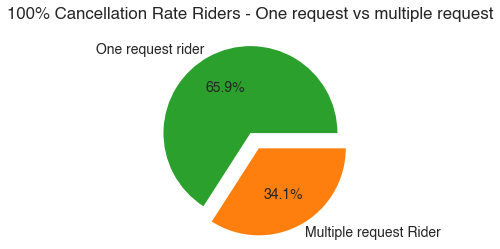

In [ ]:
non_one_time_hundred_cancelled_count = hundred_cancel_rate_riders - one_time_cancelled_count
labels=['One request rider', 'Multiple request Rider']
x=[one_time_cancelled_count, non_one_time_hundred_cancelled_count]
explode=[0, 0.2]
plt.pie(labels=labels, x=x, explode=explode, autopct='%1.1f%%', colors=['tab:green', 'tab:orange'])
plt.title("100% Cancellation Rate Riders - One request vs multiple request")

Text(0.5, 1.0, '100% Cancellation Rate Riders - One request vs multiple request')

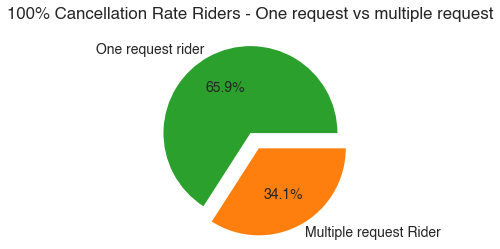

In [ ]:
non_one_time_hundred_cancelled_count = hundred_cancel_rate_riders - one_time_cancelled_count
labels=['One request rider', 'Multiple request Rider']
x=[one_time_cancelled_count, non_one_time_hundred_cancelled_count]
explode=[0, 0.2]
plt.pie(labels=labels, x=x, explode=explode, autopct='%1.1f%%', colors=['tab:green', 'tab:orange'])
plt.title("100% Cancellation Rate Riders - One request vs multiple request")

In [ ]:
print(f"percentage of one time ride that are cancelled out of all rides: {(one_time_cancelled_count / df_ride_exp['ride_id'].count())*100:.2f}%")
print(f"percentage of one time ride out of all rides : {(one_time_count / df_ride_exp['ride_id'].count())*100:.2f}%")
print(f"percentage of cancelled out of one time rides : {(one_time_cancelled_count / one_time_count)*100:.2f}%")
print(f"percentage of 1 time requester out of 100% cancellation rider : {(one_time_cancelled_count / hundred_cancel_rate_riders)*100:.2f}%")

percentage of one time ride that are cancelled out of all rides: 2.43%
percentage of one time ride out of all rides : 19.38%
percentage of cancelled out of one time rides : 12.54%
percentage of 1 time requester out of 100% cancellation rider : 65.91%


In [ ]:
# control 5
df_penalty_5_rider = df_rider_all[df_rider_all['cancel_penalty'] == 5]

# treatment2 1
df_penalty_1_rider = df_rider_all[df_rider_all['cancel_penalty'] == 1]

# treatment1 3
df_penalty_3_rider = df_rider_all[df_rider_all['cancel_penalty'] == 3]


In [ ]:
# average ride revenue per rider for each group
penalty_5_avg_rider_revenue = df_penalty_5_rider['rider_paid_amount'].mean()
penalty_1_avg_rider_revenue = df_penalty_1_rider['rider_paid_amount'].mean()
penalty_3_avg_rider_revenue = df_penalty_3_rider['rider_paid_amount'].mean()

In [ ]:
# average rider cancellation rate for each group
penalty_5_avg_cancel_rate = df_penalty_5_rider['cancellation_rate'].mean()
penalty_1_avg_cancel_rate = df_penalty_1_rider['cancellation_rate'].mean()
penalty_3_avg_cancel_rate = df_penalty_3_rider['cancellation_rate'].mean()

In [ ]:
print(f"penalty_1_avg_rider_revenue: {penalty_1_avg_rider_revenue}")

14.780093720029768

In [ ]:
print(f"penalty_3_avg_rider_revenue: {penalty_3_avg_rider_revenue}")

15.643125371133522

In [ ]:
print(f"penalty_5_avg_rider_revenue: {penalty_5_avg_rider_revenue}")

16.673785281982802

Text(0, 0.5, 'Average ride revenue per rider')

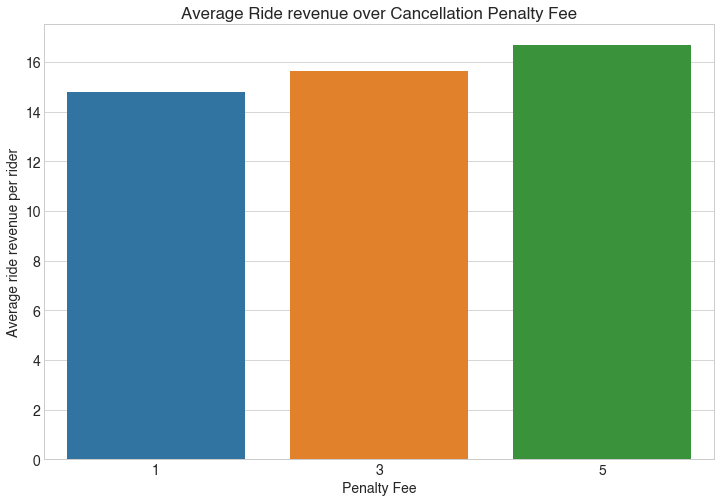

In [ ]:
# plot average rider revenue
# plot cancellatino rate over group
x=[1,3,5]
y=np.array([penalty_1_avg_rider_revenue, penalty_3_avg_rider_revenue, penalty_5_avg_rider_revenue])
plt.figure(figsize=(12,8))
sns.barplot(x=x, y=y)
plt.title("Average Ride revenue over Cancellation Penalty Fee")
plt.xlabel("Penalty Fee")
plt.ylabel("Average ride revenue per rider")


Text(0.5, 1.0, 'Average ride revenue for Penalty $5 riders')

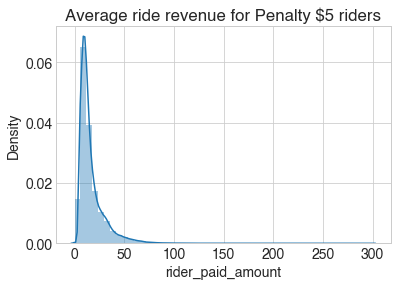

In [ ]:
sns.distplot(df_penalty_5_rider['rider_paid_amount'])
plt.title("Average ride revenue for Penalty $5 riders")

Text(0.5, 1.0, 'Average ride revenue for Penalty $3 riders')

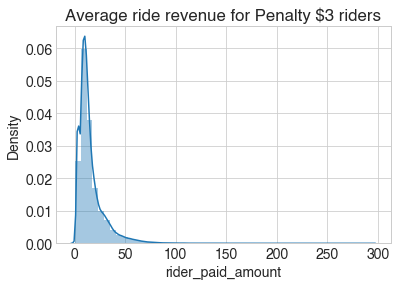

In [ ]:
sns.distplot(df_penalty_3_rider['rider_paid_amount'])
plt.title("Average ride revenue for Penalty $3 riders")

Text(0.5, 1.0, 'Average ride revenue for Penalty $1 riders')

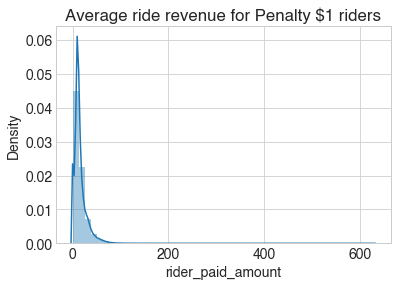

In [ ]:
sns.distplot(df_penalty_1_rider['rider_paid_amount'])
plt.title("Average ride revenue for Penalty $1 riders")

Not much of a difference in the average ride revenues among groups

In [ ]:
#cancellation_rate
penalty_5_avg_cancel_rate

0.08779416375230391

Text(0.5, 0, 'Rider Cancellation Rate')

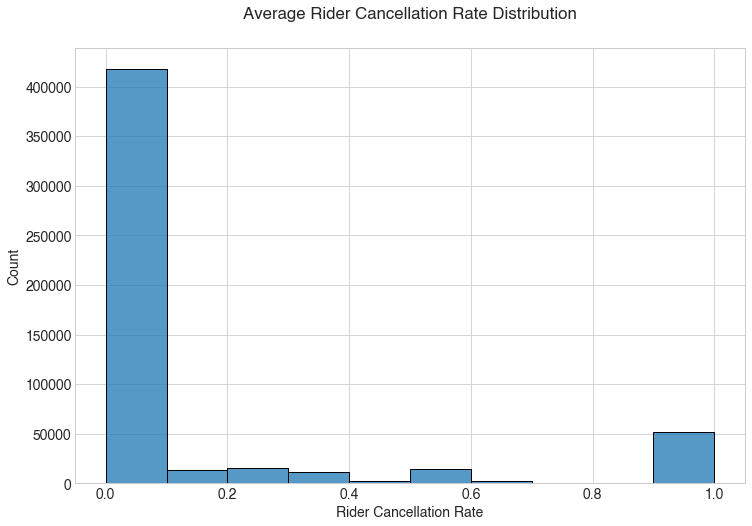

In [ ]:
# penalty 5 group
# cancellation rate per rider
plt.figure(figsize=(12,8))
bins = [i/10 for i in range(11)]
sns.histplot(df_rider_all['cancellation_rate'], bins=bins)
plt.title("Average Rider Cancellation Rate Distribution", pad=30)
plt.xlabel("Rider Cancellation Rate")

In [ ]:
# one_time_cancel_5_count = df_one_time_cancelled[df_one_time_cancelled['cancel_penalty']==5]['rider_id'].nunique()
# one_time_cancel_5_count
one_time_cancelled_count

33959

In [ ]:
# df_penalty_5_rider['cancellation_rate'].value_counts(bins=10)


# plot cancellation rate from 0.1 to 1.0
cumulative_cancel_rate_count = {}
for i in range(1, 11):
    rate = i /10.0
    cum_rate_count = df_rider_all[df_rider_all['cancellation_rate'] <= rate]['rider_id'].nunique()
    if rate == 1.0:
        count = cum_rate_count - one_time_cancelled_count
    else:
        count = cum_rate_count
    cumulative_cancel_rate_count[rate] = count

rate_cum = pd.Series(data=cumulative_cancel_rate_count, index=cumulative_cancel_rate_count.keys())
rate_cum

0.1    418777
0.2    436107
0.3    446461
0.4    459158
0.5    474354
0.6    474993
0.7    476927
0.8    477459
0.9    477548
1.0    495125
dtype: int64

(0.0, 498942.4)

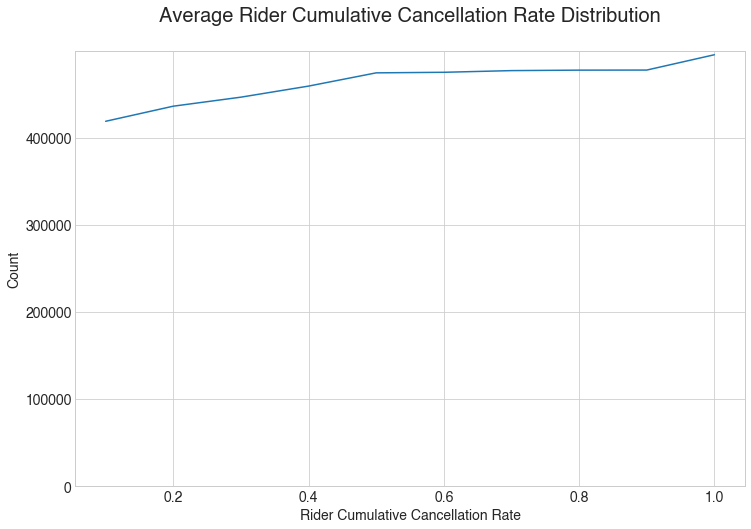

In [ ]:
#cumulative plot
plt.figure(figsize=(12,8))

sns.lineplot(x=rate_cum.index, y=rate_cum.values)
plt.title("Average Rider Cumulative Cancellation Rate Distribution", pad=30, size=20 )
plt.ylabel("Count")
plt.xlabel("Rider Cumulative Cancellation Rate")
plt.ylim(0, None)


In [ ]:
# get riders that have at least 3 rides in total
at_least_threshold = 3
df_rider_count = df_ride_exp.groupby('rider_id')['ride_id'].count().reset_index()

df_rider_atleast_rides = df_rider_count[df_rider_count['ride_id'] >= at_least_threshold]
df_rider_atleast_rides

rider_id  ride_id
3       ++08hetKFBNoOO5XHAH/5A==       11
5       ++0bPPtI4KaXB8Cu7ByDMg==        9
9       ++23cjRT/n4usa6HOUPKPQ==        4
12      ++40TlM02/xdfTR8vXWHZQ==        4
13      ++4T4lo25J4TG9rjjaLaRQ==        3
...                          ...      ...
529063  zzsiF9JAFqR7JM9bjQzaiQ==        5
529064  zzt2alkZygjPy1Nc4hEuqQ==        3
529069  zzuDfF1XlmVCSZx5Gw7Yrw==        8
529070  zzugxEVCDaVaqWh8DoVemg==        4
529077  zzwS6BPSfPSJhjtpoI3cbw==        8

[156609 rows x 2 columns]

Text(0.5, 1.0, 'Cancellation Rate above and below 50%')

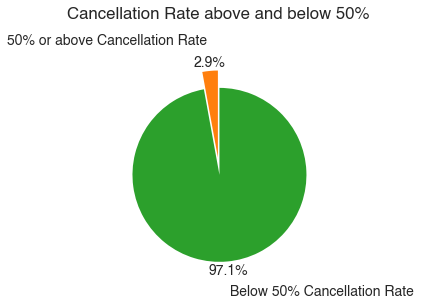

In [ ]:
# rider count that's above certain cancel rate
threshold = 0.5
above_fifty_cancel_count = df_rider_all[(df_rider_all['cancellation_rate'] >= threshold) & df_rider_all['rider_id'].isin(df_rider_atleast_rides['rider_id'])]['rider_id'].nunique()
rest_count = df_rider_all['rider_id'].nunique() - above_fifty_cancel_count
# pie chart

sizes = [above_fifty_cancel_count, rest_count]
labels = [f'{threshold:1.0%} or above Cancellation Rate', f'Below {threshold:1.0%} Cancellation Rate']
explode = [0, 0.2]
colors=['tab:orange', 'tab:green']


plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', pctdistance=1.1, labeldistance=1.35, startangle=90, colors=colors)
plt.title(f"Cancellation Rate above and below {threshold:1.0%}", pad=30)

In [ ]:
penalty_3_avg_cancel_rate

0.14327662047530748

In [ ]:
penalty_1_avg_cancel_rate

0.17394794171846567

Text(0, 0.5, 'Average Cancellation rate %')

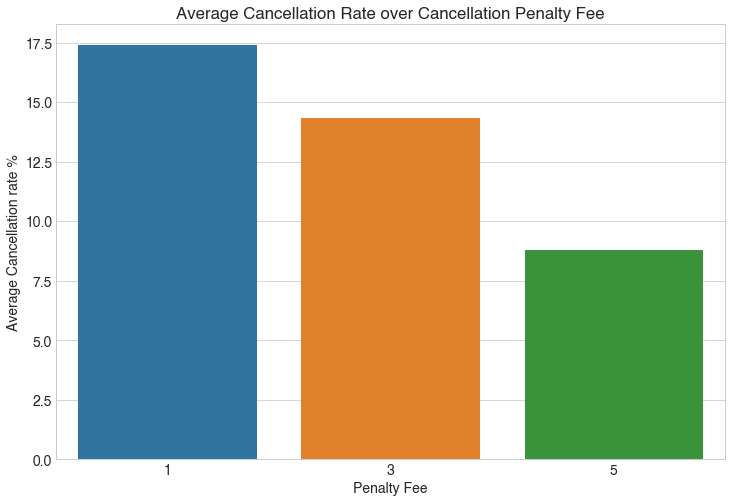

In [ ]:
# plot cancellatino rate over group
x=[1,3,5]
y=np.array([penalty_1_avg_cancel_rate, penalty_3_avg_cancel_rate, penalty_5_avg_cancel_rate])*100
plt.figure(figsize=(12,8))
sns.barplot(x=x, y=y)
plt.title("Average Cancellation Rate over Cancellation Penalty Fee")
plt.xlabel("Penalty Fee")
plt.ylabel("Average Cancellation rate %")

In [ ]:
penalty_5_avg_request_number = df_penalty_5_rider['rider_request_number'].mean()
penalty_3_avg_request_number = df_penalty_3_rider['rider_request_number'].mean()
penalty_1_avg_request_number = df_penalty_1_rider['rider_request_number'].mean()

In [ ]:
penalty_5_avg_request_number

2.6099067519738632

In [ ]:
penalty_3_avg_request_number

2.6625328887679185

In [ ]:
penalty_1_avg_request_number

2.66403291994468

Text(0, 0.5, 'Average Request Number per rider')

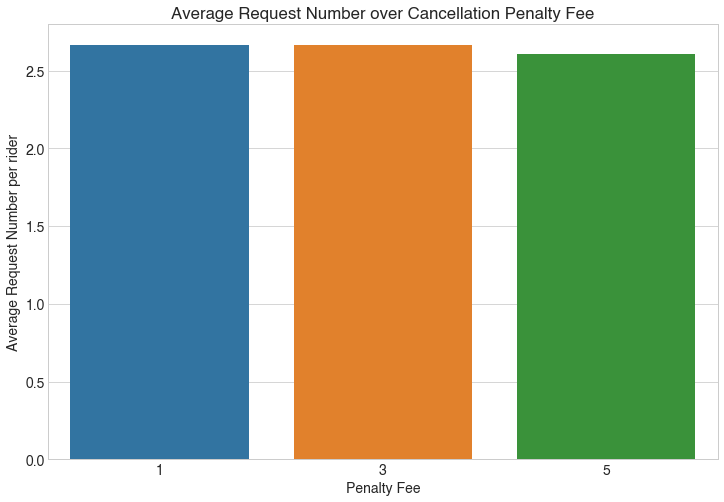

In [ ]:
# plot avg request number over group
x=[1,3,5]
y=[penalty_1_avg_request_number, penalty_3_avg_request_number, penalty_5_avg_request_number]
plt.figure(figsize=(12,8))
sns.barplot(x=x, y=y)
plt.title("Average Request Number over Cancellation Penalty Fee")
plt.xlabel("Penalty Fee")
plt.ylabel("Average Request Number per rider")


### Statistical Test 

#### Random Sampling

For cancellation Rate
Assume power = 0.8, alpha = 0.05, 

effective size = 0.1 - mean of cancellation rate for control (fee=5) 

= 0.012205836247696097

In [ ]:
# cancellation_rate
# get the required sample size for each group
penalty_5_avg_cancel_rate
effect_size = sms.proportion_effectsize(penalty_5_avg_cancel_rate, 0.1)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(f"We need at least {required_n} samples for each group for cancellation rate.")

We need at least 8956 samples for each group for cancellation rate.


In [ ]:
import random
# random.seed(30)
random.seed(20)
rider_id_list = list(df_rider_all['rider_id'].unique())
sample_riders = random.sample(rider_id_list, required_n*3)

df_sample_riders = df_rider_all[df_rider_all['rider_id'].isin(sample_riders)].reset_index(drop=True)

df_sample_riders

rider_id  cancellation_rate  upfront_fare  \
0      a6zWzsabfJXhTqW+mJVfFw==                1.0     13.960000   
1      wJzJM1Rfy866GWF84Ws+Lg==                1.0      7.690000   
2      edYV5OyilPgHysCbQdM5NQ==                1.0      8.740000   
3      gTr5VVzUsH7ya9I+M0fomw==                1.0     10.000000   
4      SWUaVQkQ50HcP6tOPJfjiw==                1.0      7.000000   
...                         ...                ...           ...   
26863  Lx9PNb+QnYiBgflqFPs3Dg==                0.0     12.760000   
26864  LxcGf6Meh0d+Ex3IqDupBg==                0.0     20.652308   
26865  Ly8ISszvEEiAz+fE/mW+Lw==                0.0     25.885000   
26866  LyqFL8EITQRsSYMiSyo8OA==                0.0      7.100000   
26867  Lz4X/1hY09PhU+KfpCIamA==                0.0     20.100000   

       eta_to_rider_pre_match  eta_to_rider_post_match  post_pre_match_gap  \
0                   80.000000                93.666667           13.666667   
1                   60.000000                35.000000          -25.000000   
2                  300.000000                      NaN                 NaN   
3                  284.000000               339.000000           55.000000   
4                  120.000000               397.000000          277.000000   
...                       ...                      ...                 ...   
26863              160.000000               173.000000           13.000000   
26864              201.545455               167.769231          -22.727273   
26865              180.000000               356.500000          176.500000   
26866              247.000000               178.333333          -68.666667   
26867              480.000000               591.000000          111.000000   

       actual_post_match_gap  cancel_before_matched  cancel_after_matched  \
0                        NaN                    0.0                   1.0   
1                        NaN                    0.0                   1.0   
2                        NaN                    1.0                   0.0   
3                        NaN                    0.0                   1.0   
4                        NaN                    0.0                   1.0   
...                      ...                    ...                   ...   
26863              -2.000000                    0.0                   0.0   
26864             -25.692308                    0.0                   0.0   
26865             142.000000                    0.0                   0.0   
26866               1.000000                    0.0                   0.0   
26867               5.000000                    0.0                   0.0   

       cancel_penalty  accepted_requested_gap  is_late_request  is_peak_hour  \
0                 3.0               11.000000         0.000000      0.000000   
1                 1.0               10.000000         0.000000      1.000000   
2                 3.0                0.000000         0.000000      0.000000   
3                 5.0               14.000000         0.000000      1.000000   
4                 3.0               12.000000         1.000000      0.000000   
...               ...                     ...              ...           ...   
26863             5.0               19.000000         0.000000      0.000000   
26864             3.0               17.307692         0.153846      0.230769   
26865             5.0               26.000000         0.000000      0.500000   
26866             3.0               15.000000         0.000000      0.333333   
26867             1.0               16.000000         1.000000      0.000000   

       is_frequent_rider  is_standard_type  is_quick_rerequested_cancel  \
0                      0          1.000000                          0.0   
1                      0          1.000000                          0.0   
2                      0          1.000000                          0.0   
3                      0          0.000000                          0.0   
4       

In [ ]:
df_sample_riders['cancel_penalty'].value_counts()

5.0    9118
3.0    8889
1.0    8861
Name: cancel_penalty, dtype: int64

In [ ]:
# SAMPLED
# Ordinary Least Squares (OLS) model
# cancellation_rate
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('cancellation_rate ~ C(cancel_penalty)', data=df_sample_riders).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq       df           F        PR(>F)
C(cancel_penalty)    33.140945      2.0  177.980409  1.628157e-77
Residual           2501.206449  26865.0         NaN           NaN

In [ ]:
# # Not Sampled
# # Ordinary Least Squares (OLS) model
# # cancellation_rate
# import statsmodels.api as sm
# from statsmodels.formula.api import ols

# model = ols('cancellation_rate ~ C(cancel_penalty)', data=df_rider_all).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)
# anova_table

#### Check validity for ANOVA Test
3 Assumptions check:
1. Each group's data are independent of each other -> Yes
2. Residuals (experimental error) are approximately normally distributed -> by Central Limit Thereom, sample size > 30 => Normal 
    - Could also Test with Shapiro-Wilk (H0: it's normal) / Q-Q plots
    - Q-Q plot is better because the sample size is pretty high

3. variances are equal between treatment groups) (Levene’s, Bartlett’s, or Brown-Forsythe test

### Normalit Check

#### Shapiro-Wilk test

In [ ]:
import scipy.stats as stats

w_test_statistic, p_value = stats.shapiro(model.resid)
print(f"W Test Statistics = {w_test_statistic}\nP value = {p_value}")

W Test Statistics = 0.5717940926551819
P value = 0.0


#### QQ Plot

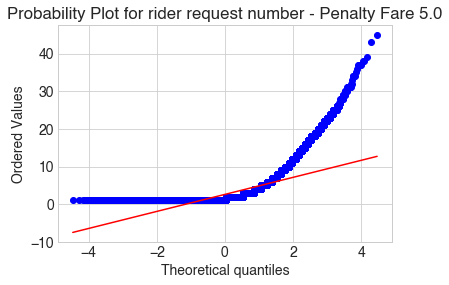

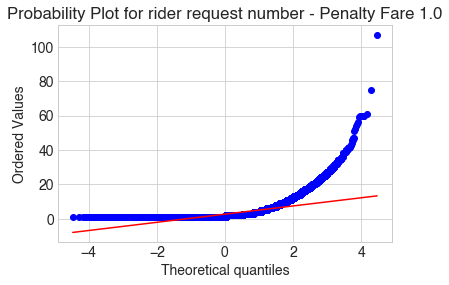

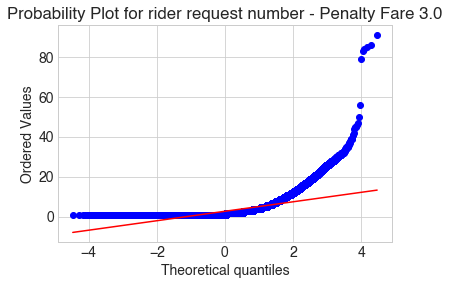

In [ ]:
# QQ-plot for each group
# rider_request_number
import scipy.stats as stats
penalty_groups = df_rider_all['cancel_penalty'].unique()

for penalty in penalty_groups:
    stats.probplot(df_rider_all[df_rider_all['cancel_penalty'] == penalty]['rider_request_number'], dist="norm", plot=plt)
    plt.title("Probability Plot for rider request number - Penalty Fare " +  str(penalty))
    plt.show()

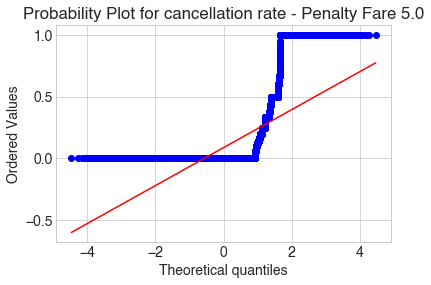

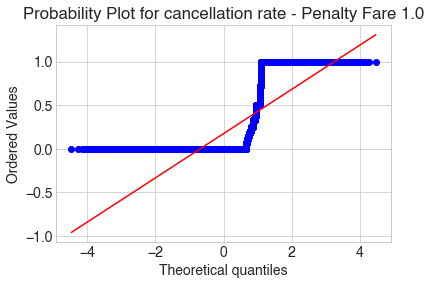

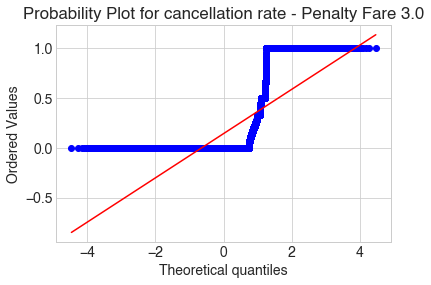

In [ ]:
# QQ-plot for each group
# cancellation_rate
import scipy.stats as stats
penalty_groups = df_rider_all['cancel_penalty'].unique()

for penalty in penalty_groups:
    stats.probplot(df_rider_all[df_rider_all['cancel_penalty'] == penalty]['cancellation_rate'], dist="norm", plot=plt)
    plt.title("Probability Plot for cancellation rate - Penalty Fare " +  str(penalty))
    plt.show()

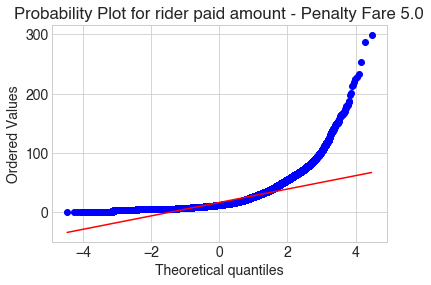

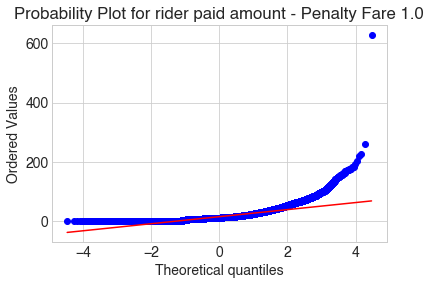

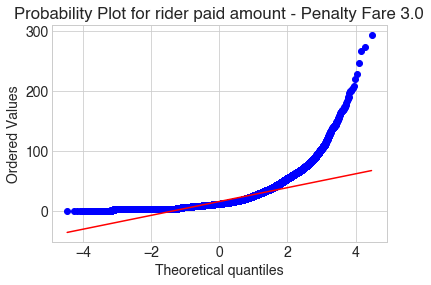

In [ ]:
# QQ-plot for each group
# rider_request_number
import scipy.stats as stats
penalty_groups = df_rider_all['cancel_penalty'].unique()

for penalty in penalty_groups:
    stats.probplot(df_rider_all[df_rider_all['cancel_penalty'] == penalty]['rider_paid_amount'], dist="norm", plot=plt)
    plt.title("Probability Plot for rider paid amount - Penalty Fare " +  str(penalty))
    plt.show()

p-value is 0, Q-Q plot is not linear 
=> The dataset is not normally distributed

We should use non parametric test to compare, no ANOVA

In [ ]:
from scipy.stats import f_oneway, levene

def plot_histogram(data, title, label):
    '''
    Plot a histogram given data and the title of histogram.
    '''
    plt.hist(data, bins=10) 
    plt.axvline(x=np.mean(data), c = 'r')
    plt.text(np.mean(data)+2, 13, round(np.mean(data),2), c='r')
    plt.xlim(0, 100)
    plt.ylim(0, 15)
    plt.title(title)
    plt.xlabel(label)
    plt.ylabel("Frequency")

df_rider_1 = df_rider_all[df_rider_all['cancel_penalty'] == 1]
df_rider_3 = df_rider_all[df_rider_all['cancel_penalty'] == 3]
df_rider_5 = df_rider_all[df_rider_all['cancel_penalty'] == 5]

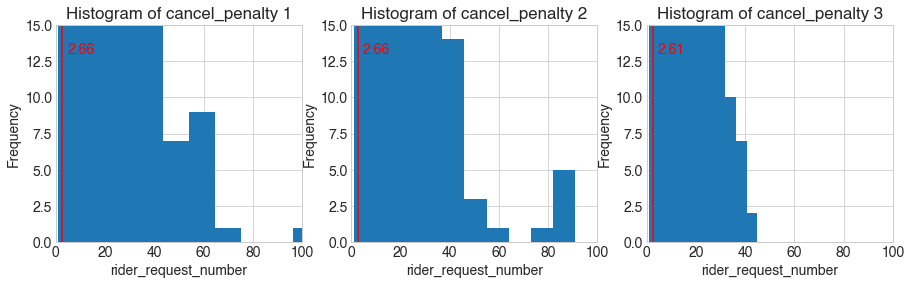

Levene's test for rider_request_number's p value = 2.1415124671703738e-08


In [ ]:
# rider_request_number

label = 'rider_request_number'
fig = plt.figure(figsize=(15,4))   
fig.subplots_adjust(wspace=0.2, hspace=0.1) 

# histogram for penalty 1
ax1 = fig.add_subplot(131) 
plot_histogram(df_rider_1[label], "Histogram of cancel_penalty 1", label)

# histogram for penalty 3
ax2 = fig.add_subplot(132) 
plot_histogram(df_rider_3[label], "Histogram of cancel_penalty 2", label)

# histogram for penalty 5
ax3 = fig.add_subplot(133) 
plot_histogram(df_rider_5[label], "Histogram of cancel_penalty 3", label)

plt.show()

# Check variance 
# 1. Manual comparison
np.var(df_rider_1[label]), np.var(df_rider_3[label]), np.var(df_rider_5[label])
# 2. Levene's test
stat, p = levene(df_rider_1[label], df_rider_3[label], df_rider_5[label])
print(f"Levene's test for {label}'s p value = {p}")

In [ ]:
label = 'cancellation_rate'

stat, p = levene(np.log(df_rider_1[label]+1), np.log(df_rider_3[label]+1), np.log(df_rider_5[label]+1))
print(f"Levene's test for {label}'s p value = {p} (log tranformed)")

Levene's test for cancellation_rate's p value = 0.0 (log tranformed)


In [ ]:
label = 'rider_request_number'

stat, p = levene(np.log(df_rider_1[label]+1), np.log(df_rider_3[label]+1), np.log(df_rider_5[label]+1))
print(f"Levene's test for {label}'s p value = {p} (log tranformed)")

Levene's test for rider_request_number's p value = 0.0032048132773742194 (log tranformed)


In [ ]:
label = 'rider_paid_amount'

stat, p = levene(np.log(df_rider_1[label]+1), np.log(df_rider_3[label]+1), np.log(df_rider_5[label]+1))
print(f"Levene's test for {label}'s p value = {p} (log transformed)")

Levene's test for rider_paid_amount's p value = 0.0 (log transformed)


In [ ]:
label = 'rider_request_number'

stat, p = levene(np.log(df_rider_1[label]+1), np.log(df_rider_3[label]+1), np.log(df_rider_5[label]+1))
print(f"Levene's test for {label}'s p value = {p}, log tranformed")

Levene's test for rider_request_number's p value = 0.0032048132773742194, log tranformed


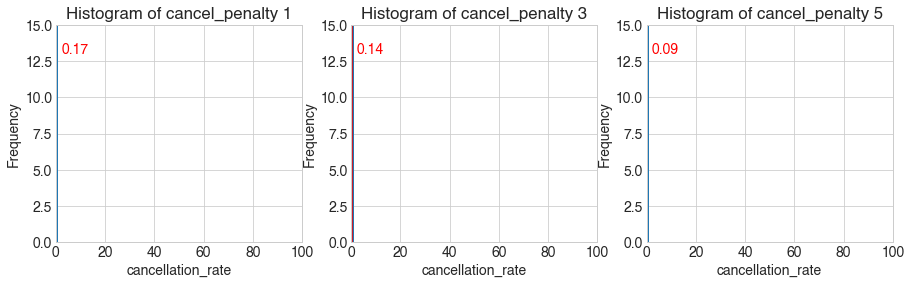

Levene's test for cancellation_rate's p value = 0.0


In [ ]:
# cancellation_rate
from scipy.stats import f_oneway, levene
label = 'cancellation_rate'
fig = plt.figure(figsize=(15,4))   
fig.subplots_adjust(wspace=0.2, hspace=0.1) 

# histogram for penalty 1
ax1 = fig.add_subplot(131) 
plot_histogram(df_rider_1[label], "Histogram of cancel_penalty 1", label)

# histogram for penalty 3
ax2 = fig.add_subplot(132) 
plot_histogram(df_rider_3[label], "Histogram of cancel_penalty 3", label)

# histogram for penalty 5
ax3 = fig.add_subplot(133) 
plot_histogram(df_rider_5[label], "Histogram of cancel_penalty 5", label)

plt.show()

# Check variance 
# 1. Manual comparison
np.var(df_rider_1[label]), np.var(df_rider_3[label]), np.var(df_rider_5[label])
# 2. Levene's test
stat, p = levene(df_rider_1[label], df_rider_3[label], df_rider_5[label])
print(f"Levene's test for {label}'s p value = {p}")

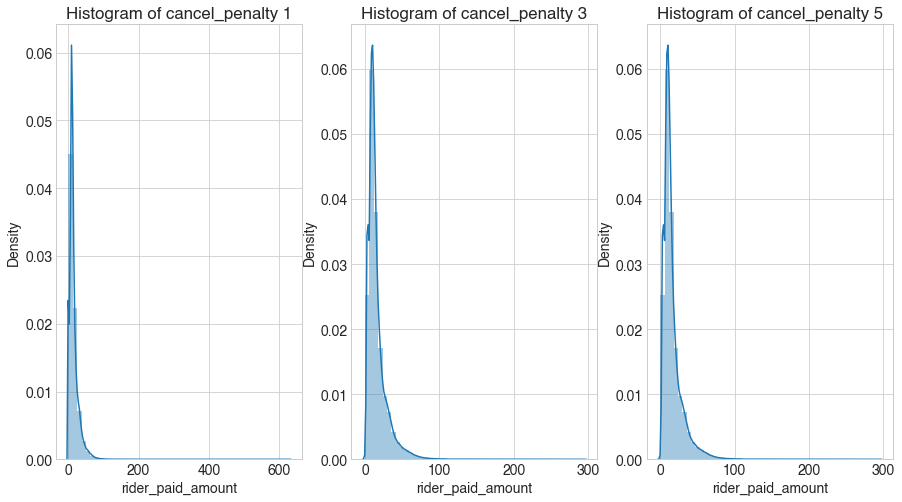

181.26600168996694 177.362149215595 173.78506467115588
Levene's test for rider_paid_amount's p value = 5.165590426548579e-29


In [ ]:
# rider_paid_amount

label = 'rider_paid_amount'
fig = plt.figure(figsize=(15,8))   
fig.subplots_adjust(wspace=0.2, hspace=0.1) 

# histogram for penalty 1
ax1 = fig.add_subplot(131) 
sns.distplot(df_rider_1[label], ax=ax1)
ax1.set_title("Histogram of cancel_penalty 1")

# histogram for penalty 3
ax2 = fig.add_subplot(132) 
# plot_histogram(df_rider_3[label], "Histogram of cancel_penalty 3", label)
sns.distplot(df_rider_3[label], ax=ax2)
ax2.set_title("Histogram of cancel_penalty 3")
# histogram for penalty 5
ax3 = fig.add_subplot(133) 
# plot_histogram(df_rider_5[label], "Histogram of cancel_penalty 5", label)
sns.distplot(df_rider_3[label], ax=ax3)
ax3.set_title("Histogram of cancel_penalty 5")

plt.show()

# Check variance 
# 1. Manual comparison
print(np.var(df_rider_1[label]), np.var(df_rider_3[label]), np.var(df_rider_5[label]))

# 2. Levene's test
stat, p = levene(df_rider_1[label], df_rider_3[label], df_rider_5[label])

print(f"Levene's test for {label}'s p value = {p}")


In [ ]:
# cancellation_rate
from scipy.stats import levene
label = 'cancellation_rate'

stat, p = levene(df_rider_1[label], df_rider_3[label], df_rider_5[label])
print(f"Levene's test for {label}'s p value = {p}")

Levene's test for cancellation_rate's p value = 0.0


In [ ]:
# rider_paid_amount

label = 'rider_paid_amount'

stat, p = levene(df_rider_1[label], df_rider_3[label], df_rider_5[label])
print(f"Levene's test for {label}'s p value = {p}")

Levene's test for rider_paid_amount's p value = 5.165590426548579e-29


In [ ]:
# rider_request_number

label = 'rider_request_number'

stat, p = levene(df_rider_1[label], df_rider_3[label], df_rider_5[label])
print(f"Levene's test for {label}'s p value = {p}")

Levene's test for rider_request_number's p value = 2.1415124671703738e-08


Variance comparison
For each group of penalty fee and labels (cancellation_rate, rider_paid_amount, rider_request_number), the variances of are differnt 

Normality when the sample size is really large in this case (Central Limit Theorem)

We can go ahead with ANOVA test followed by post hoc test (Tukey's test)

OR

We try non-parametric test to compare all 3 penalty groups



#### Non parametric Tests

Indepedence - Kruskal-Wallis H-test

In [ ]:
# Assume independent
# Kruskal-Wallis H-test
# cancellation_rate
from numpy.random import seed
from numpy.random import randn
from scipy.stats import kruskal

print("Kruskal-Wallis H-test - Assume variables indepenent")
label = 'cancellation_rate'

stat, p = kruskal(df_rider_1[label], df_rider_3[label], df_rider_5[label])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print(f'{label} has same distributions (fail to reject H0) among different penalty group')
else:
	print(f'{label} has different distributions (reject H0) among different penalty group')

Kruskal-Wallis H-test - Assume variables indepenent
Statistics=4238.919, p=0.000
cancellation_rate has different distributions (reject H0) among different penalty group


In [ ]:
# Assume independent
# Kruskal-Wallis H-test
# rider_paid_amount
from numpy.random import seed
from numpy.random import randn
from scipy.stats import kruskal

print("Kruskal-Wallis H-test - Assume variables indepenent")
label = 'rider_paid_amount'

stat, p = kruskal(df_rider_1[label], df_rider_3[label], df_rider_5[label])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('{label} has same distributions (fail to reject H0) among different penalty group')
else:
	print(f'{label} has different distributions (reject H0) among different penalty group')

Kruskal-Wallis H-test - Assume variables indepenent
Statistics=3826.589, p=0.000
rider_paid_amount has different distributions (reject H0) among different penalty group


In [ ]:
# Assume independent
# Kruskal-Wallis H-test
# rider_request_number
from numpy.random import seed
from numpy.random import randn
from scipy.stats import kruskal

print("Kruskal-Wallis H-test - Assume variables indepenent")
label = 'rider_request_number'

stat, p = kruskal(df_rider_1[label], df_rider_3[label], df_rider_5[label])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print(f'{label} has same distributions (fail to reject H0) among different penalty group')
else:
	print(f'{label} has different distributions (reject H0) among different penalty group')

Kruskal-Wallis H-test - Assume variables indepenent
Statistics=4.636, p=0.098
rider_request_number has same distributions (fail to reject H0) among different penalty group


#### If dependent => Friedman test

In [ ]:
# If dependent
# Friedman test
# cancellation_rate
from numpy.random import seed
from numpy.random import randn
from scipy.stats import friedmanchisquare

print("Friedman's Test")
label = 'cancellation_rate'


min_df_length = min(map(len, [df_rider_1[label], df_rider_3[label], df_rider_5[label]]))

df_rider_sample_1 = random.sample(list(df_rider_1[label]), min_df_length)
df_rider_sample_3 = random.sample(list(df_rider_3[label]), min_df_length)
df_rider_sample_5 = random.sample(list(df_rider_5[label]), min_df_length)


stat, p = friedmanchisquare(df_rider_sample_1, df_rider_sample_3, df_rider_sample_5)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret

alpha = 0.05
if p > alpha:
	print(f'{label} has same distributions (fail to reject H0) among different penalty group')
else:
	print(f'{label} has different distributions (reject H0) among different penalty group')


Friedman's Test
Statistics=3934.712, p=0.000
cancellation_rate has different distributions (reject H0) among different penalty group


In [ ]:
# If dependent
# Friedman test
# rider_paid_amount
from numpy.random import seed
from numpy.random import randn
from scipy.stats import friedmanchisquare

print("Friedman's Test")
label = 'rider_paid_amount'


min_df_length = min(map(len, [df_rider_1[label], df_rider_3[label], df_rider_5[label]]))

df_rider_sample_1 = random.sample(list(df_rider_1[label]), min_df_length)
df_rider_sample_3 = random.sample(list(df_rider_3[label]), min_df_length)
df_rider_sample_5 = random.sample(list(df_rider_5[label]), min_df_length)


stat, p = friedmanchisquare(df_rider_sample_1, df_rider_sample_3, df_rider_sample_5)
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
	print(f'{label} has same distributions (fail to reject H0) among different penalty group')
else:
	print(f'{label} has different distributions (reject H0) among different penalty group')


Friedman's Test
Statistics=2876.103, p=0.000
rider_paid_amount has different distributions (reject H0) among different penalty group


In [ ]:
# If dependent
# Friedman test
# rider_request_number
from numpy.random import seed
from numpy.random import randn
from scipy.stats import friedmanchisquare

print("Friedman's Test")
label = 'rider_request_number'


min_df_length = min(map(len, [df_rider_1[label], df_rider_3[label], df_rider_5[label]]))

df_rider_sample_1 = random.sample(list(df_rider_1[label]), min_df_length)
df_rider_sample_3 = random.sample(list(df_rider_3[label]), min_df_length)
df_rider_sample_5 = random.sample(list(df_rider_5[label]), min_df_length)


stat, p = friedmanchisquare(df_rider_sample_1, df_rider_sample_3, df_rider_sample_5)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print(f'{label} has same distributions (fail to reject H0) among different penalty group')
else:
	print(f'{label} has different distributions (reject H0) among different penalty group')


Friedman's Test
Statistics=4.824, p=0.090
rider_request_number has same distributions (fail to reject H0) among different penalty group


In [ ]:


from scipy.stats import levene

# -------
##### Pairwise z-test (Assume normal)

In [ ]:
# experiment to check if means of each pairs of group have significant difference 
# for cancellation rate

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
def cancellation_rate_z_test(df_ride_exp, c, t):
    print(f"Comparing Cancellation Rate of Penalty {c} and {t}")
    control = df_ride_exp[df_ride_exp['cancel_penalty'] == c]['cancellation_flag']
    treatment = df_ride_exp[df_ride_exp['cancel_penalty'] == t]['cancellation_flag']
    n_con = control.count()
    n_treat = treatment.count()
    successes = [control.sum(), treatment.sum()]
    nobs = [n_con, n_treat]

    z_stat, pval = proportions_ztest(successes, nobs=nobs)
    (lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05/3)

    print(f'z statistic: {z_stat:.2f}')
    print(f'p-value: {pval}')
    print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
    print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

In [ ]:
cancellation_rate_z_test(df_ride_exp, 1, 3)

Comparing Cancellation Rate of Penalty 1 and 3
z statistic: 43.89
p-value: 0.0
ci 95% for control group: [0.187, 0.189]
ci 95% for treatment group: [0.153, 0.155]


In [ ]:
cancellation_rate_z_test(df_ride_exp, 1, 5)

Comparing Cancellation Rate of Penalty 1 and 5
z statistic: 120.16
p-value: 0.0
ci 95% for control group: [0.187, 0.189]
ci 95% for treatment group: [0.099, 0.101]


In [ ]:
cancellation_rate_z_test(df_ride_exp, 3, 5)

Comparing Cancellation Rate of Penalty 3 and 5
z statistic: 77.44
p-value: 0.0
ci 95% for control group: [0.153, 0.155]
ci 95% for treatment group: [0.099, 0.101]


##### ANOVA Test (Assume normal and similar variance)

In [ ]:


def anova_test(df, label, sampled=False):
    import scipy.stats as stats
    fvalue, pvalue = stats.f_oneway(
                                    df[label][df['cancel_penalty']==5], 
                                    df[label][df['cancel_penalty'] ==3],
                                    df[label][df['cancel_penalty'] ==1]
                                    )
    if sampled:
        print(f"Sampled - Comparing {label} mean values among different cancel penalties")        
    else:
        print(f"Comparing {label} mean values among different cancel penalties")
    print(f"f value: {fvalue}")
    print(f"p value: {pvalue}")
    


In [ ]:
# group 5, 3, 1 
# cancellation_rate

anova_test(df_rider_all, 'cancellation_rate')

Comparing cancellation_rate mean values among different cancel penalties
f value: 3625.225772240985
p value: 0.0


In [ ]:
# group 5, 3, 1 
# cancellation_rate

anova_test(df_sample_riders, 'cancellation_rate', sampled=True)

Sampled - Comparing cancellation_rate mean values among different cancel penalties
f value: 177.98040919002042
p value: 1.6281568923438986e-77


In [ ]:
# group 5, 3, 1 
# rider_paid_amount
anova_test(df_rider_all, 'rider_paid_amount')

Comparing rider_paid_amount mean values among different cancel penalties
f value: 893.2333787450867
p value: 0.0


In [ ]:
# group 5, 3, 1 
# rider_paid_amount
anova_test(df_sample_riders, 'rider_paid_amount', sampled=True)

Sampled - Comparing rider_paid_amount mean values among different cancel penalties
f value: 58.39035967820173
p value: 4.9698817187655413e-26


In [ ]:
# group 5, 3, 1 
# rider_request_number
anova_test(df_rider_all, 'rider_request_number')

Comparing rider_request_number mean values among different cancel penalties
f value: 17.659757828543164
p value: 2.1415124671703738e-08


In [ ]:
# group 5, 3, 1 
# rider_request_number
anova_test(df_sample_riders, 'rider_request_number', sampled=True)

Sampled - Comparing rider_request_number mean values among different cancel penalties
f value: 8.13244905811076
p value: 0.00029457166677791677


There are statistically significance for all 3 target metrics (rider_paid_amount, cancellation_rate, rider_request_number)

### Post Hoc Test for Kruskal wallis - Dunn Test

#

In [ ]:
import scikit_posthocs as sp

label = 'cancellation_rate'
p_adjust = 'fdr_bh'
p_values = sp.posthoc_dunn(df_rider_all, val_col=label, group_col='cancel_penalty', p_adjust=p_adjust)

print(f"Dunn's Test - Multiple Comparison for all pairs of penalty groups ($1, $3, $5)")
print("Adjusted P-value < 0.05")
print(f"{label.replace('_', ' ')}")
p_values < 0.05

Dunn's Test - Multiple Comparison for all pairs of penalty groups ($1, $3, $5)
Adjusted P-value < 0.05
cancellation rate


1.0    3.0    5.0
1.0  False   True   True
3.0   True  False   True
5.0   True   True  False

In [ ]:
import scikit_posthocs as sp

label = 'rider_paid_amount'
p_adjust = 'fdr_bh'
p_values = sp.posthoc_dunn(df_rider_all, val_col=label, group_col='cancel_penalty', p_adjust=p_adjust)

print(f"Dunn's Test - Multiple Comparison for all pairs of penalty groups ($1, $3, $5)")
print("Adjusted P-value < 0.05")
print(f"{label.replace('_', ' ')}")
p_values < 0.05


Dunn's Test - Multiple Comparison for all pairs of penalty groups ($1, $3, $5)
Adjusted P-value < 0.05
rider paid amount


1.0    3.0    5.0
1.0  False   True   True
3.0   True  False   True
5.0   True   True  False

In [ ]:
import scikit_posthocs as sp

label = 'rider_request_number'
p_adjust = 'fdr_bh'
p_values = sp.posthoc_dunn(df_rider_all, val_col=label, group_col='cancel_penalty', p_adjust=p_adjust)

print(f"Dunn's Test - Multiple Comparison for all pairs of penalty groups ($1, $3, $5)")
print("Adjusted P-value < 0.05")
print(f"{label.replace('_', ' ')}")
p_values < 0.05

Dunn's Test - Multiple Comparison for all pairs of penalty groups ($1, $3, $5)
Adjusted P-value < 0.05
rider request number


1.0    3.0    5.0
1.0  False  False  False
3.0  False  False  False
5.0  False  False  False

In [ ]:
# bonferroni p_adjust
import scikit_posthocs as sp

label = 'cancellation_rate'
p_adjust = 'bonferroni'
p_values = sp.posthoc_dunn(df_rider_all, val_col=label, group_col='cancel_penalty', p_adjust=p_adjust)

print(f"Dunn's Test - Multiple Comparison for all pairs of penalty groups ($1, $3, $5)")
print("Adjusted P-value < 0.05")
print(f"{label.replace('_', ' ')}")
p_values < 0.05


Dunn's Test - Multiple Comparison for all pairs of penalty groups ($1, $3, $5)
Adjusted P-value < 0.05
cancellation rate


1.0    3.0    5.0
1.0  False   True   True
3.0   True  False   True
5.0   True   True  False

In [ ]:

print(f"Dunn's Test - Multiple Comparison for all pairs of penalty groups ($1, $3, $5)")
print("Adjusted P-value < 0.05")
print(f"{label.replace('_', ' ')}")
p_values


Dunn's Test - Multiple Comparison for all pairs of penalty groups ($1, $3, $5)
Adjusted P-value < 0.05
cancellation rate


1.0            3.0  5.0
1.0   1.000000e+00  7.732986e-111  0.0
3.0  7.732986e-111   1.000000e+00  0.0
5.0   0.000000e+00   0.000000e+00  1.0

In [ ]:
import scikit_posthocs as sp

label = 'rider_paid_amount'
p_adjust = 'bonferroni'
p_values = sp.posthoc_dunn(df_rider_all, val_col=label, group_col='cancel_penalty', p_adjust=p_adjust)

print(f"Dunn's Test - Multiple Comparison for all pairs of penalty groups ($1, $3, $5)")
print("Adjusted P-value < 0.05")
print(f"{label.replace('_', ' ')}")
p_values < 0.05


Dunn's Test - Multiple Comparison for all pairs of penalty groups ($1, $3, $5)
Adjusted P-value < 0.05
rider paid amount


1.0    3.0    5.0
1.0  False   True   True
3.0   True  False   True
5.0   True   True  False

In [ ]:
print(f"Dunn's Test - Multiple Comparison for all pairs of penalty groups ($1, $3, $5)")
print("Adjusted P-value < 0.05")
print(f"{label.replace('_', ' ')}")
p_values

Dunn's Test - Multiple Comparison for all pairs of penalty groups ($1, $3, $5)
Adjusted P-value < 0.05
rider paid amount


1.0            3.0            5.0
1.0   1.000000e+00  1.594119e-151   0.000000e+00
3.0  1.594119e-151   1.000000e+00  1.340138e-273
5.0   0.000000e+00  1.340138e-273   1.000000e+00

In [ ]:
import scikit_posthocs as sp

label = 'rider_paid_amount'
p_adjust = 'bonferroni'
p_values = sp.posthoc_dunn(df_rider_all, val_col=label, group_col='cancel_penalty')

print(f"Dunn's Test - Multiple Comparison for all pairs of penalty groups ($1, $3, $5)")
print("Adjusted P-value < 0.05")
print(f"{label.replace('_', ' ')}")
p_values

Dunn's Test - Multiple Comparison for all pairs of penalty groups ($1, $3, $5)
Adjusted P-value < 0.05
rider paid amount


1.0            3.0            5.0
1.0   1.000000e+00  5.313729e-152   0.000000e+00
3.0  5.313729e-152   1.000000e+00  4.467126e-274
5.0   0.000000e+00  4.467126e-274   1.000000e+00

In [ ]:
import scikit_posthocs as sp

label = 'rider_request_number'
p_adjust = 'bonferroni'
p_values = sp.posthoc_dunn(df_rider_all, val_col=label, group_col='cancel_penalty', p_adjust=p_adjust)

print(f"Dunn's Test - Multiple Comparison for all pairs of penalty groups ($1, $3, $5)")
print("Adjusted P-value < 0.05")
print(f"{label.replace('_', ' ')}")
p_values < 0.05


Dunn's Test - Multiple Comparison for all pairs of penalty groups ($1, $3, $5)
Adjusted P-value < 0.05
rider request number


1.0    3.0    5.0
1.0  False  False  False
3.0  False  False  False
5.0  False  False  False

In [ ]:
print(f"Dunn's Test - Multiple Comparison for all pairs of penalty groups ($1, $3, $5)")
print("Adjusted P-value < 0.05")
print(f"{label.replace('_', ' ')}")
p_values

Dunn's Test - Multiple Comparison for all pairs of penalty groups ($1, $3, $5)
Adjusted P-value < 0.05
rider request number


1.0       3.0       5.0
1.0  1.000000  1.000000  0.202117
3.0  1.000000  1.000000  0.172886
5.0  0.202117  0.172886  1.000000

### Post Hoc - Tukey's Test

Follow up with Post Hoc Test for rider_paid_amount and cancellation_rate among the 3 groups.
We use Tukey's test

In [ ]:
def tukey_test(df, label, sampled=False, log=False):
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    tukey = pairwise_tukeyhsd(endog=df[label],
                            groups=df['cancel_penalty'],
                            alpha=0.05)
    if log == True:
        tukey = pairwise_tukeyhsd(endog=np.log(df[label]+1),
                            groups=df['cancel_penalty'],
                            alpha=0.05)
    print(tukey)
    tukey.plot_simultaneous(ylabel= "Cancel Penalty", xlabel= label)
    if log:
        if sampled:
            plt.title("Log Sampled - Multiple Comparisons Between All Pairs (Tukey)")
        else:
            plt.title("Log - Multiple Comparisons Between All Pairs (Tukey)")
    else:
        if sampled:
            plt.title("Sampled - Multiple Comparisons Between All Pairs (Tukey)")
        else:
            plt.title("Multiple Comparisons Between All Pairs (Tukey)")




Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   1.0    3.0  -0.0315 0.001 -0.0423 -0.0208   True
   1.0    5.0  -0.0848 0.001 -0.0955 -0.0742   True
   3.0    5.0  -0.0533 0.001  -0.064 -0.0427   True
---------------------------------------------------


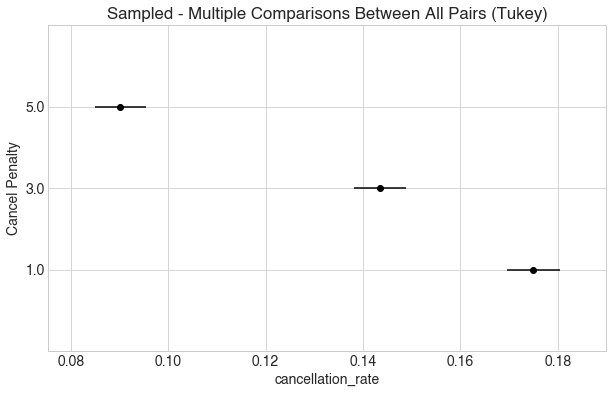

In [ ]:
# tukey's test
# group 5, 3, 1 
# cancellation_rate

# tukey_test(df_rider_all, 'cancellation_rate')
tukey_test(df_sample_riders, 'cancellation_rate', sampled=True)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
   1.0    3.0   1.3387 0.001 0.8743 1.8031   True
   1.0    5.0   2.1045 0.001 1.6431  2.566   True
   3.0    5.0   0.7658 0.001 0.3047 1.2269   True
-------------------------------------------------


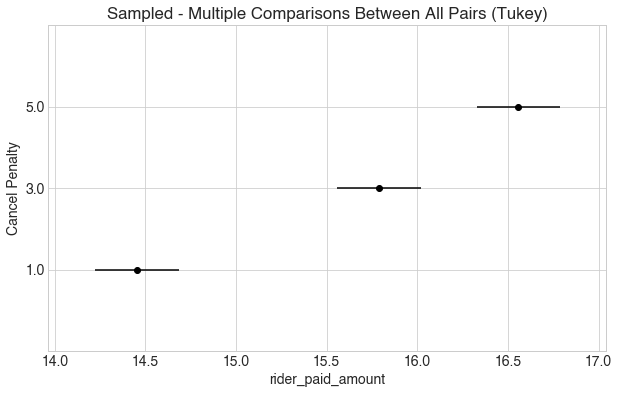

In [ ]:
# tukey's test
# group 5, 3, 1 
# rider_paid_amount
# tukey_test(df_rider_all, 'rider_paid_amount')
tukey_test(df_sample_riders, 'rider_paid_amount', sampled=True)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   1.0    3.0  -0.1079  0.054 -0.2172  0.0014  False
   1.0    5.0  -0.1863  0.001  -0.295 -0.0777   True
   3.0    5.0  -0.0784 0.2081  -0.187  0.0302  False
----------------------------------------------------


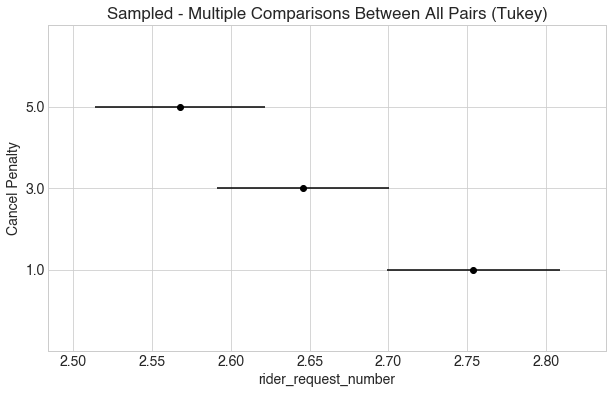

In [ ]:
# tukey's test
# group 5, 3, 1 
# rider_request_number

# tukey_test(df_rider_all, 'rider_request_number')
tukey_test(df_sample_riders, 'rider_request_number', sampled=True)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   1.0    3.0   -0.021 0.001 -0.0227 -0.0193   True
   1.0    5.0  -0.0591 0.001 -0.0608 -0.0574   True
   3.0    5.0  -0.0381 0.001 -0.0398 -0.0364   True
---------------------------------------------------


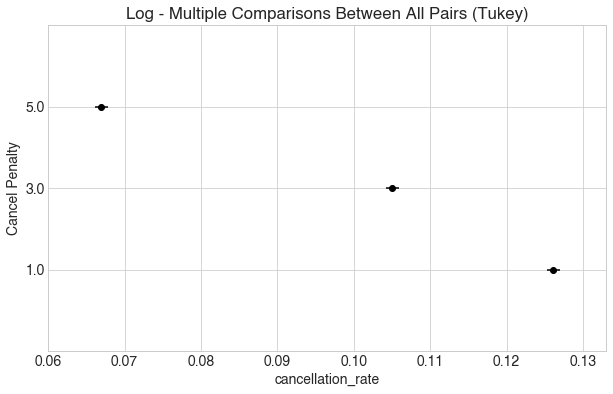

In [ ]:
tukey_test(df_rider_all, 'cancellation_rate', sampled=False, log=True)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
   1.0    3.0   0.1495 0.001 0.1438 0.1552   True
   1.0    5.0    0.256 0.001 0.2503 0.2617   True
   3.0    5.0   0.1065 0.001 0.1008 0.1122   True
-------------------------------------------------


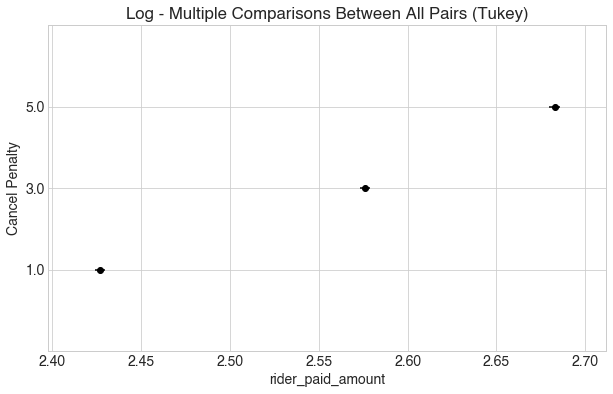

In [ ]:
tukey_test(df_rider_all, 'rider_paid_amount', sampled=False, log=True)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   1.0    3.0   0.0003    0.9  -0.004  0.0046  False
   1.0    5.0  -0.0052 0.0122 -0.0095 -0.0009   True
   3.0    5.0  -0.0055 0.0073 -0.0098 -0.0012   True
----------------------------------------------------


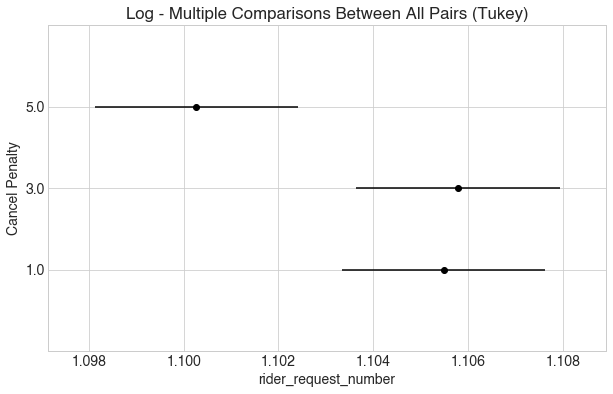

In [ ]:
tukey_test(df_rider_all, 'rider_request_number', sampled=False, log=True)

### Log Transformation - check group's distribution

Penalty 5

Text(0.5, 1.0, 'Average cancellation rate for penalty $5 riders - log transformed')

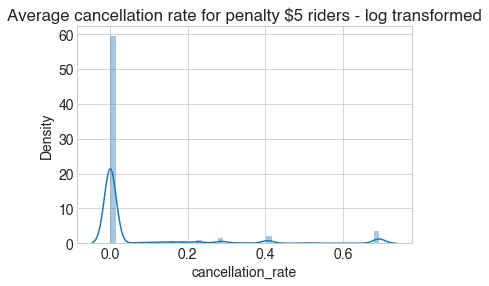

In [ ]:

# penalty 5
# cancellation_rate

df = df_rider_5
label = 'cancellation_rate'
sns.distplot(np.log(df[label]+1))
plt.title(f"Average {label.replace('_', ' ')} for penalty $5 riders - log transformed")



Text(0.5, 1.0, 'Average rider paid amount for penalty $5 riders - log transformed')

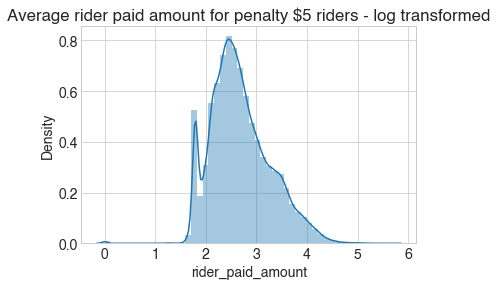

In [ ]:
# penalty 5
# rider_paid_amount

df = df_rider_5
label = 'rider_paid_amount'
sns.distplot(np.log(df[label]+1))
plt.title(f"Average {label.replace('_', ' ')} for penalty $5 riders - log transformed")



Text(0.5, 1.0, 'Average rider request number for penalty $5 riders - log transformed')

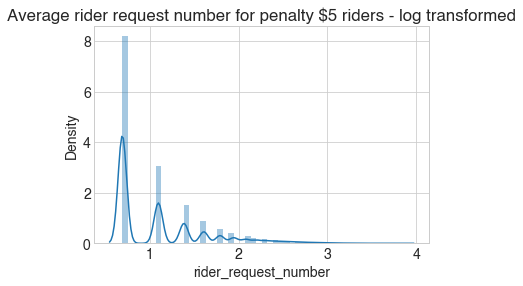

In [ ]:
# penalty 5
# rider_request_number

df = df_rider_5
label = 'rider_request_number'
sns.distplot(np.log(df[label]+1))
plt.title(f"Average {label.replace('_', ' ')} for penalty $5 riders - log transformed")


Text(0.5, 1.0, 'Average cancellation rate for penalty $3 riders - log transformed')

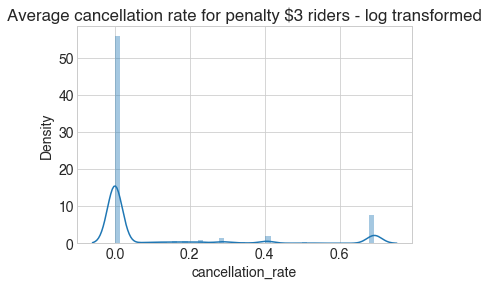

In [ ]:
# penalty 3
# cancellation_rate

df = df_rider_3
label = 'cancellation_rate'
sns.distplot(np.log(df[label]+1))
plt.title(f"Average {label.replace('_', ' ')} for penalty $3 riders - log transformed")

Text(0.5, 1.0, 'Average rider paid amount for penalty $3 riders - log transformed')

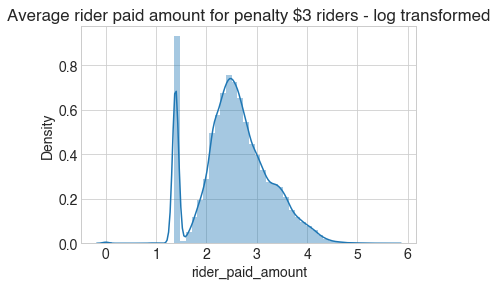

In [ ]:
# penalty 3
# rider_paid_amount

df = df_rider_3
label = 'rider_paid_amount'
sns.distplot(np.log(df[label]+1))
plt.title(f"Average {label.replace('_', ' ')} for penalty $3 riders - log transformed")

Text(0.5, 1.0, 'Average rider request number for penalty $3 riders - log transformed')

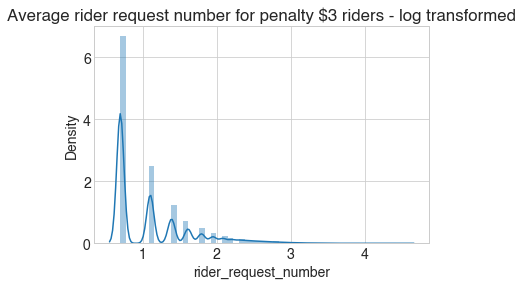

In [ ]:
# penalty 3
# rider_request_number

df = df_rider_3
label = 'rider_request_number'
sns.distplot(np.log(df[label]+1))
plt.title(f"Average {label.replace('_', ' ')} for penalty $3 riders - log transformed")

Text(0.5, 1.0, 'Average cancellation rate for penalty $1 riders - log transformed')

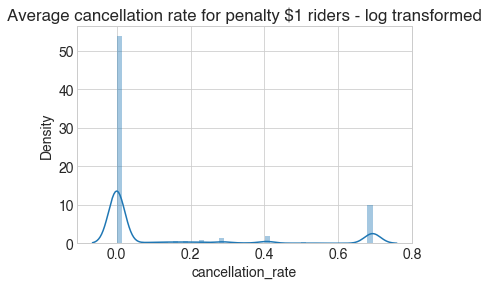

In [ ]:
# penalty 1
# cancellation_rate

df = df_rider_1
label = 'cancellation_rate'
sns.distplot(np.log(df[label]+1))
plt.title(f"Average {label.replace('_', ' ')} for penalty $1 riders - log transformed")

Text(0.5, 1.0, 'Average rider paid amount for penalty $1 riders - log transformed')

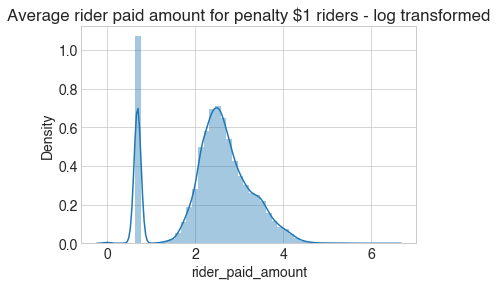

In [ ]:
# penalty 1
# rider_paid_amount

df = df_rider_1
label = 'rider_paid_amount'
sns.distplot(np.log(df[label]+1))
plt.title(f"Average {label.replace('_', ' ')} for penalty $1 riders - log transformed")

Text(0.5, 1.0, 'Average rider request number for penalty $1 riders - log transformed')

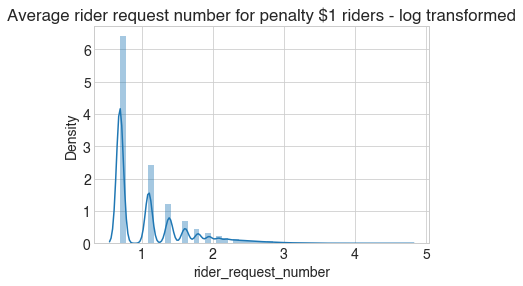

In [ ]:
# penalty 1
# rider_request_number

df = df_rider_1
label = 'rider_request_number'
sns.distplot(np.log(df[label]+1))
plt.title(f"Average {label.replace('_', ' ')} for penalty $1 riders - log transformed")

Text(0.5, 1.0, 'Average rider request number for penalty $1 riders')

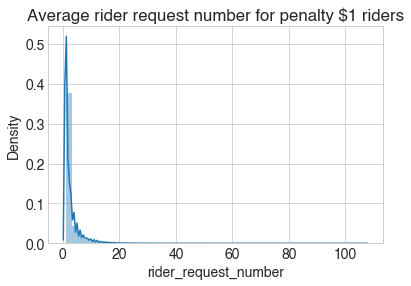

In [ ]:
# penalty 1
# rider_request_number

df = df_rider_1
label = 'rider_request_number'
sns.distplot(df[label])
plt.title(f"Average {label.replace('_', ' ')} for penalty $1 riders")

Text(0.5, 1.0, 'Average rider request number for penalty $3 riders')

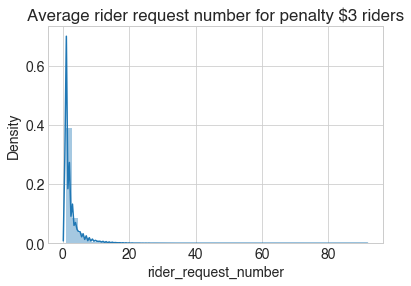

In [ ]:
# penalty 1
# rider_request_number

df = df_rider_3
label = 'rider_request_number'
sns.distplot(df[label])
plt.title(f"Average {label.replace('_', ' ')} for penalty $3 riders")

Text(0.5, 1.0, 'Average rider request number for penalty $5 riders')

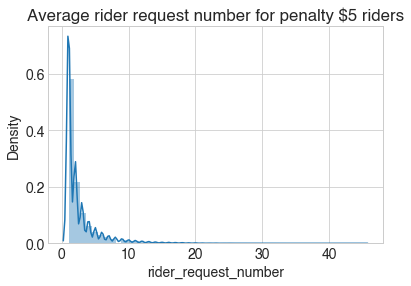

In [ ]:
# penalty 1
# rider_request_number

df = df_rider_5
label = 'rider_request_number'
sns.distplot(df[label])
plt.title(f"Average {label.replace('_', ' ')} for penalty $5 riders")

Text(0.5, 1.0, 'Average cancellation rate for penalty $1 riders')

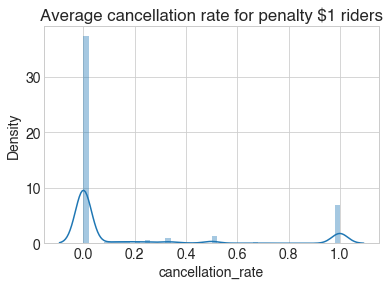

In [ ]:
# penalty 1
# cancellation_rate

df = df_rider_1
label = 'cancellation_rate'
sns.distplot(df[label])
plt.title(f"Average {label.replace('_', ' ')} for penalty $1 riders")

Text(0.5, 1.0, 'Average cancellation rate for penalty $3 riders')

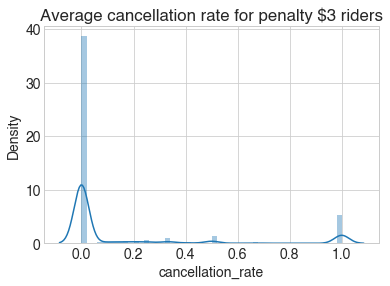

In [ ]:
# penalty 1
# cancellation_rate

df = df_rider_3
label = 'cancellation_rate'
sns.distplot(df[label])
plt.title(f"Average {label.replace('_', ' ')} for penalty $3 riders")

Text(0.5, 1.0, 'Average cancellation rate for penalty $5 riders')

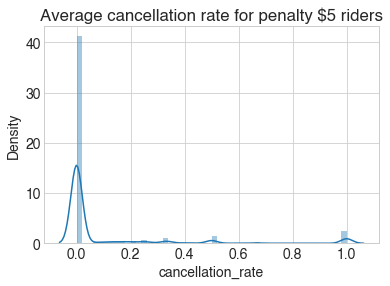

In [ ]:
# penalty 1
# cancellation_rate

df = df_rider_5
label = 'cancellation_rate'
sns.distplot(df[label])
plt.title(f"Average {label.replace('_', ' ')} for penalty $5 riders")

Text(0.5, 1.0, 'Average rider paid amount for penalty $1 riders')

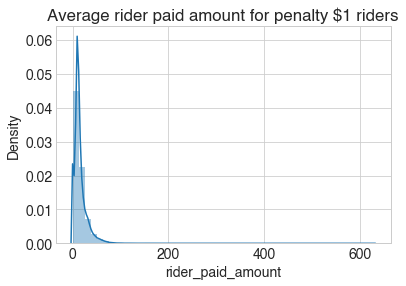

In [ ]:
# penalty 1
# rider_paid_amount

df = df_rider_1
label = 'rider_paid_amount'
sns.distplot(df[label])
plt.title(f"Average {label.replace('_', ' ')} for penalty $1 riders")

Text(0.5, 1.0, 'Average rider paid amount for penalty $3 riders')

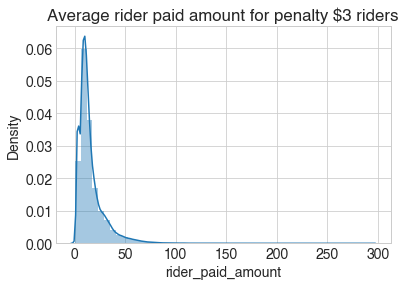

In [ ]:
# penalty 1
# rider_paid_amount

df = df_rider_3
label = 'rider_paid_amount'
sns.distplot(df[label])
plt.title(f"Average {label.replace('_', ' ')} for penalty $3 riders")

Text(0.5, 1.0, 'Average rider paid amount for penalty $5 riders')

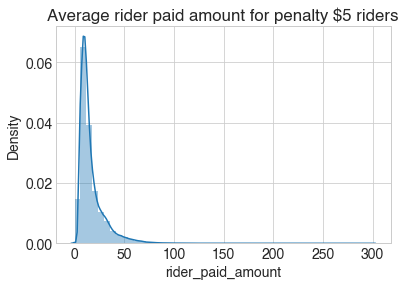

In [ ]:
# penalty 1
# rider_paid_amount

df = df_rider_5
label = 'rider_paid_amount'
sns.distplot(df[label])
plt.title(f"Average {label.replace('_', ' ')} for penalty $5 riders")

Text(0.5, 1.0, 'Average ride revenue per rider for penalty $5 riders - log transformed')

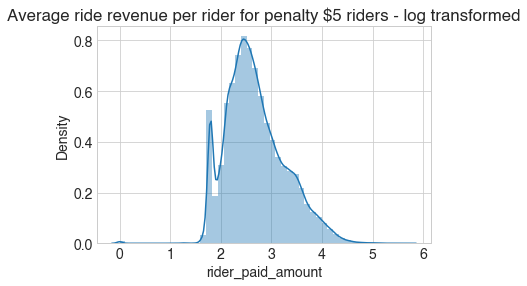

In [ ]:
sns.distplot(np.log(df_rider_5['rider_paid_amount']+1))
plt.title("Average ride revenue per rider for penalty $5 riders - log transformed")

Text(0.5, 1.0, 'Average rider request number for penalty $5 riders - log transformed')

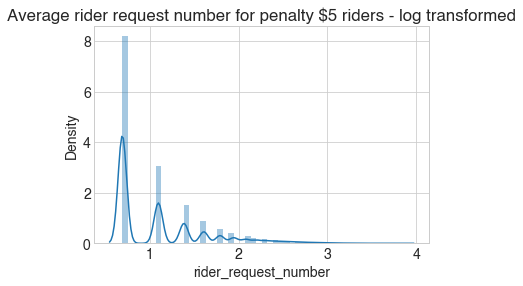

In [ ]:
sns.distplot(np.log(df_rider_5['rider_request_number']+1))
plt.title("Average rider request number for penalty $5 riders - log transformed")

Text(0.5, 1.0, 'Average ride revenue for penalty $5 riders - log transformed')

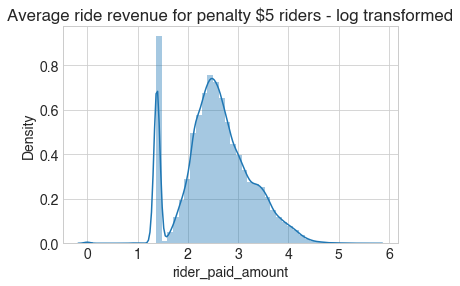

In [ ]:
sns.distplot(np.log(df_rider_3['rider_paid_amount']+1))
plt.title("Average ride revenue for penalty $5 riders - log transformed")

<AxesSubplot:xlabel='rider_paid_amount', ylabel='Density'>

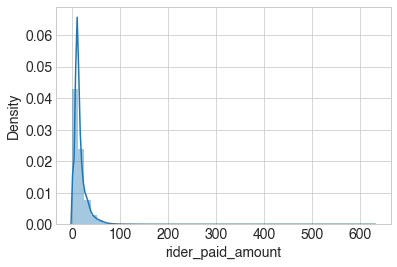

In [ ]:
sns.distplot(df_rider_all['rider_paid_amount'])